In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from datetime import datetime
import re
import numpy as np
from datetime import timedelta
from scipy import stats
import matplotlib.pyplot as plt
import warnings

In [2]:
warnings.filterwarnings('ignore', category=FutureWarning)

Dane zostały pobrane z strony [Opinion polling for the 2023 Polish parliamentary election](https://en.wikipedia.org/wiki/Opinion_polling_for_the_2023_Polish_parliamentary_election#)

In [3]:
page = requests.get('https://en.wikipedia.org/wiki/Opinion_polling_for_the_2023_Polish_parliamentary_election#')

Uzyskano html całej strony dla łatwego uzyskania informacji

In [4]:
soup = BeautifulSoup(page.text, 'html')

## Tworzenie Funcji do Wybierania Danych

#### For https://en.wikipedia.org/wiki/Opinion_polling_for_the_2023_Polish_parliamentary_election#

In [5]:
def clean_data_2023_pe(data_table, year_of_polls, table_headers):
    all_rows_data = []
    unique_connected_columns = []
    bool_2020_rafal_trzaskowski_data = False
    previous_row = []
    for row in data_table:
        check_double_2020 = False
        row_data = row.find_all(['td', 'th'])  # Include th tags as well if applicable
        print(row_data)
        individual_row_data = []
        collective_row_data = []
        whole_row_data = []
        idx = 0
        pattern_1 = r'\[.*?\]'
        pattern_2 = r' \b[a-zA-Z]{3}$'

        #Sprawdzenie pierwszej (i drugiej) warości w wierszu
        first_cell_text = row_data[0].text.strip()

        #Jeśli pierwsza wartość jest pusta albo wartość to nagłówek, pomijamy wiersz
        if not first_cell_text:
            continue
        elif first_cell_text in table_headers:
            continue
        
        second_cell_text = row_data[1].text.strip()
        second_cell_text = re.sub(pattern_1, '', second_cell_text) 
        #Sprawdzenie, czy druga wartość jest datą. Jeśli nie to, oznacza to, że jest to podwójny sondaż posiadający początkowe wartości z poprzedniego wiersza
        #TODO Problem, przez 
        match = re.search(pattern_2, second_cell_text)
        if not match and 'rowspan' in previous_row[1].attrs:
            for data in all_rows_data[-1][:3]:
                individual_row_data.append(data)
            idx = 3    
            print("----- \/ DOUBLED POLL DETECTED BELOW \/ -----")
            try:
                first_cell_int = float(first_cell_text)                     
            except ValueError:
                check_double_2020 = True
        else:   
            pass         
        
        for rd in row_data:
            cell = rd.text.strip()
            #Czyszczenie tekstu
            cell = re.sub(pattern_1, '', cell)  
            #Przerobienie na format dd.mm.yyyy
            #Przyjmujemy datę końca przeprowadzania sondażu
            if idx == 3 and check_double_2020:
                check_double_2020 = False
                continue
            if idx != 1:
                hyphen_index1 = cell.find("–")
                hyphen_index2 = cell.find("-")
                if hyphen_index1 != -1 or hyphen_index2 != -1:
                    cell = cell.replace("–", "")
                    cell = cell.replace("-", "") 
            #TODO Idk czy najlepszy pomysł, na razie zerowane jest poparcie partii gdzie nie wiadomo do końca ile miały one poparcia
            #Example: https://tvn24.pl/polska/sejm-sondaz-partyjny-koalicja-obywatelska-przed-prawem-i-sprawiedliwoscia-najnowszy-sondaz-kantar-public-st6177477
            if cell.find("<") != -1:                
                individual_row_data.append('')
                idx += 1   
                continue                                                           
            if idx == 1:
                hyphen_index = cell.find("–")
                if hyphen_index != -1:
                    cell = cell[hyphen_index + 1:].strip()
                cell = cell + " " + year_of_polls
                date_obj = datetime.strptime(cell, '%d %b %Y')
                cell = date_obj.strftime('%d.%m.%Y')
                individual_row_data.append(cell)
                idx += 1                    
            elif idx == 0:
                hyphen_index = cell.find("/")
                if hyphen_index != -1:
                    if hyphen_index > 0 and cell[hyphen_index - 1] == ' ':
                        cell = cell[:hyphen_index - 1].strip()
                    else:
                        cell = cell[:hyphen_index].strip()
                individual_row_data.append(cell)
                idx += 1 
            elif idx == 2:
                index1 = cell.find(",")
                index2 =  cell.find("~")
                index3 =  cell.find("?")
                index4 =  cell.find("-")
                index5 =  cell.find("–")
                if index1 != -1 or index2 != -1 or index3 != -1 or index4 != -1 or index5 != -1:
                    cell = cell.replace(",", "")  
                    cell = cell.replace("~", "") 
                    cell = cell.replace("?", "") 
                    cell = cell.replace("-", "")
                    cell = cell.replace("–", "")
                individual_row_data.append(cell)
                idx += 1   
            #Specjalny przypadek dla roku 2020 - zastosowano colspan dla Koalicji Obywatelskiej dla
            #odnotowania popularności ruchu Rafała Trzaskowskiego
            elif idx == 4 and year_of_polls == '2020':
                if 'colspan' in rd.attrs:
                    individual_row_data.append(cell)
                    idx += 1
                    continue
                else:
                    bool_2020_rafal_trzaskowski_data = True
                    individual_row_data.append(cell)
                    idx += 1   
                    continue             
            #Jeśli wykryto colspan, oznacza to wynik dla kilku partii/inne łączenie       
            elif 'colspan' in rd.attrs:
                colspan = int(rd['colspan'])
                individual_row_data.extend([''] * (colspan))
                #Zapisanie unikalnego łączenia do listy w celu późniejszego grupowania
                if [idx, colspan] not in [item[:2] for item in unique_connected_columns]:
                    unique_connected_columns.append([idx, colspan])
                collective_row_data.append([idx, colspan, cell])
                idx += colspan
            elif idx == 5 and bool_2020_rafal_trzaskowski_data:
                    bool_2020_rafal_trzaskowski_data = False
                    continue
            else:
                individual_row_data.append(cell)
                idx += 1
            
        
        whole_row_data = individual_row_data
        for data in collective_row_data:
            whole_row_data.append(data)
        print(whole_row_data, len(individual_row_data))
        all_rows_data.append(individual_row_data)
        previous_row = row_data
        
    return all_rows_data, unique_connected_columns
    

In [6]:
def add_new_columns(table_headers, unique_connected_columns):
    table_headers_set = set(table_headers)

    new_columns = []
    for position, length in unique_connected_columns:
        new_column_name = ""
        for idx in range(position, position + length):
            if 0 <= idx < len(table_headers):
                col = table_headers[idx]
                new_column_name += f"{col} + "
        new_column_name = new_column_name.rstrip(" + ")
        new_columns.append(new_column_name)

    table_headers_extended = table_headers + new_columns

    print(table_headers_extended)
    return table_headers_extended

In [7]:
def add_data_to_new_columns(all_rows_data, unique_connected_columns, table_headers, headers_extended):
    df_data = all_rows_data
    for row in all_rows_data:
        list_data = []
        print("Row:", row)
        while(isinstance(row[-1], list)):
            list_data.append(row[-1])
            del row[-1]
        while len(row) < len(headers_extended):
            row.append('')
        print(list_data)
        if not list_data:
            continue
            
        for idx1, item1 in enumerate(unique_connected_columns):             
            for idx2, item2 in enumerate(list_data):
                if item1 == item2[:2]:
                    row[len(table_headers) + idx1] = list_data[idx2][2]
    return df_data

In [8]:
def create_df_table_2023_pe(site, number_of_table, year_of_polls):
    page = requests.get(site)
    soup = BeautifulSoup(page.text, 'html')
    html_table = soup.find_all('table')[number_of_table]
    headers = html_table.find_all('th')
    table_headers = [header.text.strip() for header in headers if (header.text.strip())]
    if year_of_polls == '2023':
        lead_index = table_headers.index('Lead')
        third_way_index = table_headers.index('Third Way')
        table_headers[third_way_index+1:third_way_index+1] = table_headers[lead_index + 1:]
        table_headers.remove('Third Way')
        table_headers = table_headers[:table_headers.index('Lead') + 1]
    data_table = html_table.find_all('tr')
    all_rows_data, unique_connected_columns = clean_data_2023_pe(data_table, year_of_polls, table_headers)
    headers_extended = add_new_columns(table_headers, unique_connected_columns)
    df_data = add_data_to_new_columns(all_rows_data, unique_connected_columns, table_headers, headers_extended)
    df = pd.DataFrame(df_data, columns=headers_extended)
    return df

#### For https://en.wikipedia.org/wiki/Opinion_polling_for_the_2019_Polish_parliamentary_election#

In [9]:
def clean_data_2019_pe(data_table, year_of_polls, table_headers):
    all_rows_data = []
    unique_connected_columns = []
    previous_row = []
    for row in data_table:
        check_double_2020 = False
        row_data = row.find_all(['td', 'th'])  # Include th tags as well if applicable
        print(row_data)
        individual_row_data = []
        collective_row_data = []
        whole_row_data = []
        idx = 0
        pattern_1 = r'\[.*?\]'
        pattern_2 = r' \b[a-zA-Z]{3}$'

        #Sprawdzenie pierwszej (i drugiej) warości w wierszu
        first_cell_text = row_data[0].text.strip()

        #Jeśli pierwsza wartość jest pusta albo wartość to nagłówek, pomijamy wiersz
        if not first_cell_text:
            continue
        elif first_cell_text in table_headers:
            continue
        elif 'colspan' in row_data[0].attrs:
            continue
        
        for rd in row_data:
            cell = rd.text.strip()
            #Czyszczenie tekstu
            cell = re.sub(pattern_1, '', cell)  
            if idx != 1:
                hyphen_index1 = cell.find("–")
                hyphen_index2 = cell.find("-")
                if hyphen_index1 != -1 or hyphen_index2 != -1:
                    cell = cell.replace("–", "")
                    cell = cell.replace("-", "") 
            #TODO Idk czy najlepszy pomysł, na razie zerowane jest poparcie partii gdzie nie wiadomo do końca ile miały one poparcia
            #Example: https://tvn24.pl/polska/sejm-sondaz-partyjny-koalicja-obywatelska-przed-prawem-i-sprawiedliwoscia-najnowszy-sondaz-kantar-public-st6177477
            if cell.find("<") != -1:                
                individual_row_data.append('')
                idx += 1   
                continue            
            #Przerobienie na format dd.mm.yyyy
            #Przyjmujemy datę końca przeprowadzania sondażu                                                           
            if idx == 1:
                if int(year_of_polls) > 2018:
                    hyphen_index1 = cell.find("–")
                    hyphen_index2 = cell.find("-")
                    if hyphen_index1 != -1:
                        cell = cell[hyphen_index1 + 1:].strip()
                    if hyphen_index2 != -1:
                        cell = cell[hyphen_index2 + 1:].strip()
                    cell = cell
                    date_obj = datetime.strptime(cell, '%d %b %Y')
                    cell = date_obj.strftime('%d.%m.%Y')
                    individual_row_data.append(cell)
                    idx += 1      
                else:
                    date_obj = datetime.strptime(cell, '%B %d, %Y')
                    cell = date_obj.strftime('%d.%m.%Y')
                    individual_row_data.append(cell)
                    idx += 1                                    
            elif idx == 0:
                hyphen_index = cell.find("/")
                if hyphen_index != -1:
                    if hyphen_index > 0 and cell[hyphen_index - 1] == ' ':
                        cell = cell[:hyphen_index - 1].strip()
                    else:
                        cell = cell[:hyphen_index].strip()
                individual_row_data.append(cell)
                idx += 1 
            elif idx == 2 and year_of_polls == '2019':
                index1 = cell.find(",")
                index2 =  cell.find("~")
                index3 =  cell.find("?")
                index4 =  cell.find("-")
                index5 =  cell.find("–")
                if index1 != -1 or index2 != -1 or index3 != -1 or index4 != -1 or index5 != -1:
                    cell = cell.replace(",", "")  
                    cell = cell.replace("~", "") 
                    cell = cell.replace("?", "") 
                    cell = cell.replace("-", "")
                    cell = cell.replace("–", "")
                individual_row_data.append(cell)
                idx += 1             
            #Jeśli wykryto colspan, oznacza to wynik dla kilku partii/inne łączenie       
            elif 'colspan' in rd.attrs:
                colspan = int(rd['colspan'])
                individual_row_data.extend([''] * (colspan))
                #Zapisanie unikalnego łączenia do listy w celu późniejszego grupowania
                if [idx, colspan] not in [item[:2] for item in unique_connected_columns]:
                    unique_connected_columns.append([idx, colspan])
                collective_row_data.append([idx, colspan, cell])
                idx += colspan
            else:
                individual_row_data.append(cell)
                idx += 1            
        
        whole_row_data = individual_row_data
        for data in collective_row_data:
            whole_row_data.append(data)
        print(whole_row_data, len(individual_row_data))
        all_rows_data.append(individual_row_data)
        previous_row = row_data
        
    return all_rows_data, unique_connected_columns
    

In [10]:
def create_df_table_2019_pe(site, number_of_table, year_of_polls):
    page = requests.get(site)
    soup = BeautifulSoup(page.text, 'html')
    html_table = soup.find_all('table')[number_of_table]
    headers = html_table.find_all('th')
    table_headers = [header.text.strip() for header in headers if (header.text.strip())]
    if year_of_polls == '2016' or year_of_polls == '2015':
        lead_index = table_headers.index('Lead')
        united_left_index = table_headers.index('United Left')
        table_headers[united_left_index+1:united_left_index+1] = table_headers[lead_index + 1:]
        table_headers.remove('United Left')
        table_headers = table_headers[:table_headers.index('Lead') + 1]
    data_table = html_table.find_all('tr')
    all_rows_data, unique_connected_columns = clean_data_2019_pe(data_table, year_of_polls, table_headers)
    headers_extended = add_new_columns(table_headers, unique_connected_columns)
    df_data = add_data_to_new_columns(all_rows_data, unique_connected_columns, table_headers, headers_extended)
    df = pd.DataFrame(df_data, columns=headers_extended)
    return df

#### For https://en.wikipedia.org/wiki/Opinion_polling_for_the_2015_Polish_parliamentary_election#

In [11]:
def clean_data_2015_pe(data_table, year_of_polls, table_headers):
    all_rows_data = []
    unique_connected_columns = []
    previous_row = []
    #Dictionary for date formats
    date_formats = [
        "%B %d %Y",    # October 9, 2011
        "%d %B %Y",     # 14 October 2011
        "%d %b %Y",     # 1 Dec 2011
        "%B %Y",        # April 2011
        "%B %d %Y",    # May 10, 2015
        "%d %B %Y"      # 25 October 2015
    ]
    for row in data_table:
        check_double_2020 = False
        row_data = row.find_all(['td', 'th'])  # Include th tags as well if applicable
        individual_row_data = []
        collective_row_data = []
        whole_row_data = []
        idx = 0
        pattern_1 = r'\[.*?\]'
        pattern__year = r' \b[0-9]{4}$'

        #Sprawdzenie pierwszej (i drugiej) warości w wierszu
        first_cell_text = row_data[0].text.strip()

        #Jeśli pierwsza wartość jest pusta albo wartość to nagłówek, pomijamy wiersz
        if not first_cell_text:
            continue
        elif first_cell_text in table_headers:
            continue
        elif 'colspan' in row_data[0].attrs:
            continue
        
        for rd in row_data:
            cell = rd.text.strip()
            #Czyszczenie tekstu
            cell = re.sub(pattern_1, '', cell)  
            if idx != 0:
                hyphen_index1 = cell.find("–")
                hyphen_index2 = cell.find("-")
                hyphen_index3 = cell.find("(PiS)")
                if hyphen_index1 != -1 or hyphen_index2 != -1 or hyphen_index3 != -1:
                    cell = cell.replace("–", "")
                    cell = cell.replace("-", "") 
                    cell = cell.replace("(PiS)", "") 
                    
            #TODO Idk czy najlepszy pomysł, na razie zerowane jest poparcie partii gdzie nie wiadomo do końca ile miały one poparcia
            #Example: https://tvn24.pl/polska/sejm-sondaz-partyjny-koalicja-obywatelska-przed-prawem-i-sprawiedliwoscia-najnowszy-sondaz-kantar-public-st6177477
            if cell.find("<") != -1:                
                individual_row_data.append('')
                idx += 1   
                continue            
            #Przerobienie na format dd.mm.yyyy
            #Przyjmujemy datę końca przeprowadzania sondażu                                                           
            if idx == 0:
                hyphen_index1 = cell.find("–")
                hyphen_index2 = cell.find("-")
                hyphen_index3 = cell.find(",")
                if hyphen_index1 != -1:
                    cell = cell[hyphen_index1 + 1:].strip()
                if hyphen_index2 != -1:
                    cell = cell[hyphen_index2 + 1:].strip()  
                if hyphen_index3 != -1:
                    cell = cell.replace(",", "")
                match = re.search(pattern__year, cell)
                if not match:
                    cell = cell + ' ' + year_of_polls
                else:   
                    pass
                for date_format in date_formats:
                    try:
                        date_obj = datetime.strptime(cell, date_format)
                        cell = date_obj.strftime("%d.%m.%Y")
                    except ValueError:
                        pass
                    
                individual_row_data.append(cell)
                idx += 1                               
            elif idx == 1:
                hyphen_index = cell.find("/")
                if hyphen_index != -1:
                    if hyphen_index > 0 and cell[hyphen_index - 1] == ' ':
                        cell = cell[:hyphen_index - 1].strip()
                    else:
                        cell = cell[:hyphen_index].strip()
                individual_row_data.append(cell)
                idx += 1 
            #Jeśli wykryto colspan, oznacza to wynik dla kilku partii/inne łączenie       
            elif 'colspan' in rd.attrs:
                colspan = int(rd['colspan'])
                individual_row_data.extend([''] * (colspan))
                #Zapisanie unikalnego łączenia do listy w celu późniejszego grupowania
                if [idx, colspan] not in [item[:2] for item in unique_connected_columns]:
                    unique_connected_columns.append([idx, colspan])
                collective_row_data.append([idx, colspan, cell])
                idx += colspan
            else:
                individual_row_data.append(cell)
                idx += 1            
        
        whole_row_data = individual_row_data
        for data in collective_row_data:
            whole_row_data.append(data)
        print(whole_row_data, len(individual_row_data))
        all_rows_data.append(individual_row_data)
        previous_row = row_data
        
    return all_rows_data, unique_connected_columns
    

In [12]:
def create_df_table_2015_pe(site, number_of_table, year_of_polls):
    page = requests.get(site)
    soup = BeautifulSoup(page.text, 'html')
    html_table = soup.find_all('table')[number_of_table]
    headers = html_table.find_all('th')
    table_headers = [header.text.strip() for header in headers if (header.text.strip())]
    print(table_headers)
    data_table = html_table.find_all('tr')
    all_rows_data, unique_connected_columns = clean_data_2015_pe(data_table, year_of_polls, table_headers)
    print(unique_connected_columns)
    headers_extended = add_new_columns(table_headers, unique_connected_columns)
    df_data = add_data_to_new_columns(all_rows_data, unique_connected_columns, table_headers, headers_extended)
    df = pd.DataFrame(df_data, columns=headers_extended)
    return df

## Electoral alliances

### 2015

### 2019

### 2023

#### Tabela Sondaży

In [13]:
df_electoral_alliances_2023 = create_df_table_2023_pe('https://en.wikipedia.org/wiki/Opinion_polling_for_the_2023_Polish_parliamentary_election#', 0, '2023')
df_electoral_alliances_2023.to_csv('polls_ea_2023.csv', encoding='utf-8', index=False)
df_electoral_alliances_2023

[<th rowspan="3" style="width:180px;">Polling firm/Link
</th>, <th data-sort-type="date" rowspan="3">Fieldwork<br/>date
</th>, <th rowspan="3" style="width:20px;">Sample<br/>size
</th>, <th class="unsortable" rowspan="2" style="width:60px;"><a href="/wiki/United_Right_(Poland)" title="United Right (Poland)">United<br/>Right</a>
</th>, <th class="unsortable" rowspan="2" style="width:60px;"><a href="/wiki/Civic_Coalition_(Poland)" title="Civic Coalition (Poland)">Civic Coalition</a>
</th>, <th class="unsortable" rowspan="2" style="width:60px;"><a href="/wiki/The_Left_(Poland)" title="The Left (Poland)">The Left</a>
</th>, <th class="unsortable" colspan="2" style="width:60px;"><a class="mw-redirect" href="/wiki/Third_Way_(Polish_political_alliance)" title="Third Way (Polish political alliance)">Third Way</a>
</th>, <th class="unsortable" rowspan="2" style="width:60px;letter-spacing: -1px;"><a href="/wiki/Confederation_Liberty_and_Independence" title="Confederation Liberty and Independence

Polling firm/Link Fieldworkdate Samplesize UnitedRight  \
0   Parliamentary election    15.10.2023   21596674       35.38   
1                      OGB    15.10.2023                   33.5   
2                    IPSOS    15.10.2023      90000        36.8   
3                 Opinia24    13.10.2023       1500        32.0   
4                     IBSP    13.10.2023       1100       37.36   
5              PGB Opinium    12.10.2023       1100        33.2   
6                 Pollster    12.10.2023                  35.81   
7                    IBRiS    12.10.2023       1243        33.9   
8                   Kantar    12.10.2023       1702          31   
9                Estymator    11.10.2023       1095        36.7   
10                   IBRiS    11.10.2023       1000        34.9   
11                    CBOS    11.10.2023       1110          35   
12                   IBRiS    10.10.2023       1100        33.5   
13          Social Changes    10.10.2023       1094          34   
14          United Surveys    10.10.2023       1000        33.8   
15                   IPSOS    10.10.2023       1000          36   
16        Research Partner    09.10.2023       1084        35.1   
17                     IPC    08.10.2023       1067        32.2   
18              ewybory.eu    08.10.2023      10007       33.45   
19                Pollster    07.10.2023       1022       34.34   
20                   IBRiS    07.10.2023       1000        34.6   
21               Estymator    06.10.2023       1060        36.9   
22                Opinia24    04.10.2023       1000          30   
23                Opinia24    04.10.2023       1000        32.9   
24                   IBRiS    04.10.2023       1000        34.0   
25             PGB Opinium    04.10.2023       1042        32.9   
26                  Kantar    04.10.2023       1500          34   
27          United Surveys    02.10.2023       1000        32.0   
28          Social Changes    02.10.2023       1073          39   
29          United Surveys    01.10.2023       1000        32.3   
30               Estymator    30.09.2023       1051        37.4   
31                   IBRiS    27.09.2023       1000        35.1   
32          Social Changes    25.09.2023       1052          39   
33          Social Changes    25.09.2023       1052          39   
34                   IPSOS    25.09.2023       1000          36   
35          United Surveys    24.09.2023       1000        33.8   
36               Estymator    23.09.2023       1054        37.3   
37                Pollster    22.09.2023       1015       36.76   
38                   IBRiS    20.09.2023       1000        35.1   
39          United Surveys    19.09.2023       1000        31.6   
40        Research Partner    18.09.2023       1065        35.4   
41          Social Changes    18.09.2023       1046          39   
42          United Surveys    17.09.2023       1000        32.8   
43                   IBRiS    17.09.2023       1000        32.6   
44               Estymator    16.09.2023       1069        36.6   
45                    CBOS    14.09.2023       1073          36   
46                   IBRiS    13.09.2023       1000        33.3   
47          United Surveys    11.09.2023       1000        33.5   
48          Social Changes    11.09.2023       1038          39   
49          Social Changes    11.09.2023       1038          40   
50                   IPSOS    11.09.2023       1000          35   
51                    IBSP    11.09.2023       1000       38.58   
52                   IBRiS    09.09.2023       1100        33.2   
53               Estymator    09.09.2023       1075        37.6   
54                Opinia24    06.09.2023        655        33.4   
55                  Kantar    06.09.2023        732          37   

   Civic Coalition The Left Polish Coalition Poland 2050 Confederation  \
0            30.70     8.61                                       7.16   
1             31.4      9.8              

## Creating Poll Dataset

Aby uzyskać dane należy wyciągnąć dane z tabel dla kazdego roku

### 2023

In [14]:
df_polls_2023 = create_df_table_2023_pe('https://en.wikipedia.org/wiki/Opinion_polling_for_the_2023_Polish_parliamentary_election#', 1, '2023')
df_polls_2023.to_csv('polls_2023.csv', encoding='utf-8', index=False)
df_polls_2023

[<th rowspan="3" style="width:180px;">Polling firm/Link
</th>, <th data-sort-type="date" rowspan="3">Fieldwork<br/>date
</th>, <th rowspan="3" style="width:20px;">Sample<br/>size
</th>, <th class="unsortable" rowspan="2" style="width:60px;"><a href="/wiki/United_Right_(Poland)" title="United Right (Poland)">United<br/>Right</a>
</th>, <th class="unsortable" rowspan="2" style="width:60px;"><a href="/wiki/Kukiz%2715" title="Kukiz'15">Kukiz'15</a>
</th>, <th class="unsortable" rowspan="2" style="width:60px;"><a href="/wiki/Civic_Coalition_(Poland)" title="Civic Coalition (Poland)">Civic<br/>Coalition</a>
</th>, <th class="unsortable" rowspan="2" style="width:60px;letter-spacing: -1px;"><a href="/wiki/AGROunia" title="AGROunia">AGROunia</a>
</th>, <th class="unsortable" colspan="3" style="width:60px;"><a class="mw-redirect" href="/wiki/Third_Way_(Polish_political_alliance)" title="Third Way (Polish political alliance)">Third Way</a>
</th>, <th class="unsortable" rowspan="2" style="width:60

Polling firm/Link Fieldworkdate Samplesize UnitedRight Kukiz'15  \
0         PGB Opinium    05.09.2023       1030                        
1      Social Changes    04.09.2023       1049                        
2      Social Changes    04.09.2023       1049                        
3    Research Partner    04.09.2023       1064                        
4      United Surveys    03.09.2023       1000                        
..                ...           ...        ...         ...      ...   
170    Social Changes    09.01.2023       1056          34        2   
171    United Surveys    08.01.2023       1000        32.3            
172             IBRiS    06.01.2023       1100        29.7            
173             IBRiS    06.01.2023       1100        29.5            
174    Social Changes    02.01.2023       1051          37        2   

    CivicCoalition AGROunia Agreement PolishCoalition Poland2050  ...  \
0                                                                 ...   
1                                                              5  ...   
2                                                                 ...   
3                                                                 ...   
4                                                                 ...   
..             ...      ...       ...             ...        ...  ...   
170             29                  0               7         10  ...   
171           27.0      2.0                       5.9        9.3  ...   
172           25.4                                5.7        9.2  ...   
173           23.7                                6.2        7.3  ...   
174             28                  0               5         11  ...   

    The Left Independents & Local Gov. Activists Others /Don't know Lead  \
0       10.0                                 2.1                0.8  2.9   
1          7                                                      1    9   
2          8                                                      1    7   
3        8.2                                                    7.0  8.5   
4        9.4                                                    7.0  7.8   
..       ...                                 ...                ...  ...   
170        9                                                      2    5   
171      8.0                                                    8.6  5.3   
172      8.9                                                   14.5  4.3   
173      8.8                                 2.3               15.9  5.8   
174        8                                                      2    9   

    UnitedRight + Kukiz'15 CivicCoalition + AGROunia  \
0                     34.7                      31.8   
1                       39                        30   
2                       38                        31   
3                     36.2                      27.7   
4                     35.3                      27.5   
..                     ...                       ...   
170                                                    
171                                                    
172                                                    
173                                                    
174                                                    

    Agreement + PolishCoalition + Poland2050 Agreement + PolishCoalition  \
0                                        8.5                               
1                                                                      5   
2                                         10                               
3                                       10.5                               
4                                       10.2                               
..                                       ...                         ...   
170                                                                        
171                                                                        
172 

### 2022

In [15]:
df_polls_2022 = create_df_table_2023_pe('https://en.wikipedia.org/wiki/Opinion_polling_for_the_2023_Polish_parliamentary_election#', 2, '2022')
df_polls_2022.to_csv('polls_2022.csv', encoding='utf-8', index=False)
df_polls_2022

[<th rowspan="2" style="width:180px;">Polling firm/Link
</th>, <th data-sort-type="date" rowspan="2">Fieldwork<br/>date
</th>, <th rowspan="2" style="width:20px;">Sample<br/>size
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/United_Right_(Poland)" title="United Right (Poland)">United<br/>Right</a>
</th>, <th class="unsortable" style="width:60px;letter-spacing: -1px;"><a href="/wiki/Agreement_(political_party)" title="Agreement (political party)">Agreement</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/Civic_Coalition_(Poland)" title="Civic Coalition (Poland)">Civic<br/>Coalition</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/The_Left_(Poland)" title="The Left (Poland)">The Left</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/Polish_Coalition" title="Polish Coalition">Polish<br/>Coalition</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/Kukiz%2715" title="Kukiz'15">Kukiz'15</a>
</th>,

Polling firm/Link Fieldworkdate Samplesize UnitedRight Agreement  \
0           Estymator    30.12.2022       1022        36.3             
1      Social Changes    27.12.2022       1054          39         1   
2               IPSOS    21.12.2022       1000          34             
3               IBRiS    20.12.2022       1100        29.6             
4      Social Changes    19.12.2022       1081          38         1   
..                ...           ...        ...         ...       ...   
202          Pollster    13.01.2022       1044       32.81      0.30   
203              CBOS    13.01.2022       1135        29.4         1   
204    Social Changes    10.01.2022       1071          36         1   
205    United Surveys    07.01.2022       1000        33.0             
206    Social Changes    02.01.2022       1069          38         1   

    CivicCoalition The Left PolishCoalition Kukiz'15 Confederation Poland2050  \
0             28.8     10.3             6.7      1.5           6.7        9.4   
1               28        9               5        1             7          9   
2               27        9               4                      6         10   
3             23.7      8.2             6.1                    5.5        9.9   
4               30        8               4        2             6          9   
..             ...      ...             ...      ...           ...        ...   
202          24.50     7.06            6.44     1.25         10.11      17.08   
203           17.8        3               3        1           5.2       11.8   
204             24        9               2        2            10         14   
205           25.1      8.2             7.6                    8.0       11.0   
206             24        7               2        2            12         13   

    AGROunia Others /Don't know  Lead  
0                           0.3   7.5  
1                             1    11  
2          1                  9     7  
3                          17.0   5.9  
4                             2     8  
..       ...                ...   ...  
202                        0.45  8.31  
203                          27  11.6  
204                           2    12  
205                         7.2   7.9  
206                           1    14  

[207 rows x 14 columns]

### 2021

In [16]:
df_polls_2021 = create_df_table_2023_pe('https://en.wikipedia.org/wiki/Opinion_polling_for_the_2023_Polish_parliamentary_election#', 3, '2021')
df_polls_2021.to_csv('polls_2021.csv', encoding='utf-8', index=False)
df_polls_2021

[<th rowspan="2" style="width:180px;">Polling firm/Link
</th>, <th data-sort-type="date" rowspan="2">Fieldwork<br/>date
</th>, <th rowspan="2" style="width:20px;">Sample<br/>size
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/United_Right_(Poland)" title="United Right (Poland)">United<br/>Right</a>
</th>, <th class="unsortable" style="width:60px;letter-spacing: -1px;"><a href="/wiki/Agreement_(political_party)" title="Agreement (political party)">Agreement</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/Civic_Coalition_(Poland)" title="Civic Coalition (Poland)">Civic<br/>Coalition</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/The_Left_(Poland)" title="The Left (Poland)">The Left</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/Polish_Coalition" title="Polish Coalition">Polish<br/>Coalition</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/Kukiz%2715" title="Kukiz'15">Kukiz'15</a>
</th>,

Polling firm/Link Fieldworkdate Samplesize UnitedRight Agreement  \
0           Estymator    30.12.2021       1029        35.9             
1               IPSOS    30.12.2021       1018          33         1   
2      Social Changes    20.12.2021       1052          36         2   
3               IBRiS    18.12.2021       1100        30.8             
4      United Surveys    17.12.2021       1000        32.1             
..                ...           ...        ...         ...       ...   
228    Social Changes    11.01.2021       1085                         
229    Social Changes    11.01.2021       1085                         
230             IBRiS    09.01.2021       1100                         
231    Social Changes    05.01.2021       1090                         
232    Social Changes    05.01.2021       1090                         

    CivicCoalition The Left PolishCoalition Kukiz'15 Confederation Poland2050  \
0             24.2      8.4             6.8                    9.0       13.5   
1               26        6               5                     10         13   
2               25        8               3        2            11         13   
3             24.1      7.8             5.9                    6.3       10.1   
4             24.9      8.1             6.5                    5.1        9.2   
..             ...      ...             ...      ...           ...        ...   
228             27       12               3        4            10              
229             23        9               2        3             8         22   
230           20.6      7.7             5.2                    6.4       12.6   
231             29       12               4        4             9              
232             24       10               2        4             7         19   

    Others /Don't know  Lead UnitedRight + Agreement  
0                  2.2  11.7                          
1                    7     7                          
2                    0    11                          
3                 15.0   6.7                          
4                 14.0   7.2                          
..                 ...   ...                     ...  
228                  9     8                      35  
229                  1     9                      32  
230               14.3  12.6                    33.2  
231                  9     4                      33  
232                  3     7                      31  

[233 rows x 14 columns]

### 2020

In [17]:
df_polls_2020 = create_df_table_2023_pe('https://en.wikipedia.org/wiki/Opinion_polling_for_the_2023_Polish_parliamentary_election#', 4, '2020')
df_polls_2020.to_csv('polls_2020.csv', encoding='utf-8', index=False)
df_polls_2020


[<th rowspan="2" style="width:180px;">Polling firm/Link
</th>, <th data-sort-type="date" rowspan="2">Fieldwork<br/>date
</th>, <th rowspan="2" style="width:20px;">Sample<br/>size
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/United_Right_(Poland)" title="United Right (Poland)">United<br/>Right</a>
</th>, <th class="unsortable" colspan="2" style="width:60px;"><a href="/wiki/Civic_Coalition_(Poland)" title="Civic Coalition (Poland)">Civic<br/>Coalition</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/The_Left_(Poland)" title="The Left (Poland)">The Left</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/Polish_Coalition" title="Polish Coalition">Polish<br/>Coalition</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/Kukiz%2715" title="Kukiz'15">Kukiz'15</a>
</th>, <th class="unsortable" style="width:60px;letter-spacing: -1px;"><a href="/wiki/Confederation_Liberty_and_Independence" title="Confederation Liberty and 

Polling firm/Link Fieldworkdate Samplesize UnitedRight CivicCoalition  \
0           Estymator    29.12.2020       1031        39.2           23.6   
1      Social Changes    28.12.2020       1040          35             25   
2      Social Changes    28.12.2020       1040          33             19   
3               IBRiS    22.12.2020       1100        33.2           23.6   
4      Social Changes    21.12.2020       1096          33             26   
..                ...           ...        ...         ...            ...   
175     Kantar Public    15.01.2020        984          38             28   
176    Social Changes    14.01.2020       1057          42             23   
177             IBRiS    11.01.2020       1100        37.3           26.9   
178         Estymator    10.01.2020       1018        45.4           28.2   
179    Social Changes    07.01.2020       1033          41             24   

    The Left PolishCoalition Kukiz'15 Confederation Poland2050  \
0       10.9             7.4                    4.8       12.9   
1         13               3        5             9              
2         11               3        4             8         20   
3        8.9             6.0                    4.5        9.1   
4         14               2        5             9              
..       ...             ...      ...           ...        ...   
175       13                                      3              
176       18                                      8              
177     12.9                                    5.0              
178     10.5                                    6.4              
179       16                                      8              

    Others /Don't know  Lead PolishCoalition + Kukiz'15  
0                  1.2  15.6                             
1                   10    10                             
2                    2    13                             
3                 14.7   9.7                             
4                   11     7                             
..                 ...   ...                        ...  
175                 12    10                          6  
176                  1    19                          8  
177               13.2  10.4                        4.7  
178                0.9  17.2                        8.6  
179                  1    17                         10  

[180 rows x 13 columns]

### 2019

In [18]:
df_polls_2019_1 = create_df_table_2023_pe('https://en.wikipedia.org/wiki/Opinion_polling_for_the_2023_Polish_parliamentary_election#', 5, '2019')
df_polls_2019_1.to_csv('polls_2019_1.csv', encoding='utf-8', index=False)
df_polls_2019_1

[<th rowspan="2" style="width:180px;">Polling firm/Link
</th>, <th data-sort-type="date" rowspan="2">Fieldwork<br/>date
</th>, <th rowspan="2" style="width:20px;">Sample<br/>size
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/United_Right_(Poland)" title="United Right (Poland)">United Right</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/Civic_Coalition_(Poland)" title="Civic Coalition (Poland)">Civic Coalition</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/The_Left_(Poland)" title="The Left (Poland)">The Left</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/Polish_Coalition" title="Polish Coalition">Polish Coalition</a>
</th>, <th class="unsortable" style="width:60px;letter-spacing: -1px;"><a href="/wiki/Confederation_Liberty_and_Independence" title="Confederation Liberty and Independence">Confederation</a>
</th>, <th data-sort-type="number" rowspan="2" style="width:50px;">Others /<br/>Don't know
</th>, <

Polling firm/Link Fieldworkdate Samplesize United Right  \
0           Social Changes    31.12.2019       1042           41   
1           Social Changes    24.12.2019       1044           41   
2                     IBSP    22.12.2019                    39.1   
3                 Pollster    22.12.2019       1060         43.5   
4                    IBRiS    20.12.2019       1100         39.8   
5                Estymator    20.12.2019       1021         44.2   
6            Kantar Public    18.12.2019       1003           41   
7           Social Changes    17.12.2019       1029           40   
8            Kantar Public    11.12.2019        971           39   
9           Social Changes    10.12.2019       1037           40   
10                   IBRiS    07.12.2019       1100           35   
11                    CBOS    05.12.2019        971         45.2   
12          Social Changes    03.12.2019       1028           40   
13           Kantar Public    30.11.2019       1000           35   
14                Pollster    27.11.2019                    44.6   
15          Social Changes    26.11.2019       1037           40   
16                   IBRiS    23.11.2019       1100         39.6   
17           Kantar Public    20.11.2019        972           38   
18          Social Changes    19.11.2019       1029           40   
19                    CBOS    17.11.2019        996         45.7   
20          Social Changes    12.11.2019       1028           42   
21           Kantar Public    12.11.2019       1502           38   
22                Pollster    06.11.2019       1099         46.4   
23          Social Changes    05.11.2019       1033           43   
24           CBM Indicator    04.11.2019       1000         44.0   
25          Social Changes    30.10.2019       1040         41.1   
26                   IPSOS    23.10.2019       1004           41   
27                   IBRiS    19.10.2019       1100         41.3   
28           Kantar Public    16.10.2019        986           39   
29  Parliamentary election    13.10.2019                    43.6   

   Civic Coalition The Left Polish Coalition Confederation Others /Don't know  \
0               23       17                8             9                  2   
1               23       17                8             9                  2   
2             27.9     16.1              7.0           9.8                0.1   
3             25.5     14.4              8.1           8.0                0.5   
4             26.8      9.9              7.5           6.1                9.9   
5             27.9     11.8              8.8           6.6                0.7   
6               27       12                7             7                  6   
7               23       18                7            10                  2   
8               26       11                8             6                 10   
9               22       19               10             8                  1   
10              25       12                5             7                 16   
11            21.7     11.2              6.2           6.3                9.4   
12              24       16                9             9                  2   
13              28       14                9            12                  2   
14            23.3     14.9              7.8           8.4                1.0   
15              24       18               10             6                  2   
16            24.8     12.8              6.0           6.2               10.6   
17              27       10                7             6                 12   
18              25       17                8             9                  1   
19            20.0     11.6              8.8           6.2                7.7   
20              25       15                9             8                  1   
21              27       14                7             9                  5   
22            25.0     12.7          

### Creating Main Table

In [19]:
df_main = pd.concat([df_electoral_alliances_2023, df_polls_2023, df_polls_2022, df_polls_2021, df_polls_2020, df_polls_2019_1], axis=0, ignore_index=True) 
df_main
df_main.to_csv('polls_2019_2023.csv', encoding='utf-8', index=False)

In [20]:
columns_to_convert = ['United Right', 'Don\'t know', 'Others + Don\'t know', 'Others /Don\'t know', 'UnitedRight', 'Civic Coalition', 'CivicCoalition + AGROunia', 'UnitedRight + Kukiz\'15', 'UnitedRight + Agreement', 'CivicCoalition', 'The Left', 'Polish Coalition', 'PolishCoalition', 'Poland 2050', 'Poland2050',  'Confederation', 'Agreement + PolishCoalition + Poland2050', 'Polish Coalition + Poland 2050', 'PolishCoalition + Poland2050']
df_main[columns_to_convert] = df_main[columns_to_convert].apply(pd.to_numeric, errors='coerce')

In [21]:
df_main['Don\'t know'] = df_main['Don\'t know'].fillna(0) + df_main['Others + Don\'t know'].fillna(0) + df_main['Others /Don\'t know'].fillna(0) 
df_main = df_main.drop(['Others + Don\'t know', 'Others /Don\'t know'], axis=1)
df_main

Polling firm/Link Fieldworkdate Samplesize  UnitedRight  \
0    Parliamentary election    15.10.2023   21596674        35.38   
1                       OGB    15.10.2023                   33.50   
2                     IPSOS    15.10.2023      90000        36.80   
3                  Opinia24    13.10.2023       1500        32.00   
4                      IBSP    13.10.2023       1100        37.36   
..                      ...           ...        ...          ...   
876          Social Changes    30.10.2019       1040          NaN   
877                   IPSOS    23.10.2019       1004          NaN   
878                   IBRiS    19.10.2019       1100          NaN   
879           Kantar Public    16.10.2019        986          NaN   
880  Parliamentary election    13.10.2019                     NaN   

     Civic Coalition  The Left  Polish Coalition  Poland 2050  Confederation  \
0              30.70      8.61               NaN          NaN           7.16   
1              31.40      9.80               NaN          NaN           7.70   
2              31.60      8.60               NaN          NaN           6.20   
3              27.50      7.90               NaN          NaN           8.80   
4              27.77     10.33               NaN          NaN           8.29   
..               ...       ...               ...          ...            ...   
876            24.90     15.90               9.8          NaN           8.30   
877            23.00     15.00               9.0          NaN           7.00   
878            21.70     12.30               7.1          NaN           6.50   
879            27.00     14.00               7.0          NaN           7.00   
880            27.40     12.60               8.6          NaN           6.80   

    Nonpartisan Local Gov. Activists  ... Independents & Local Gov. Activists  \
0                               1.86  ...                                 NaN   
1                                2.2  ...                                 NaN   
2                                2.4  ...                                 NaN   
3                                3.9  ...                                 NaN   
4                               2.19  ...                                 NaN   
..                               ...  ...                                 ...   
876                              NaN  ...                                 NaN   
877                              NaN  ...                                 NaN   
878                              NaN  ...                                 NaN   
879                              NaN  ...                                 NaN   
880                              NaN  ...                                 NaN   

    UnitedRight + Kukiz'15  CivicCoalition + AGROunia  \
0                      NaN                        NaN   
1                      NaN                        NaN   
2                      NaN                        NaN   
3                      NaN                        NaN   
4                      NaN                        NaN   
..                     ...                        ...   
876                    NaN                        NaN   
877                    NaN                        NaN   
878                    NaN                        NaN   
879                    NaN                        NaN   
880                    NaN                        NaN   

    Agreement + PolishCoalition + Poland2050  Agreement + PolishCoalition  \
0                                        NaN                          NaN   
1                                        NaN                          NaN   
2                                        NaN                          NaN   
3                                        NaN                          NaN   
4                                        NaN                          NaN   
..                                       ...                          ...   
876                    

In [22]:
df_main['United Right'] = df_main['United Right'].fillna(0) + df_main['UnitedRight'].fillna(0) + df_main['UnitedRight + Agreement'].fillna(0) + df_main['UnitedRight + Kukiz\'15'].fillna(0)
df_main = df_main.drop(['UnitedRight', 'UnitedRight + Agreement', 'UnitedRight + Kukiz\'15'], axis=1)
df_main

Polling firm/Link Fieldworkdate Samplesize  Civic Coalition  \
0    Parliamentary election    15.10.2023   21596674            30.70   
1                       OGB    15.10.2023                       31.40   
2                     IPSOS    15.10.2023      90000            31.60   
3                  Opinia24    13.10.2023       1500            27.50   
4                      IBSP    13.10.2023       1100            27.77   
..                      ...           ...        ...              ...   
876          Social Changes    30.10.2019       1040            24.90   
877                   IPSOS    23.10.2019       1004            23.00   
878                   IBRiS    19.10.2019       1100            21.70   
879           Kantar Public    16.10.2019        986            27.00   
880  Parliamentary election    13.10.2019                       27.40   

     The Left  Polish Coalition  Poland 2050  Confederation  \
0        8.61               NaN          NaN           7.16   
1        9.80               NaN          NaN           7.70   
2        8.60               NaN          NaN           6.20   
3        7.90               NaN          NaN           8.80   
4       10.33               NaN          NaN           8.29   
..        ...               ...          ...            ...   
876     15.90               9.8          NaN           8.30   
877     15.00               9.0          NaN           7.00   
878     12.30               7.1          NaN           6.50   
879     14.00               7.0          NaN           7.00   
880     12.60               8.6          NaN           6.80   

    Nonpartisan Local Gov. Activists There is One Poland  ... PolishCoalition  \
0                               1.86                1.63  ...             NaN   
1                                2.2                 1.3  ...             NaN   
2                                2.4                 1.2  ...             NaN   
3                                3.9                      ...             NaN   
4                               2.19                1.04  ...             NaN   
..                               ...                 ...  ...             ...   
876                              NaN                 NaN  ...             NaN   
877                              NaN                 NaN  ...             NaN   
878                              NaN                 NaN  ...             NaN   
879                              NaN                 NaN  ...             NaN   
880                              NaN                 NaN  ...             NaN   

     Poland2050 Independents & Local Gov. Activists  \
0           NaN                                 NaN   
1           NaN                                 NaN   
2           NaN                                 NaN   
3           NaN                                 NaN   
4           NaN                                 NaN   
..          ...                                 ...   
876         NaN                                 NaN   
877         NaN                                 NaN   
878         NaN                                 NaN   
879         NaN                                 NaN   
880         NaN                                 NaN   

     CivicCoalition + AGROunia Agreement + PolishCoalition + Poland2050  \
0                          NaN                                      NaN   
1                          NaN                                      NaN   
2                          NaN                                      NaN   
3                          NaN                                      NaN   
4                          NaN                                      NaN   
..                         ...                                      ...   
876                        NaN                                      NaN   
877                        NaN                                      NaN   
878                        NaN                                     

In [23]:
df_main['Third Way'] = None
df_main['Third Way'] = df_main['Agreement + PolishCoalition + Poland2050'].fillna(0) + df_main['PolishCoalition + Poland2050'].fillna(0) + df_main['Polish Coalition + Poland 2050'].fillna(0)
df_main = df_main.drop(['Agreement + PolishCoalition + Poland2050', 'PolishCoalition + Poland2050', 'Polish Coalition + Poland 2050'], axis=1)
df_main

Polling firm/Link Fieldworkdate Samplesize  Civic Coalition  \
0    Parliamentary election    15.10.2023   21596674            30.70   
1                       OGB    15.10.2023                       31.40   
2                     IPSOS    15.10.2023      90000            31.60   
3                  Opinia24    13.10.2023       1500            27.50   
4                      IBSP    13.10.2023       1100            27.77   
..                      ...           ...        ...              ...   
876          Social Changes    30.10.2019       1040            24.90   
877                   IPSOS    23.10.2019       1004            23.00   
878                   IBRiS    19.10.2019       1100            21.70   
879           Kantar Public    16.10.2019        986            27.00   
880  Parliamentary election    13.10.2019                       27.40   

     The Left  Polish Coalition  Poland 2050  Confederation  \
0        8.61               NaN          NaN           7.16   
1        9.80               NaN          NaN           7.70   
2        8.60               NaN          NaN           6.20   
3        7.90               NaN          NaN           8.80   
4       10.33               NaN          NaN           8.29   
..        ...               ...          ...            ...   
876     15.90               9.8          NaN           8.30   
877     15.00               9.0          NaN           7.00   
878     12.30               7.1          NaN           6.50   
879     14.00               7.0          NaN           7.00   
880     12.60               8.6          NaN           6.80   

    Nonpartisan Local Gov. Activists There is One Poland  ... Agreement  \
0                               1.86                1.63  ...       NaN   
1                                2.2                 1.3  ...       NaN   
2                                2.4                 1.2  ...       NaN   
3                                3.9                      ...       NaN   
4                               2.19                1.04  ...       NaN   
..                               ...                 ...  ...       ...   
876                              NaN                 NaN  ...       NaN   
877                              NaN                 NaN  ...       NaN   
878                              NaN                 NaN  ...       NaN   
879                              NaN                 NaN  ...       NaN   
880                              NaN                 NaN  ...       NaN   

     PolishCoalition Poland2050 Independents & Local Gov. Activists  \
0                NaN        NaN                                 NaN   
1                NaN        NaN                                 NaN   
2                NaN        NaN                                 NaN   
3                NaN        NaN                                 NaN   
4                NaN        NaN                                 NaN   
..               ...        ...                                 ...   
876              NaN        NaN                                 NaN   
877              NaN        NaN                                 NaN   
878              NaN        NaN                                 NaN   
879              NaN        NaN                                 NaN   
880              NaN        NaN                                 NaN   

     CivicCoalition + AGROunia Agreement + PolishCoalition  \
0                          NaN                         NaN   
1                          NaN                         NaN   
2                          NaN                         NaN   
3                          NaN                         NaN   
4                          NaN                         NaN   
..                         ...                         ...   
876                        NaN                         NaN   
877                        NaN                         NaN   
878                        NaN                         NaN   
87

In [24]:
df_main['Civic Coalition'] = df_main['Civic Coalition'].fillna(0) + df_main['CivicCoalition'].fillna(0) + df_main['CivicCoalition + AGROunia'].fillna(0)
df_main = df_main.drop(['CivicCoalition', 'CivicCoalition + AGROunia'], axis=1)
df_main['Poland 2050'] = df_main['Poland 2050'].fillna(0) + df_main['Poland2050'].fillna(0)
df_main = df_main.drop(['Poland2050'], axis=1)
df_main['Polish Coalition'] = df_main['Polish Coalition'].fillna(0) + df_main['PolishCoalition'].fillna(0)
df_main = df_main.drop(['PolishCoalition'], axis=1)
df_main

Polling firm/Link Fieldworkdate Samplesize  Civic Coalition  \
0    Parliamentary election    15.10.2023   21596674            30.70   
1                       OGB    15.10.2023                       31.40   
2                     IPSOS    15.10.2023      90000            31.60   
3                  Opinia24    13.10.2023       1500            27.50   
4                      IBSP    13.10.2023       1100            27.77   
..                      ...           ...        ...              ...   
876          Social Changes    30.10.2019       1040            24.90   
877                   IPSOS    23.10.2019       1004            23.00   
878                   IBRiS    19.10.2019       1100            21.70   
879           Kantar Public    16.10.2019        986            27.00   
880  Parliamentary election    13.10.2019                       27.40   

     The Left  Polish Coalition  Poland 2050  Confederation  \
0        8.61               0.0          0.0           7.16   
1        9.80               0.0          0.0           7.70   
2        8.60               0.0          0.0           6.20   
3        7.90               0.0          0.0           8.80   
4       10.33               0.0          0.0           8.29   
..        ...               ...          ...            ...   
876     15.90               9.8          0.0           8.30   
877     15.00               9.0          0.0           7.00   
878     12.30               7.1          0.0           6.50   
879     14.00               7.0          0.0           7.00   
880     12.60               8.6          0.0           6.80   

    Nonpartisan Local Gov. Activists There is One Poland  ...  Lead  Kukiz'15  \
0                               1.86                1.63  ...  4.68       NaN   
1                                2.2                 1.3  ...   2.1       NaN   
2                                2.4                 1.2  ...   5.2       NaN   
3                                3.9                      ...   4.5       NaN   
4                               2.19                1.04  ...  9.59       NaN   
..                               ...                 ...  ...   ...       ...   
876                              NaN                 NaN  ...  16.2       NaN   
877                              NaN                 NaN  ...    18       NaN   
878                              NaN                 NaN  ...  19.6       NaN   
879                              NaN                 NaN  ...    12       NaN   
880                              NaN                 NaN  ...  16.2       NaN   

    AGROunia Agreement Independents & Local Gov. Activists  \
0        NaN       NaN                                 NaN   
1        NaN       NaN                                 NaN   
2        NaN       NaN                                 NaN   
3        NaN       NaN                                 NaN   
4        NaN       NaN                                 NaN   
..       ...       ...                                 ...   
876      NaN       NaN                                 NaN   
877      NaN       NaN                                 NaN   
878      NaN       NaN                                 NaN   
879      NaN       NaN                                 NaN   
880      NaN       NaN                                 NaN   

    Agreement + PolishCoalition AGROunia + Agreement  \
0                           NaN                  NaN   
1                           NaN                  NaN   
2                           NaN                  NaN   
3                           NaN                  NaN   
4                           NaN                  NaN   
..                          ...                  ...   
876                         NaN                  NaN   
877                         NaN                  NaN   
878                         NaN                  NaN   
879                         NaN                  NaN   
880                         NaN           

In [25]:
cols = list(df_main.columns.values)
print(cols)
order_of_columns = ['Polling firm/Link', 'Fieldworkdate', 'Samplesize',  'United Right', 'Civic Coalition', 'Third Way', 'Polish Coalition', 'Poland 2050', 'The Left', 'Confederation', 'Nonpartisan Local Gov. Activists', 'There is One Poland', "Kukiz\'15", 'AGROunia', 'Agreement', 'Independents & Local Gov. Activists', 'Agreement + PolishCoalition', 'AGROunia + Agreement', 'PolishCoalition + Kukiz\'15', 'Others', "Don't know", 'Lead']
df_main = df_main[order_of_columns]
df_main

['Polling firm/Link', 'Fieldworkdate', 'Samplesize', 'Civic Coalition', 'The Left', 'Polish Coalition', 'Poland 2050', 'Confederation', 'Nonpartisan Local Gov. Activists', 'There is One Poland', 'Others', "Don't know", 'Lead', "Kukiz'15", 'AGROunia', 'Agreement', 'Independents & Local Gov. Activists', 'Agreement + PolishCoalition', 'AGROunia + Agreement', "PolishCoalition + Kukiz'15", 'United Right', 'Third Way']


Polling firm/Link Fieldworkdate Samplesize  United Right  \
0    Parliamentary election    15.10.2023   21596674         35.38   
1                       OGB    15.10.2023                    33.50   
2                     IPSOS    15.10.2023      90000         36.80   
3                  Opinia24    13.10.2023       1500         32.00   
4                      IBSP    13.10.2023       1100         37.36   
..                      ...           ...        ...           ...   
876          Social Changes    30.10.2019       1040         41.10   
877                   IPSOS    23.10.2019       1004         41.00   
878                   IBRiS    19.10.2019       1100         41.30   
879           Kantar Public    16.10.2019        986         39.00   
880  Parliamentary election    13.10.2019                    43.60   

     Civic Coalition  Third Way  Polish Coalition  Poland 2050  The Left  \
0              30.70      14.40               0.0          0.0      8.61   
1              31.40      13.90               0.0          0.0      9.80   
2              31.60      13.00               0.0          0.0      8.60   
3              27.50      11.20               0.0          0.0      7.90   
4              27.77      13.02               0.0          0.0     10.33   
..               ...        ...               ...          ...       ...   
876            24.90       0.00               9.8          0.0     15.90   
877            23.00       0.00               9.0          0.0     15.00   
878            21.70       0.00               7.1          0.0     12.30   
879            27.00       0.00               7.0          0.0     14.00   
880            27.40       0.00               8.6          0.0     12.60   

     Confederation  ... Kukiz'15 AGROunia Agreement  \
0             7.16  ...      NaN      NaN       NaN   
1             7.70  ...      NaN      NaN       NaN   
2             6.20  ...      NaN      NaN       NaN   
3             8.80  ...      NaN      NaN       NaN   
4             8.29  ...      NaN      NaN       NaN   
..             ...  ...      ...      ...       ...   
876           8.30  ...      NaN      NaN       NaN   
877           7.00  ...      NaN      NaN       NaN   
878           6.50  ...      NaN      NaN       NaN   
879           7.00  ...      NaN      NaN       NaN   
880           6.80  ...      NaN      NaN       NaN   

    Independents & Local Gov. Activists Agreement + PolishCoalition  \
0                                   NaN                         NaN   
1                                   NaN                         NaN   
2                                   NaN                         NaN   
3                                   NaN                         NaN   
4                                   NaN                         NaN   
..                                  ...                         ...   
876                                 NaN                         NaN   
877                                 NaN                         NaN   
878                                 NaN                         NaN   
879                                 NaN                         NaN   
880                                 NaN                         NaN   

    AGROunia + Agreement PolishCoalition + Kukiz'15 Others Don't know  Lead  
0                    NaN                        NaN   0.22        0.0  4.68  
1                    NaN                        NaN    0.2        0.0   2.1  
2                    NaN                        NaN    0.2        0.0   5.2  
3                    NaN                        NaN    0.6        8.1   4.5  
4                    NaN                        NaN   0.20        0.0  9.59  
..                   ...                        ...    ...        ...   ...  
876                  NaN                        NaN    NaN        0.0  16.2  
877                  NaN                        NaN    NaN        5.0    18  
878                  NaN                

In [26]:
columns_to_modify = df_main.columns[3:-3]
df_main[columns_to_modify] = df_main[columns_to_modify].apply(lambda x: x.replace({0.0: np.nan, np.nan: np.nan}))

In [27]:
df_main[columns_to_modify] = df_main[columns_to_modify].apply(lambda x: x.map(lambda y: None if pd.isna(y) or y == 0.0 else y))

df_main

Polling firm/Link Fieldworkdate Samplesize  United Right  \
0    Parliamentary election    15.10.2023   21596674         35.38   
1                       OGB    15.10.2023                    33.50   
2                     IPSOS    15.10.2023      90000         36.80   
3                  Opinia24    13.10.2023       1500         32.00   
4                      IBSP    13.10.2023       1100         37.36   
..                      ...           ...        ...           ...   
876          Social Changes    30.10.2019       1040         41.10   
877                   IPSOS    23.10.2019       1004         41.00   
878                   IBRiS    19.10.2019       1100         41.30   
879           Kantar Public    16.10.2019        986         39.00   
880  Parliamentary election    13.10.2019                    43.60   

     Civic Coalition  Third Way  Polish Coalition  Poland 2050  The Left  \
0              30.70      14.40               NaN          NaN      8.61   
1              31.40      13.90               NaN          NaN      9.80   
2              31.60      13.00               NaN          NaN      8.60   
3              27.50      11.20               NaN          NaN      7.90   
4              27.77      13.02               NaN          NaN     10.33   
..               ...        ...               ...          ...       ...   
876            24.90        NaN               9.8          NaN     15.90   
877            23.00        NaN               9.0          NaN     15.00   
878            21.70        NaN               7.1          NaN     12.30   
879            27.00        NaN               7.0          NaN     14.00   
880            27.40        NaN               8.6          NaN     12.60   

     Confederation  ... Kukiz'15 AGROunia Agreement  \
0             7.16  ...     None     None      None   
1             7.70  ...     None     None      None   
2             6.20  ...     None     None      None   
3             8.80  ...     None     None      None   
4             8.29  ...     None     None      None   
..             ...  ...      ...      ...       ...   
876           8.30  ...     None     None      None   
877           7.00  ...     None     None      None   
878           6.50  ...     None     None      None   
879           7.00  ...     None     None      None   
880           6.80  ...     None     None      None   

    Independents & Local Gov. Activists Agreement + PolishCoalition  \
0                                  None                        None   
1                                  None                        None   
2                                  None                        None   
3                                  None                        None   
4                                  None                        None   
..                                  ...                         ...   
876                                None                        None   
877                                None                        None   
878                                None                        None   
879                                None                        None   
880                                None                        None   

    AGROunia + Agreement PolishCoalition + Kukiz'15 Others Don't know  Lead  
0                   None                       None   0.22        0.0  4.68  
1                   None                       None    0.2        0.0   2.1  
2                   None                       None    0.2        0.0   5.2  
3                   None                       None    0.6        8.1   4.5  
4                   None                       None   0.20        0.0  9.59  
..                   ...                        ...    ...        ...   ...  
876                 None                       None    NaN        0.0  16.2  
877                 None                       None    NaN        5.0    18  
878                 None                

In [28]:
df_main = df_main.rename(columns={'Samplesize':'Sample Size', 'Polling firm/Link':'Polling Firm', 'Fieldworkdate': 'Fieldwork Date', 'Agreement + PolishCoalition': 'Agreement + Polish Coalition', 'PolishCoalition + Kukiz\'15': 'Polish Coalition + Kukiz\'15'})

In [29]:
df_main.to_csv('polls_2019_2023.csv', encoding='utf-8', index=False)
df_main

Polling Firm Fieldwork Date Sample Size  United Right  \
0    Parliamentary election     15.10.2023    21596674         35.38   
1                       OGB     15.10.2023                     33.50   
2                     IPSOS     15.10.2023       90000         36.80   
3                  Opinia24     13.10.2023        1500         32.00   
4                      IBSP     13.10.2023        1100         37.36   
..                      ...            ...         ...           ...   
876          Social Changes     30.10.2019        1040         41.10   
877                   IPSOS     23.10.2019        1004         41.00   
878                   IBRiS     19.10.2019        1100         41.30   
879           Kantar Public     16.10.2019         986         39.00   
880  Parliamentary election     13.10.2019                     43.60   

     Civic Coalition  Third Way  Polish Coalition  Poland 2050  The Left  \
0              30.70      14.40               NaN          NaN      8.61   
1              31.40      13.90               NaN          NaN      9.80   
2              31.60      13.00               NaN          NaN      8.60   
3              27.50      11.20               NaN          NaN      7.90   
4              27.77      13.02               NaN          NaN     10.33   
..               ...        ...               ...          ...       ...   
876            24.90        NaN               9.8          NaN     15.90   
877            23.00        NaN               9.0          NaN     15.00   
878            21.70        NaN               7.1          NaN     12.30   
879            27.00        NaN               7.0          NaN     14.00   
880            27.40        NaN               8.6          NaN     12.60   

     Confederation  ... Kukiz'15 AGROunia Agreement  \
0             7.16  ...     None     None      None   
1             7.70  ...     None     None      None   
2             6.20  ...     None     None      None   
3             8.80  ...     None     None      None   
4             8.29  ...     None     None      None   
..             ...  ...      ...      ...       ...   
876           8.30  ...     None     None      None   
877           7.00  ...     None     None      None   
878           6.50  ...     None     None      None   
879           7.00  ...     None     None      None   
880           6.80  ...     None     None      None   

    Independents & Local Gov. Activists Agreement + Polish Coalition  \
0                                  None                         None   
1                                  None                         None   
2                                  None                         None   
3                                  None                         None   
4                                  None                         None   
..                                  ...                          ...   
876                                None                         None   
877                                None                         None   
878                                None                         None   
879                                None                         None   
880                                None                         None   

    AGROunia + Agreement Polish Coalition + Kukiz'15 Others Don't know  Lead  
0                   None                        None   0.22        0.0  4.68  
1                   None                        None    0.2        0.0   2.1  
2                   None                        None    0.2        0.0   5.2  
3                   None                        None    0.6        8.1   4.5  
4                   None                        None   0.20        0.0  9.59  
..                   ...                         ...    ...        ...   ...  
876                 None                        None    NaN        0.0  16.2  
877                 None                        None    NaN        5.0    18  


## Creating tables for 2019 PE

### 2019 EA

In [30]:
df_electoral_alliances_2019 = create_df_table_2019_pe('https://en.wikipedia.org/wiki/Opinion_polling_for_the_2019_Polish_parliamentary_election#', 1, '2019')
df_electoral_alliances_2019.to_csv('polls_ea_2019.csv', encoding='utf-8', index=False)
df_electoral_alliances_2019

[<th rowspan="2" style="width:130px;">Polling Firm/Link
</th>, <th data-sort-type="date" rowspan="2" style="width:130px;">Fieldwork<br/>Period
</th>, <th rowspan="2" style="width:20px;">Sample Size
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/United_Right_(Poland)" title="United Right (Poland)">United Right</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/Civic_Coalition_(Poland)" title="Civic Coalition (Poland)">Civic Coalition</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/The_Left_(Poland)" title="The Left (Poland)">The Left</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/Polish_Coalition" title="Polish Coalition">Polish Coalition</a>
</th>, <th class="unsortable" style="width:60px;"><a class="mw-redirect" href="/wiki/Confederation_Freedom_and_Independence" title="Confederation Freedom and Independence">Confederation</a>
</th>, <th class="unsortable" style="width:60px;"><a class="mw-redirect" href="/w

Polling Firm/Link FieldworkPeriod Sample Size United Right  \
0                  Results      13.10.2019                    43.59   
1                    IPSOS      13.10.2019                     43.6   
2                    IBRiS      11.10.2019        1100         42.0   
3                     IBSP      11.10.2019        1002         42.1   
4                Indicator      10.10.2019        1000         44.9   
5                Estymator      10.10.2019        1007         48.2   
6                 Pollster      10.10.2019        1059         45.4   
7            Kantar Public      10.10.2019        1503           40   
8           Social Changes      10.10.2019        1010         47.3   
9                     CBOS      10.10.2019        1013           46   
10                   IBRiS      09.10.2019        1100         42.6   
11                   IBRiS      09.10.2019        1000         41.7   
12                   IBRiS      08.10.2019        1100         44.3   
13                   IBRiS      05.10.2019        1100         45.1   
14           Kantar Public      05.10.2019        1005           42   
15               Estymator      04.10.2019        1015         49.5   
16            Dobra Opinia      04.10.2019        8000         48.3   
17                   IBRiS      03.10.2019        1100         44.3   
18                   IBRiS      02.10.2019        1100         42.4   
19                Pollster      02.10.2019        1088         43.4   
20          Social Changes      02.10.2019        1003         47.2   
21              ewybory.eu      27.09.2019                    46.12   
22           Kantar Public      26.09.2019        1005           40   
23                Pollster      25.09.2019        1101           45   
24               Indicator      25.09.2019        1000         44.3   
25          Social Changes      25.09.2019        1025         46.9   
26                   IBRiS      21.09.2019        1100         44.5   
27               Estymator      19.09.2019        1022         48.1   
28                    CBOS      19.09.2019         990           46   
29          Social Changes      18.09.2019        1001         47.2   
30           Kantar Public      17.09.2019        1000           43   
31                    IBSP      14.09.2019        1011         45.6   
32                Pollster      13.09.2019        1059           45   
33           Kantar Public      11.09.2019         975           40   
34          Social Changes      11.09.2019        1022         45.6   
35                   IBRiS      07.09.2019                     42.4   
36                Pollster      06.09.2019        1094           45   
37               Estymator      05.09.2019        1012         47.2   
38          Social Changes      04.09.2019        1044         43.5   
39                   IBRiS      04.09.2019        8000         43.4   
40            Dobra Opinia      29.08.2019        8000           45   
41                   IPSOS      29.08.2019        1006           41   
42                    CBOS      29.08.2019        1029           47   
43          Social Changes      28.08.2019        1007         44.6   
44                   IBRiS      26.08.2019        1100         41.5   
45               Indicator      26.08.2019                     41.3   
46                   IBRiS      24.08.2019        1100         41.3   
47           Kantar Public      22.08.2019        1012           39   
48               Estymator      22.08.2019        1046         44.9   
49          Social Changes      21.08.2019        1030         42.9   
50                 Ariadna      20.08.2019        1036           45   
51           Kantar Public      13.08.2019        1003           44   
52                   IBRiS      10.08.2019        1100         41.2   
53               Estymator      08.08.2019        1020         45.9   
54          Social Changes      07.08.2019        1026         44.9   
55          Social Changes      3

### 2019

In [31]:
df_polls_2019_2 = create_df_table_2019_pe('https://en.wikipedia.org/wiki/Opinion_polling_for_the_2019_Polish_parliamentary_election#', 2, '2019')
df_polls_2019_2.to_csv('polls_2019_2.csv', encoding='utf-8', index=False)
df_polls_2019_2

[<th rowspan="2" style="width:130px;">Polling Firm/Link
</th>, <th data-sort-type="date" rowspan="2" style="width:130px;">Fieldwork<br/>Period
</th>, <th rowspan="2" style="width:20px;">Sample Size
</th>, <th class="unsortable" style="width:60px;"><a class="mw-redirect" href="/wiki/Law_and_Justice_(Poland)" title="Law and Justice (Poland)">Law and Justice</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/Civic_Platform" title="Civic Platform">Civic Platform</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/Modern_(political_party)" title="Modern (political party)">.Nowoczesna</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/Democratic_Left_Alliance_(Poland)" title="Democratic Left Alliance (Poland)">Democratic Left Alliance</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/Polish_People%27s_Party" title="Polish People's Party">Polish People's Party</a>
</th>, <th class="unsortable" style="width:60px;"><a href=

Polling Firm/Link FieldworkPeriod Sample Size Law and Justice  \
0     Social Changes      04.09.2019        1044            45.4   
1     Social Changes      28.08.2019        1007            46.3   
2     Social Changes      21.08.2019        1030            44.8   
3          Estymator      08.08.2019        1020            45.4   
4           Pollster      07.08.2019        1063              43   
..               ...             ...         ...             ...   
61              CBOS      17.01.2019         986              39   
62     Kantar Public      16.01.2019         987              34   
63    Millward Brown      16.01.2019                          30   
64          Pollster      11.01.2019        1097              40   
65             IBRiS      04.01.2019        1100            39.1   

   Civic Platform .Nowoczesna Democratic Left Alliance Polish People's Party  \
0            25.2         1.1                      7.0                   6.5   
1            25.0         2.1                      8.9                   3.8   
2            25.4         1.3                      7.9                   6.1   
3            28.9         1.4                      5.4                   5.1   
4              25           2                        5                     5   
..            ...         ...                      ...                   ...   
61             22           2                        4                     6   
62             26           3                        5                     5   
63                                                   3                     5   
64             29           3                        6                     7   
65           26.3         0.9                      5.0                   6.7   

   Kukiz'15 KORWiN Razem Spring Others /Don't know  Lead  \
0       3.0    2.8   1.2    6.1                1.7  20.2   
1       2.8    2.6   1.2    5.8                1.5  21.3   
2       3.2    2.4   1.3    6.2                1.4  19.4   
3       2.8    2.6   2.2    3.7                2.5  16.5   
4         5      4     3      6                  2    18   
..      ...    ...   ...    ...                ...   ...   
61        7      2     2                        16    17   
62        7      1     2                        17     8   
63        5            2      8                 22     5   
64        7      3     3                         2    11   
65      5.5    2.8   1.4                      12.3  12.8   

   Civic Platform + .Nowoczesna  \
0                                 
1                                 
2                                 
3                                 
4                                 
..                          ...   
61                                
62                                
63                           25   
64                                
65                                

   Civic Platform + .Nowoczesna + Democratic Left Alliance + Polish People's Party  
0                                                                                   
1                                                                                   
2                                                                                   
3                                                                                   
4                                                                                   
..                                                ...                               
61                                                                                  
62                                                                                  
63                                                                                  
64                                                                                  
65                                                                                  

[66 rows x 16 columns]

In [32]:
df_polls_2018 = create_df_table_2019_pe('https://en.wikipedia.org/wiki/Opinion_polling_for_the_2019_Polish_parliamentary_election#', 3, '2018')
df_polls_2018.to_csv('polls_2018.csv', encoding='utf-8', index=False)
df_polls_2018

[<th rowspan="2" style="width:130px;">Polling Firm/Link
</th>, <th data-sort-type="date" rowspan="2" style="width:130px;">Last Date<br/>of Polling
</th>, <th class="unsortable" style="width:60px;"><a class="mw-redirect" href="/wiki/Law_and_Justice_(Poland)" title="Law and Justice (Poland)">Law and Justice</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/Civic_Platform" title="Civic Platform">Civic Platform</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/Modern_(political_party)" title="Modern (political party)">.Nowoczesna</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/Democratic_Left_Alliance_(Poland)" title="Democratic Left Alliance (Poland)">Democratic Left Alliance</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/Polish_People%27s_Party" title="Polish People's Party">Polish People's Party</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/Kukiz%2715" title="Kukiz'15">Kukiz'15</a>
</

Polling Firm/Link Last Dateof Polling Law and Justice Civic Platform  \
0           Pollster          14.12.2018              42             29   
1          Estymator          13.12.2018            41.9                  
2      Kantar Public          11.12.2018              34                  
3               CBOS          09.12.2018              41             24   
4              IBRiS          08.12.2018            37.2           31.3   
..               ...                 ...             ...            ...   
86              CBOS          17.01.2018              44             15   
87             IPSOS          13.01.2018              43             19   
88             IBRiS          07.01.2018            43.4           19.0   
89             IBRiS          05.01.2018              41             20   
90          Pollster          05.01.2018              43             18   

   .Nowoczesna Democratic Left Alliance Polish People's Party Kukiz'15 KORWiN  \
0            5                        6                     5        7      3   
1                                   6.3                   6.4      9.0    1.1   
2                                     6                     4        6      2   
3            2                        4                     7        5      3   
4          4.0                      6.7                   5.1      5.7    0.9   
..         ...                      ...                   ...      ...    ...   
86           6                        4                     4        5      2   
87           6                        5                     3       10      3   
88         8.4                      6.7                   5.4      6.1    1.1   
89           7                        7                     5        6      1   
90          11                        6                     5        9      3   

   Razem Others /Don't know  Lead Civic Platform + .Nowoczesna  
0      2                  1    13                               
1    1.8                1.4   9.8                         32.1  
2      2                 19     7                           27  
3      1                 13    17                               
4    2.4                6.7   5.9                               
..   ...                ...   ...                          ...  
86     3                 15    29                               
87     2                  9    24                               
88   3.0                6.9  24.4                               
89     2                 11    21                               
90     5                  0    25                               

[91 rows x 13 columns]

In [33]:
df_polls_2017 = create_df_table_2019_pe('https://en.wikipedia.org/wiki/Opinion_polling_for_the_2019_Polish_parliamentary_election#', 4, '2017')
df_polls_2017.to_csv('polls_2017.csv', encoding='utf-8', index=False)
df_polls_2017

[<th rowspan="2" style="width:130px;">Polling Firm/Link
</th>, <th data-sort-type="date" rowspan="2" style="width:130px;">Last Date<br/>of Polling
</th>, <th class="unsortable" style="width:60px;"><a class="mw-redirect" href="/wiki/Law_and_Justice_(Poland)" title="Law and Justice (Poland)">Law and Justice</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/Civic_Platform" title="Civic Platform">Civic Platform</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/Modern_(political_party)" title="Modern (political party)">.Nowoczesna</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/Democratic_Left_Alliance_(Poland)" title="Democratic Left Alliance (Poland)">Democratic Left Alliance</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/Polish_People%27s_Party" title="Polish People's Party">Polish People's Party</a>
</th>, <th class="unsortable" style="width:60px;"><a href="/wiki/Kukiz%2715" title="Kukiz'15">Kukiz'15</a>
</

Polling Firm/Link Last Dateof Polling Law and Justice Civic Platform  \
0          Estymator          28.12.2017            45.7           23.4   
1     Millward Brown          22.12.2017              38             20   
2           Pollster          15.12.2017              45             18   
3              IBRiS          14.12.2017            40.9           23.8   
4      Kantar Public          11.12.2017              50             17   
..               ...                 ...             ...            ...   
92          Pollster          20.01.2017              34             16   
93              CBOS          15.01.2017              37             16   
94             IBRiS          13.01.2017            34.9           20.6   
95             IBRiS          05.01.2017            34.7           17.1   
96          Pollster          03.01.2017              31             11   

   .Nowoczesna Democratic Left Alliance Polish People's Party Kukiz'15 KORWiN  \
0          6.9                      5.4                   5.5      8.3    1.0   
1            8                        8                     4        6      3   
2           10                        6                     5        8      3   
3          8.3                      5.6                   4.1      6.7    1.0   
4            9                        5                     3       11      1   
..         ...                      ...                   ...      ...    ...   
92          15                       10                     4       14      2   
93           9                        6                     5        8      2   
94        14.0                      5.8                   7.9      5.3    1.4   
95        13.3                      5.9                   5.7      8.6    1.3   
96          24                        8                     4       15      2   

   Razem Others /Don't know  Lead  
0    2.9                0.9  22.3  
1      4                  9    18  
2      5                  0    27  
3    2.3                7.3  17.1  
4      2                  2    33  
..   ...                ...   ...  
92     5                  0    18  
93     2                 15    21  
94   2.9                7.2  14.3  
95   3.6                9.8  17.6  
96     5                  0     7  

[97 rows x 12 columns]

In [34]:
df_polls_2016 = create_df_table_2019_pe('https://en.wikipedia.org/wiki/Opinion_polling_for_the_2019_Polish_parliamentary_election#', 5, '2016')
df_polls_2016.to_csv('polls_2016.csv', encoding='utf-8', index=False)
df_polls_2016

[<th rowspan="3" style="width:130px;">Polling Firm/Link
</th>, <th data-sort-type="date" rowspan="3" style="width:130px;">Last Date<br/>of Polling
</th>, <th class="unsortable" rowspan="2" style="width:60px;"><a class="mw-redirect" href="/wiki/Law_and_Justice_(Poland)" title="Law and Justice (Poland)">Law and Justice</a>
</th>, <th class="unsortable" rowspan="2" style="width:60px;"><a href="/wiki/Civic_Platform" title="Civic Platform">Civic Platform</a>
</th>, <th class="unsortable" rowspan="2" style="width:60px;"><a href="/wiki/Modern_(political_party)" title="Modern (political party)">.Nowoczesna</a>
</th>, <th class="unsortable" rowspan="2" style="width:60px;"><a href="/wiki/Polish_People%27s_Party" title="Polish People's Party">Polish People's Party</a>
</th>, <th class="unsortable" rowspan="2" style="width:60px;"><a href="/wiki/Kukiz%2715" title="Kukiz'15">Kukiz'15</a>
</th>, <th class="unsortable" colspan="2" style="width:60px;"><a href="/wiki/United_Left_(Poland)" title="United 

Polling Firm/Link Last Dateof Polling Law and Justice Civic Platform  \
0      Millward Brown          22.12.2016              35             15   
1       Kantar Public          22.12.2016              35             19   
2               IPSOS          21.12.2016              35             21   
3               IBRiS          20.12.2016            30.3           17.7   
4            Pollster          15.12.2016              33             13   
..                ...                 ...             ...            ...   
97              IBRiS          16.01.2016            31.6           13.6   
98     Millward Brown          14.01.2016              30             14   
99               CBOS          14.01.2016              39             13   
100          PressMix          09.01.2016              48              7   
101             IBRiS          07.01.2016            27.3           16.2   

    .Nowoczesna Polish People's Party Kukiz'15 Democratic Left Alliance  \
0            24                     5        6                        3   
1            18                     3        9                        3   
2            20                     3       10                        4   
3          22.3                   4.9      9.7                      3.8   
4            21                     3       12                        8   
..          ...                   ...      ...                      ...   
97         28.2                   4.6      4.8                      5.0   
98           27                     2        9                        5   
99           22                     2        9                        2   
100           9                     2        5                        1   
101        29.6                   4.5      7.0                            

    Your Movement KORWiN Razem Others /Don't know Lead  \
0                      3     2                  7   11   
1                      2     2                  9   16   
2                      4     2                  1   14   
3                    2.5   2.5                6.3  8.0   
4                      3     7                  0   12   
..            ...    ...   ...                ...  ...   
97              0    2.9   1.7                7.6  3.4   
98              0      4     1                  8    3   
99              1      3     3                  6   17   
100             0      1     4                 23   36   
101                  3.3   2.2                4.5  2.3   

    Democratic Left Alliance + Your Movement  
0                                             
1                                             
2                                             
3                                             
4                                             
..                                       ...  
97                                            
98                                            
99                                            
100                                           
101                                      5.4  

[102 rows x 14 columns]

In [35]:
df_polls_2015_1 = create_df_table_2019_pe('https://en.wikipedia.org/wiki/Opinion_polling_for_the_2019_Polish_parliamentary_election#', 6, '2015')
df_polls_2015_1.to_csv('polls_2015_1.csv', encoding='utf-8', index=False)
df_polls_2015_1

[<th rowspan="3" style="width:130px;">Polling Firm/Link
</th>, <th data-sort-type="date" rowspan="3" style="width:130px;">Last Date<br/>of Polling
</th>, <th class="unsortable" rowspan="2" style="width:60px;"><a class="mw-redirect" href="/wiki/Law_and_Justice_(Poland)" title="Law and Justice (Poland)">Law and Justice</a>
</th>, <th class="unsortable" rowspan="2" style="width:60px;"><a href="/wiki/Civic_Platform" title="Civic Platform">Civic Platform</a>
</th>, <th class="unsortable" rowspan="2" style="width:60px;"><a href="/wiki/Modern_(political_party)" title="Modern (political party)">.Nowoczesna</a>
</th>, <th class="unsortable" rowspan="2" style="width:60px;"><a href="/wiki/Polish_People%27s_Party" title="Polish People's Party">Polish People's Party</a>
</th>, <th class="unsortable" rowspan="2" style="width:60px;"><a href="/wiki/Kukiz%2715" title="Kukiz'15">Kukiz'15</a>
</th>, <th class="unsortable" colspan="2" style="width:60px;"><a href="/wiki/United_Left_(Poland)" title="United 

Polling Firm/Link Last Dateof Polling  \
0                                                PASP          20.12.2015   
1                                               IBRiS          17.12.2015   
2                                      Millward Brown          17.12.2015   
3                                               IBRiS          15.12.2015   
4                                               IBRiS          12.12.2015   
5                                          TNS Poland          11.12.2015   
6                                               IPSOS          11.12.2015   
7                                                CBOS          10.12.2015   
8                                          TNS Poland          09.12.2015   
9                                            PressMix          06.12.2015   
10                                              IBRiS          05.12.2015   
11                                     Millward Brown          03.12.2015   
12                                              IBRiS          28.11.2015   
13  Estymator Archived 20160129 at the Wayback Mac...          27.11.2015   
14                                              IPSOS          19.11.2015   
15                                     Millward Brown          18.11.2015   
16                                              IBRiS          14.11.2015   
17                                         TNS Poland          12.11.2015   
18                                              IBRiS          06.11.2015   
19                                              IBRiS          03.11.2015   
20                             Parliamentary Election          25.10.2015   

   Law and Justice Civic Platform .Nowoczesna Polish People's Party Kukiz'15  \
0               38             16           6                     6       21   
1             27.9           12.7        30.8                   3.8      7.7   
2               33             14          28                     4        6   
3             27.3           14.4        30.9                   5.6      7.9   
4             29.8           14.8        25.3                   5.7      5.3   
5               27             16          24                     4       12   
6               33             17          18                     3        6   
7               35             15          21                     3        8   
8               42             17          10                     3       12   
9               45             10          12                     4       10   
10            31.8           18.0        20.0                   6.4      6.1   
11              32             19          20                     4        7   
12            34.6           14.8        22.8                   4.9      7.0   
13              42             16          17                     4        8   
14              35             18          10                     4       10   
15              35             22           9                     5        7   
16            35.3           19.6        13.8                   5.1      6.9   
17              44             17           8                     4        9   
18            34.4           19.9        13.5                   5.0      7.6   
19            35.7           19.0        11.8                   4.1     10.4   
20           37.58          24.09        7.60                  5.13     8.81   

   DemocraticLeftAlliance Your Movement KORWiN Razem Others /Don't know  \
0                                            4     3                  2   
1                                          5.0   1.9                4.1   
2                       4             0      4     1                  6   
3                                          3.9   1.6                3.1   
4                                          5.7   1.7                4.3   
5                                                  4                  7   
6                                            6     2   

In [36]:
df_main_2015_2019 = pd.concat([df_electoral_alliances_2019, df_polls_2019_2, df_polls_2018, df_polls_2017, df_polls_2016, df_polls_2015_1], axis=0, ignore_index=True) 
df_main_2015_2019.to_csv('polls_2015_2019.csv', encoding='utf-8', index=False)
df_main_2015_2019

Polling Firm/Link FieldworkPeriod Sample Size United Right  \
0                   Results      13.10.2019                    43.59   
1                     IPSOS      13.10.2019                     43.6   
2                     IBRiS      11.10.2019        1100         42.0   
3                      IBSP      11.10.2019        1002         42.1   
4                 Indicator      10.10.2019        1000         44.9   
..                      ...             ...         ...          ...   
430                   IBRiS             NaN         NaN          NaN   
431              TNS Poland             NaN         NaN          NaN   
432                   IBRiS             NaN         NaN          NaN   
433                   IBRiS             NaN         NaN          NaN   
434  Parliamentary Election             NaN         NaN          NaN   

    Civic Coalition The Left Polish Coalition Confederation  \
0             27.40    12.56             8.55          6.81   
1              27.4     11.9              9.6           6.4   
2              22.3     14.0              5.9           4.7   
3              27.0     15.7              6.3           8.6   
4              25.7     12.7              6.9           4.7   
..              ...      ...              ...           ...   
430             NaN      NaN              NaN           NaN   
431             NaN      NaN              NaN           NaN   
432             NaN      NaN              NaN           NaN   
433             NaN      NaN              NaN           NaN   
434             NaN      NaN              NaN           NaN   

    Independents & Local Gov. Activists Others /Don't know  ... KORWiN Razem  \
0                                  0.78               0.31  ...    NaN   NaN   
1                                                      1.1  ...    NaN   NaN   
2                                                     11.1  ...    NaN   NaN   
3                                                      0.3  ...    NaN   NaN   
4                                                      5.1  ...    NaN   NaN   
..                                  ...                ...  ...    ...   ...   
430                                 NaN                4.6  ...    4.0   2.9   
431                                 NaN                  9  ...      3     1   
432                                 NaN                2.7  ...    3.8   4.2   
433                                 NaN                4.5  ...    3.6   5.1   
434                                 NaN               0.86  ...   4.76  3.62   

    Spring Civic Platform + .Nowoczesna  \
0      NaN                          NaN   
1      NaN                          NaN   
2      NaN                          NaN   
3      NaN                          NaN   
4      NaN                          NaN   
..     ...                          ...   
430    NaN                          NaN   
431    NaN                          NaN   
432    NaN                          NaN   
433    NaN                          NaN   
434    NaN                          NaN   

    Civic Platform + .Nowoczesna + Democratic Left Alliance + Polish People's Party  \
0                                                  NaN                                
1                                                  NaN                                
2                                                  NaN                                
3                                                  NaN                                
4                                                  NaN                                
..                                                 ...                                
430                                                NaN                                
431                                                NaN                                
432                                                NaN                                
433                                     

In [37]:
df_main_2015_2019['FieldworkPeriod'] = df_main_2015_2019['FieldworkPeriod'].fillna('')
df_main_2015_2019['Last Dateof Polling'] = df_main_2015_2019['Last Dateof Polling'].fillna('')
df_main_2015_2019['FieldworkPeriod'] = df_main_2015_2019['FieldworkPeriod'].astype(str) + df_main_2015_2019['Last Dateof Polling'].astype(str)
df_main_2015_2019 = df_main_2015_2019.drop(['Last Dateof Polling'], axis=1)

In [38]:
df_main_2015_2019[df_main_2015_2019.columns[2:]] = df_main_2015_2019[df_main_2015_2019.columns[2:]].apply(pd.to_numeric, errors='coerce')

In [39]:
df_main_2015_2019['Democratic Left Alliance'] = df_main_2015_2019['Democratic Left Alliance'].fillna(0) + df_main_2015_2019['DemocraticLeftAlliance'].fillna(0)
df_main_2015_2019 = df_main_2015_2019.drop(['DemocraticLeftAlliance'], axis=1)

In [40]:
df_main_2015_2019['Democratic Left Alliance + Your Movement'] = df_main_2015_2019['Democratic Left Alliance + Your Movement'].fillna(0) + df_main_2015_2019['DemocraticLeftAlliance + Your Movement'].fillna(0)
df_main_2015_2019 = df_main_2015_2019.drop(['DemocraticLeftAlliance + Your Movement'], axis=1)

In [41]:
df_main_2015_2019 = df_main_2015_2019.rename(columns={'FieldworkPeriod': 'Fieldwork Date', 'Polling Firm/Link':'Polling Firm'})

In [42]:
df_main_2015_2019.to_csv('polls_2015_2019.csv', encoding='utf-8', index=False)
df_main_2015_2019

Polling Firm Fieldwork Date  Sample Size  United Right  \
0                   Results     13.10.2019          NaN         43.59   
1                     IPSOS     13.10.2019          NaN         43.60   
2                     IBRiS     11.10.2019       1100.0         42.00   
3                      IBSP     11.10.2019       1002.0         42.10   
4                 Indicator     10.10.2019       1000.0         44.90   
..                      ...            ...          ...           ...   
430                   IBRiS     14.11.2015          NaN           NaN   
431              TNS Poland     12.11.2015          NaN           NaN   
432                   IBRiS     06.11.2015          NaN           NaN   
433                   IBRiS     03.11.2015          NaN           NaN   
434  Parliamentary Election     25.10.2015          NaN           NaN   

     Civic Coalition  The Left  Polish Coalition  Confederation  \
0               27.4     12.56              8.55           6.81   
1               27.4     11.90              9.60           6.40   
2               22.3     14.00              5.90           4.70   
3               27.0     15.70              6.30           8.60   
4               25.7     12.70              6.90           4.70   
..               ...       ...               ...            ...   
430              NaN       NaN               NaN            NaN   
431              NaN       NaN               NaN            NaN   
432              NaN       NaN               NaN            NaN   
433              NaN       NaN               NaN            NaN   
434              NaN       NaN               NaN            NaN   

     Independents & Local Gov. Activists  Others /Don't know  ...  \
0                                   0.78                0.31  ...   
1                                    NaN                1.10  ...   
2                                    NaN               11.10  ...   
3                                    NaN                0.30  ...   
4                                    NaN                5.10  ...   
..                                   ...                 ...  ...   
430                                  NaN                4.60  ...   
431                                  NaN                9.00  ...   
432                                  NaN                2.70  ...   
433                                  NaN                4.50  ...   
434                                  NaN                0.86  ...   

     Democratic Left Alliance  Polish People's Party  Kukiz'15  KORWiN  Razem  \
0                         0.0                    NaN       NaN     NaN    NaN   
1                         0.0                    NaN       NaN     NaN    NaN   
2                         0.0                    NaN       NaN     NaN    NaN   
3                         0.0                    NaN       NaN     NaN    NaN   
4                         0.0                    NaN       NaN     NaN    NaN   
..                        ...                    ...       ...     ...    ...   
430                       0.0                   5.10      6.90    4.00   2.90   
431                       0.0                   4.00      9.00    3.00   1.00   
432                       0.0                   5.00      7.60    3.80   4.20   
433                       0.0                   4.10     10.40    3.60   5.10   
434                       0.0                   5.13      8.81    4.76   3.62   

     Spring  Civic Platform + .Nowoczesna  \
0       NaN                           NaN   
1       NaN                           NaN   
2       NaN                           NaN   
3       NaN                           NaN   
4       NaN                           NaN   
..      ...                           ...   
430     NaN                           NaN   
431     NaN                           NaN   
432     NaN                           NaN   
433     NaN                           NaN   
434     NaN                         

### 2015

In [43]:
df_polls_2015_2 = create_df_table_2015_pe('https://en.wikipedia.org/wiki/Opinion_polling_for_the_2015_Polish_parliamentary_election#', 0, '2015')
df_polls_2015_2.to_csv('polls_2015_2.csv', encoding='utf-8', index=False)
df_polls_2015_2

['Dates of Polling', 'Polling Firm/Link', 'PO', 'PiS', 'PSL', 'SLD', 'TR', "Kukiz'15", '.Nowoczesna', 'KORWiN', 'Razem', 'Others/Undecided', 'Lead']
['25.10.2015', 'Election results', '24.1', '37.6', '5.1', '', '', '8.8', '7.6', '4.8', '3.6', '0.8', '13.5', [5, 2, '7.6']] 14
['25.10.2015', 'Late pollsIpsos', '23.6', '37.7', '5.2', '', '', '8.7', '7.7', '4.9', '3.9', '0.8', '14.1', [5, 2, '7.5']] 14
['25.10.2015', 'Exit pollsIpsos', '23.4', '39.1', '5.2', '', '', '9.0', '7.1', '4.9', '3.9', '0.8', '15.7', [5, 2, '6.6']] 14
['23.10.2015', 'IBRiS', '22.4', '37.4', '5.5', '', '', '10.2', '7.8', '3.7', '3.4', '0.7', '15.0', [5, 2, '8.9']] 14
['22.10.2015', 'IBRiS', '24.4', '35.3', '4.7', '', '', '6.7', '6.2', '4.4', '2.5', '7.7', '10.9', [5, 2, '8.1']] 14
['22.10.2015', 'Estymator', '23', '37', '6', '', '', '8', '6', '6', '5', '1', '14', [5, 2, '8']] 14
['22.10.2015', 'Millward Brown', '20', '32', '5', '', '', '6', '8', '6', '1', '13', '12', [5, 2, '9']] 14
['22.10.2015', 'Ipsos', '22.1', '

Dates of Polling Polling Firm/Link    PO   PiS  PSL   SLD   TR Kukiz'15  \
0         25.10.2015  Election results  24.1  37.6  5.1                 8.8   
1         25.10.2015   Late pollsIpsos  23.6  37.7  5.2                 8.7   
2         25.10.2015   Exit pollsIpsos  23.4  39.1  5.2                 9.0   
3         23.10.2015             IBRiS  22.4  37.4  5.5                10.2   
4         22.10.2015             IBRiS  24.4  35.3  4.7                 6.7   
..               ...               ...   ...   ...  ...   ...  ...      ...   
134       17.01.2015             IBRiS  35.6  34.7  7.8  10.2    1            
135       14.01.2015              CBOS    40    29    7     6    0            
136       13.01.2015        TNS Poland    33    33    6     8    1            
137       12.01.2015    Millward Brown    34    34    9     9    0            
138       03.01.2015             IBRiS  33.9  32.0  6.8   5.9  1.9            

    .Nowoczesna KORWiN Razem Others/Undecided  Lead SLD + TR  
0           7.6    4.8   3.6              0.8  13.5      7.6  
1           7.7    4.9   3.9              0.8  14.1      7.5  
2           7.1    4.9   3.9              0.8  15.7      6.6  
3           7.8    3.7   3.4              0.7  15.0      8.9  
4           6.2    4.4   2.5              7.7  10.9      8.1  
..          ...    ...   ...              ...   ...      ...  
134                                      11.7   0.9           
135                                        18    11           
136                                        19   Tie           
137                                        14   Tie           
138                                      19.5   1.9           

[139 rows x 14 columns]

In [44]:
df_polls_2014 = create_df_table_2015_pe('https://en.wikipedia.org/wiki/Opinion_polling_for_the_2015_Polish_parliamentary_election#', 1, '2014')
df_polls_2014.to_csv('polls_2014.csv', encoding='utf-8', index=False)
df_polls_2014

['Dates of Polling', 'Polling Firm/Link', 'PO', 'PiS', 'SLD', 'PSL', 'KNP', 'TR', 'SP', 'PRZP', 'Others/Undecided', 'Lead']
['19.12.2014', 'IBRiS', '32.8', '29.8', '5.9', '7.7', '6.1', '1.2', '', '', '16.5', '3'] 12
['11.12.2014', 'TNS Poland', '31', '34', '5', '8', '5', '3', '', '', '14', '3'] 12
['11.12.2014', 'CBOS', '43', '28', '7', '9', '4', '1', '', '', '8', '15'] 12
['10.12.2014', 'TNS Poland', '34', '29', '9', '9', '3', '2', '', '', '14', '5'] 12
['07.12.2014', 'GfK Polonia', '38.2', '40', '7', '7.7', '1', '1.5', '', '', '2.9', '1.8', [8, 2, '1.7']] 13
['06.12.2014', 'IBRiS', '33', '30', '8', '8', '5', '', '', '', '16', '3'] 12
['23.11.2014', 'GfK Polonia', '38.2', '35.9', '6.6', '8.1', '3.9', '2.3', '', '', '3.4', '2.3', [8, 2, '1.6']] 13
['22.11.2014', 'IBRiS', '36.3', '34.1', '7.1', '7.6', '5.6', '1.0', '', '', '8.3', '2.2'] 12
['21.11.2014', 'Millward Brown', '33', '30', '10', '9', '3', '2', '', '', '13', '3'] 12
['16.11.2014', 'Local election results', '26.3', '26.9', '8.8

Dates of Polling Polling Firm/Link    PO   PiS   SLD  PSL  KNP   TR   SP  \
0        19.12.2014             IBRiS  32.8  29.8   5.9  7.7  6.1  1.2        
1        11.12.2014        TNS Poland    31    34     5    8    5    3        
2        11.12.2014              CBOS    43    28     7    9    4    1        
3        10.12.2014        TNS Poland    34    29     9    9    3    2        
4        07.12.2014       GfK Polonia  38.2    40     7  7.7    1  1.5        
..              ...               ...   ...   ...   ...  ...  ...  ...  ...   
72       21.01.2014             IBRiS    23    29    13    6    2    5    2   
73       16.01.2014         Estymator  33.5  31.6  13.9  8.2  1.9  3.3  1.7   
74       15.01.2014              CBOS    24    25     8    5    3    3    2   
75       11.01.2014             IBRiS    27    29    14    5         2    0   
76       06.01.2014             IBRiS    24    29    12    6         3    1   

   PRZP Others/Undecided Lead SP + PRZP  
0                   16.5    3            
1                     14    3            
2                      8   15            
3                     14    5            
4                    2.9  1.8       1.7  
..  ...              ...  ...       ...  
72    3               17    6            
73  5.4              0.5  1.9            
74    3               27    1            
75    3               20    2            
76                    25    5            

[77 rows x 13 columns]

In [45]:
df_polls_2013 = create_df_table_2015_pe('https://en.wikipedia.org/wiki/Opinion_polling_for_the_2015_Polish_parliamentary_election#', 2, '2013')
df_polls_2013.to_csv('polls_2013.csv', encoding='utf-8', index=False)
df_polls_2013

['Dates of Polling', 'Polling Firm/Link', 'PO', 'PiS', 'SLD', 'PSL', 'KNP', 'RP', 'SP', 'PRJG', 'Others/Undecided', 'Lead']
['17.12.2013', 'IBRiS', '23', '30', '15', '6', '', '3', '2', '', '21', '7'] 12
['16.12.2013', 'IBRiS', '23.8', '31.1', '14.5', '5', '', '4.6', '3', '4', '14', '7.3'] 12
['16.12.2013', 'TNS Poland', '26', '29', '10', '4', '3', '5', '4', '5', '14', '3'] 12
['12.12.2013', 'CBOS', '23', '23', '10', '6', '2', '3', '2', '', '31', 'Tie'] 12
['11.12.2013', 'TNS Poland', '23', '28', '9', '4', '3', '6', '3', '', '24', '5'] 12
['10.12.2013', 'Estymator', '28.2', '31.5', '13.4', '7.3', '3.9', '5.4', '3', '6.6', '0.7', '3.3'] 12
['09.12.2013', 'Millward Brown', '25', '31', '10', '5', '', '6', '', '6', '17', '6'] 12
['08.12.2013', 'GfK Polonia', '33.8', '39.5', '9.8', '5.8', '2.3', '3.2', '2.4', '', '3.2', '5.7'] 12
['03.12.2013', 'IBRiS', '19', '32', '15', '6', '', '5', '3', '', '20', '13'] 12
['25.11.2013', 'TNS Poland', '28', '28', '7', '7', '', '8', '', '', '22', 'Tie'] 12


Dates of Polling Polling Firm/Link    PO   PiS   SLD PSL KNP   RP SP PRJG  \
0        17.12.2013             IBRiS    23    30    15   6        3  2        
1        16.12.2013             IBRiS  23.8  31.1  14.5   5      4.6  3    4   
2        16.12.2013        TNS Poland    26    29    10   4   3    5  4    5   
3        12.12.2013              CBOS    23    23    10   6   2    3  2        
4        11.12.2013        TNS Poland    23    28     9   4   3    6  3        
..              ...               ...   ...   ...   ...  ..  ..  ... ..  ...   
73       27.01.2013    Millward Brown    30    25    13   6       11  2        
74       22.01.2013             IBRiS    31    29    11   8        4  2        
75       14.01.2013        TNS Poland    29    23    10   6        7  4        
76       09.01.2013              CBOS    31    22     8   6   2    4  3        
77       08.01.2013             IBRiS    29    31    13   7        4  2        

   Others/Undecided Lead  
0                21    7  
1                14  7.3  
2                14    3  
3                31  Tie  
4                24    5  
..              ...  ...  
73               13    5  
74               15    2  
75               21    6  
76               24    9  
77               14    2  

[78 rows x 12 columns]

In [46]:
df_polls_2012 = create_df_table_2015_pe('https://en.wikipedia.org/wiki/Opinion_polling_for_the_2015_Polish_parliamentary_election#', 3, '2012')
df_polls_2012.to_csv('polls_2012.csv', encoding='utf-8', index=False)
df_polls_2012

['Dates of Polling', 'Polling Firm/Link', 'PO', 'PiS', 'SLD', 'PSL', 'KNP', 'RP', 'SP', 'Others/Undecided', 'Lead']
['19.12.2012', 'TNS Poland', '32', '22', '9', '6', '', '6', '', '25', '10'] 11
['18.12.2012', 'IBRiS', '33', '29', '13', '6', '', '6', '2', '11', '4'] 11
['09.12.2012', 'Millward Brown', '33', '28', '8', '6', '', '8', '', '17', '5'] 11
['09.12.2012', 'TNS Poland', '34', '26', '7', '7', '1', '6', '2', '17', '8'] 11
['06.12.2012', 'TNS Poland', '36', '31', '14', '6', '', '8', '2', '3', '5'] 11
['06.12.2012', 'CBOS', '32', '20', '8', '8', '2', '5', '3', '22', '12'] 11
['04.12.2012', 'IBRiS', '29', '28', '13', '7', '', '4', '3', '16', '1'] 11
['29.11.2012', 'TNS Poland', '28', '28', '7', '7', '', '8', '', '22', 'Tie'] 11
['20.11.2012', 'IBRiS', '36', '27', '9', '4', '', '4', '3', '17', '9'] 11
['19.11.2012', 'Millward Brown', '37', '26', '11', '6', '', '9', '', '11', '11'] 11
['17.11.2012', 'CBOS', '34', '18', '9', '7', '2', '4', '3', '23', '16'] 11
['13.11.2012', 'IBRiS', '2

Dates of Polling Polling Firm/Link    PO   PiS   SLD PSL KNP   RP SP  \
0        19.12.2012        TNS Poland    32    22     9   6        6      
1        18.12.2012             IBRiS    33    29    13   6        6  2   
2        09.12.2012    Millward Brown    33    28     8   6        8      
3        09.12.2012        TNS Poland    34    26     7   7   1    6  2   
4        06.12.2012        TNS Poland    36    31    14   6        8  2   
5        06.12.2012              CBOS    32    20     8   8   2    5  3   
6        04.12.2012             IBRiS    29    28    13   7        4  3   
7        29.11.2012        TNS Poland    28    28     7   7        8      
8        20.11.2012             IBRiS    36    27     9   4        4  3   
9        19.11.2012    Millward Brown    37    26    11   6        9      
10       17.11.2012              CBOS    34    18     9   7   2    4  3   
11       13.11.2012             IBRiS  29.4  30.3  13.5   5      6.1      
12       08.11.2012        TNS Poland    42    30    10   4   1    8  1   
13       06.11.2012             IBRiS    31    30    11   6        7  5   
14       31.10.2012    Millward Brown    33    29    10   4   2    6  4   
15       23.10.2012             IBRiS    33    31    12   5        6  5   
16       16.10.2012        TNS Poland    34    23     8   5   1    6  3   
17       12.10.2012        TNS Poland    27    28    10   5        7      
18       11.10.2012    Millward Brown    27    30    12   5        6  5   
19       10.10.2012              CBOS    28    24     8   5        4  3   
20       02.10.2012             IBRiS    28    28    14   6        5  5   
21       18.09.2012             IBRiS    32    29    12   5        6  5   
22       16.09.2012              CBOS    31    23     8   5   1    4  3   
23       10.09.2012        TNS Poland    28    26     7   5   2    5  3   
24       04.09.2012             IBRiS    31    27    13   5        7  5   
25       22.08.2012              CBOS    36    22     8   6   2    5  2   
26       21.08.2012             IBRiS    30    29    13   5        6  4   
27       05.08.2012        TNS Poland    29    24     7   4   2    7  3   
28       31.07.2012             IBRiS    32    26    12   6        6  4   
29       17.07.2012             IBRiS    34    25    13   6        6  4   
30       12.07.2012              CBOS    32    25     9   4        5  3   
31       03.07.2012             IBRiS    33    25    14   6        5  5   
32       20.06.2012              CBOS    32    20     9   6   1    3  3   
33       19.06.2012             IBRiS    33    23    14   7        8  4   
34       17.06.2012        TNS Poland    30    23     8   6   1    9  1   
35       05.06.2012             IBRiS    29    28    11   6        7  5   
36       16.05.2012              CBOS    27    21    12   7   2    7  3   
37       13.05.2012        TNS Poland    28    25     7   3   1   10  2   
38       10.05.2012        TNS Poland    34    34    12   5        9  3   
39       08.05.2012             IBRiS    31    25    12   4        9  7   
40       18.04.2012        TNS Poland    30    25     7   3   2    9  4   
41       18.04.2012              CBOS    29    22     9   5   3    6  4   
42       17.04.2012             IBRiS    30    27    12   5       10  5   
43       03.04.2012             IBRiS    27    25    13   5       12  6   
44       20.03.2012             IBRiS    31    26    11   9       10  4   
45       16.03.2012    Millward Brown    29    26    11   4   3   14  1   
46       14.03.2012              CBOS    29    23     8   8   2    8  3   
47       06.03.2012             IBRiS    32    26    11   8       11  5   
48       04.03.2012        TNS Poland    29    22     9   5   1   12  2   
49       09.02.2012    Millward Brown    27    22    10   6   2   17  5   
50       09.02.2012              CBOS    33    19     8   7   2    9  3   
51       07.02.2012             IBRiS    35    21    12   8       11  3   
52       06.02.2012        T

In [47]:
df_polls_2011_1 = create_df_table_2015_pe('https://en.wikipedia.org/wiki/Opinion_polling_for_the_2015_Polish_parliamentary_election#', 4, '2011')
df_polls_2011_1.to_csv('polls_2011_1.csv', encoding='utf-8', index=False)
df_polls_2011_1

['Dates of Polling', 'Polling Firm/Link', 'PO', 'PiS', 'SLD', 'PSL', 'KNP', 'RP', 'SP', 'Others/Undecided', 'Lead']
['20.12.2011', 'TNS Poland', '38', '23', '10', '7', '', '11', '11', '', '15'] 11
['11.12.2011', 'TNS Poland', '38', '27', '6', '7', '', '8', '2', '12', '11'] 11
['08.12.2011', 'CBOS', '43', '21', '5', '7', '1', '6', '2', '15', '22'] 11
['06.12.2011', 'IBRiS', '37', '23', '12', '7', '', '10', '', '11', '14'] 11
['04.12.2011', 'TNS Poland', '36', '19', '6', '6', '1', '10', '2', '20', '17'] 11
['01.12.2011', 'TNS Poland', '43', '23', '9', '5', '', '10', '2', '10', '20'] 11
['30.11.2011', 'Millward Brown', '37', '25', '8', '7', '', '9', '3', '11', '12'] 11
['22.11.2011', 'IBRiS', '42', '24', '8', '7', '', '11', '', '8', '18'] 11
['20.11.2011', 'TNS Poland', '34', '24', '9', '5', '1', '8', '3', '16', '10'] 11
['13.11.2011', 'CBOS', '42', '21', '7', '7', '1', '9', '', '13', '21'] 11
['08.11.2011', 'TNS Poland', '42', '22', '7', '5', '', '7', '', '17', '20'] 11
['07.11.2011', 'I

Dates of Polling Polling Firm/Link    PO   PiS  SLD  PSL  KNP    RP  SP  \
0        20.12.2011        TNS Poland    38    23   10    7         11  11   
1        11.12.2011        TNS Poland    38    27    6    7          8   2   
2        08.12.2011              CBOS    43    21    5    7    1     6   2   
3        06.12.2011             IBRiS    37    23   12    7         10       
4        04.12.2011        TNS Poland    36    19    6    6    1    10   2   
5        01.12.2011        TNS Poland    43    23    9    5         10   2   
6        30.11.2011    Millward Brown    37    25    8    7          9   3   
7        22.11.2011             IBRiS    42    24    8    7         11       
8        20.11.2011        TNS Poland    34    24    9    5    1     8   3   
9        13.11.2011              CBOS    42    21    7    7    1     9       
10       08.11.2011        TNS Poland    42    22    7    5          7       
11       07.11.2011             IBRiS    39    26    7    7         11       
12       05.11.2011    Millward Brown    37    21    5    6         10   9   
13       03.11.2011        TNS Poland    44    26    8    7         10       
14       25.10.2011             IBRiS    38    29    8    7         13       
15       23.10.2011    Millward Brown    39    27    7    8    2    12       
16       16.10.2011        TNS Poland    45    25    8    6    1    12       
17       14.10.2011             IBRiS  38.0  28.6  4.5  5.6  2.4  12.5       
18       09.10.2011  Election results  39.2  29.9  8.2  8.4  1.1  10.0       

   Others/Undecided Lead  
0                     15  
1                12   11  
2                15   22  
3                11   14  
4                20   17  
5                10   20  
6                11   12  
7                 8   18  
8                16   10  
9                13   21  
10               17   20  
11               10   13  
12               12   16  
13                5   18  
14                5    9  
15                5   12  
16                3   20  
17              8.4  9.4  
18              3.2  9.3

In [48]:
df_main_2011_2015 = pd.concat([df_polls_2015_2, df_polls_2014, df_polls_2013, df_polls_2012, df_polls_2011_1], axis=0, ignore_index=True) 
df_main_2011_2015.to_csv('polls_2011_2015.csv', encoding='utf-8', index=False)
df_main_2011_2015

Dates of Polling Polling Firm/Link    PO   PiS  PSL  SLD   TR Kukiz'15  \
0         25.10.2015  Election results  24.1  37.6  5.1                8.8   
1         25.10.2015   Late pollsIpsos  23.6  37.7  5.2                8.7   
2         25.10.2015   Exit pollsIpsos  23.4  39.1  5.2                9.0   
3         23.10.2015             IBRiS  22.4  37.4  5.5               10.2   
4         22.10.2015             IBRiS  24.4  35.3  4.7                6.7   
..               ...               ...   ...   ...  ...  ...  ...      ...   
366       25.10.2011             IBRiS    38    29    7    8  NaN      NaN   
367       23.10.2011    Millward Brown    39    27    8    7  NaN      NaN   
368       16.10.2011        TNS Poland    45    25    6    8  NaN      NaN   
369       14.10.2011             IBRiS  38.0  28.6  5.6  4.5  NaN      NaN   
370       09.10.2011  Election results  39.2  29.9  8.4  8.2  NaN      NaN   

    .Nowoczesna KORWiN Razem Others/Undecided  Lead SLD + TR  KNP   SP PRZP  \
0           7.6    4.8   3.6              0.8  13.5      7.6  NaN  NaN  NaN   
1           7.7    4.9   3.9              0.8  14.1      7.5  NaN  NaN  NaN   
2           7.1    4.9   3.9              0.8  15.7      6.6  NaN  NaN  NaN   
3           7.8    3.7   3.4              0.7  15.0      8.9  NaN  NaN  NaN   
4           6.2    4.4   2.5              7.7  10.9      8.1  NaN  NaN  NaN   
..          ...    ...   ...              ...   ...      ...  ...  ...  ...   
366         NaN    NaN   NaN                5     9      NaN            NaN   
367         NaN    NaN   NaN                5    12      NaN    2       NaN   
368         NaN    NaN   NaN                3    20      NaN    1       NaN   
369         NaN    NaN   NaN              8.4   9.4      NaN  2.4       NaN   
370         NaN    NaN   NaN              3.2   9.3      NaN  1.1       NaN   

    SP + PRZP    RP PRJG  
0         NaN   NaN  NaN  
1         NaN   NaN  NaN  
2         NaN   NaN  NaN  
3         NaN   NaN  NaN  
4         NaN   NaN  NaN  
..        ...   ...  ...  
366       NaN    13  NaN  
367       NaN    12  NaN  
368       NaN    12  NaN  
369       NaN  12.5  NaN  
370       NaN  10.0  NaN  

[371 rows x 20 columns]

In [49]:
df_main_2011_2015[df_main_2011_2015.columns[2:]] = df_main_2011_2015[df_main_2011_2015.columns[2:]].apply(pd.to_numeric, errors='coerce')

In [50]:
df_main_2011_2015 = df_main_2011_2015.rename(columns={'Polling Firm/Link':'Polling Firm', 'Dates of Polling':'Fieldwork Date', 'PO': 'Civic Platform', 'PiS': 'Law and Justice', 'SLD': 'Democratic Left Alliance', 'PSL': 'Polish People\'s Party', 'TR': 'Your Movement', 'SLD + TR': 'Democratic Left Alliance + Your Movement', 'KNP': 'Congress of the New Right', 'SP':'Solidarity Poland', 'PRZP':'Poland Together 1', 'SP + PRZP':'Solidarity Poland + Poland Together', 'PRJG':'Poland Together 2', 'RP':'Palikot\'s Movement'})

In [51]:
df_main_2011_2015['Poland Together'] = df_main_2011_2015['Poland Together 1'].fillna(0) + df_main_2011_2015['Poland Together 2'].fillna(0)
df_main_2011_2015 = df_main_2011_2015.drop(['Poland Together 1', 'Poland Together 2'], axis=1)

In [52]:
df_main_2011_2015.to_csv('polls_2011_2015.csv', encoding='utf-8', index=False)
df_main_2011_2015

Fieldwork Date      Polling Firm  Civic Platform  Law and Justice  \
0       25.10.2015  Election results            24.1             37.6   
1       25.10.2015   Late pollsIpsos            23.6             37.7   
2       25.10.2015   Exit pollsIpsos            23.4             39.1   
3       23.10.2015             IBRiS            22.4             37.4   
4       22.10.2015             IBRiS            24.4             35.3   
..             ...               ...             ...              ...   
366     25.10.2011             IBRiS            38.0             29.0   
367     23.10.2011    Millward Brown            39.0             27.0   
368     16.10.2011        TNS Poland            45.0             25.0   
369     14.10.2011             IBRiS            38.0             28.6   
370     09.10.2011  Election results            39.2             29.9   

     Polish People's Party  Democratic Left Alliance  Your Movement  Kukiz'15  \
0                      5.1                       NaN            NaN       8.8   
1                      5.2                       NaN            NaN       8.7   
2                      5.2                       NaN            NaN       9.0   
3                      5.5                       NaN            NaN      10.2   
4                      4.7                       NaN            NaN       6.7   
..                     ...                       ...            ...       ...   
366                    7.0                       8.0            NaN       NaN   
367                    8.0                       7.0            NaN       NaN   
368                    6.0                       8.0            NaN       NaN   
369                    5.6                       4.5            NaN       NaN   
370                    8.4                       8.2            NaN       NaN   

     .Nowoczesna  KORWiN  Razem  Others/Undecided  Lead  \
0            7.6     4.8    3.6               0.8  13.5   
1            7.7     4.9    3.9               0.8  14.1   
2            7.1     4.9    3.9               0.8  15.7   
3            7.8     3.7    3.4               0.7  15.0   
4            6.2     4.4    2.5               7.7  10.9   
..           ...     ...    ...               ...   ...   
366          NaN     NaN    NaN               5.0   9.0   
367          NaN     NaN    NaN               5.0  12.0   
368          NaN     NaN    NaN               3.0  20.0   
369          NaN     NaN    NaN               8.4   9.4   
370          NaN     NaN    NaN               3.2   9.3   

     Democratic Left Alliance + Your Movement  Congress of the New Right  \
0                                         7.6                        NaN   
1                                         7.5                        NaN   
2                                         6.6                        NaN   
3                                         8.9                        NaN   
4                                         8.1                        NaN   
..                                        ...                        ...   
366                                       NaN                        NaN   
367                                       NaN                        2.0   
368                                       NaN                        1.0   
369                                       NaN                        2.4   
370                                       NaN                        1.1   

     Solidarity Poland  Solidarity Poland + Poland Together  \
0                  NaN                                  NaN   
1                  NaN                                  NaN   
2                  NaN                                  NaN   
3                  NaN                                  NaN   
4                  NaN                                  NaN   
..                 ...                                  ...   
366                NaN                                  NaN   
367                NaN      

In [53]:
df_final = pd.concat([df_main, df_main_2015_2019, df_main_2011_2015], axis=0, ignore_index=True)
df_final

Polling Firm Fieldwork Date Sample Size  United Right  \
0     Parliamentary election     15.10.2023    21596674         35.38   
1                        OGB     15.10.2023                     33.50   
2                      IPSOS     15.10.2023       90000         36.80   
3                   Opinia24     13.10.2023        1500         32.00   
4                       IBSP     13.10.2023        1100         37.36   
...                      ...            ...         ...           ...   
1682                   IBRiS     25.10.2011         NaN           NaN   
1683          Millward Brown     23.10.2011         NaN           NaN   
1684              TNS Poland     16.10.2011         NaN           NaN   
1685                   IBRiS     14.10.2011         NaN           NaN   
1686        Election results     09.10.2011         NaN           NaN   

      Civic Coalition  Third Way  Polish Coalition  Poland 2050  The Left  \
0               30.70      14.40               NaN          NaN      8.61   
1               31.40      13.90               NaN          NaN      9.80   
2               31.60      13.00               NaN          NaN      8.60   
3               27.50      11.20               NaN          NaN      7.90   
4               27.77      13.02               NaN          NaN     10.33   
...               ...        ...               ...          ...       ...   
1682              NaN        NaN               NaN          NaN       NaN   
1683              NaN        NaN               NaN          NaN       NaN   
1684              NaN        NaN               NaN          NaN       NaN   
1685              NaN        NaN               NaN          NaN       NaN   
1686              NaN        NaN               NaN          NaN       NaN   

      Confederation  ... Civic Platform + .Nowoczesna  \
0              7.16  ...                          NaN   
1              7.70  ...                          NaN   
2              6.20  ...                          NaN   
3              8.80  ...                          NaN   
4              8.29  ...                          NaN   
...             ...  ...                          ...   
1682            NaN  ...                          NaN   
1683            NaN  ...                          NaN   
1684            NaN  ...                          NaN   
1685            NaN  ...                          NaN   
1686            NaN  ...                          NaN   

     Civic Platform + .Nowoczesna + Democratic Left Alliance + Polish People's Party  \
0                                                   NaN                                
1                                                   NaN                                
2                                                   NaN                                
3                                                   NaN                                
4                                                   NaN                                
...                                                 ...                                
1682                                                NaN                                
1683                                                NaN                                
1684                                                NaN                                
1685                                                NaN                                
1686                                                NaN                                

     Your Movement Democratic Left Alliance + Your Movement Others/Undecided  \
0              NaN                                      NaN              NaN   
1              NaN                                      NaN              NaN   
2              NaN                                      NaN              NaN   
3              NaN                                      NaN              NaN   
4              NaN                                      NaN             

In [54]:
df_final[df_final.columns[2:]] = df_final[df_final.columns[2:]].apply(pd.to_numeric, errors='coerce')

In [55]:
df_final['Don\'t know'] = df_final['Don\'t know'].fillna(0) + df_final['Others /Don\'t know'].fillna(0) + df_final['Others/Undecided'].fillna(0) 
df_final = df_final.drop(['Others /Don\'t know', 'Others/Undecided'], axis=1)

Sprawdzanie, czy nie ma wartości dla nazwy firmy organizującej sondaż

In [56]:
df_final[(df_final['Polling Firm'].notnull())&(df_final['Polling Firm']!=u'')].index

RangeIndex(start=0, stop=1687, step=1)

Sprawdzanie, czy nie ma wartości dla daty sondażu

In [57]:
df_final[(df_final['Fieldwork Date'].notnull())&(df_final['Fieldwork Date']!=u'')].index

RangeIndex(start=0, stop=1687, step=1)

In [58]:
df_final.fillna(np.nan, inplace=True)

In [59]:
df_final

Polling Firm Fieldwork Date  Sample Size  United Right  \
0     Parliamentary election     15.10.2023   21596674.0         35.38   
1                        OGB     15.10.2023          NaN         33.50   
2                      IPSOS     15.10.2023      90000.0         36.80   
3                   Opinia24     13.10.2023       1500.0         32.00   
4                       IBSP     13.10.2023       1100.0         37.36   
...                      ...            ...          ...           ...   
1682                   IBRiS     25.10.2011          NaN           NaN   
1683          Millward Brown     23.10.2011          NaN           NaN   
1684              TNS Poland     16.10.2011          NaN           NaN   
1685                   IBRiS     14.10.2011          NaN           NaN   
1686        Election results     09.10.2011          NaN           NaN   

      Civic Coalition  Third Way  Polish Coalition  Poland 2050  The Left  \
0               30.70      14.40               NaN          NaN      8.61   
1               31.40      13.90               NaN          NaN      9.80   
2               31.60      13.00               NaN          NaN      8.60   
3               27.50      11.20               NaN          NaN      7.90   
4               27.77      13.02               NaN          NaN     10.33   
...               ...        ...               ...          ...       ...   
1682              NaN        NaN               NaN          NaN       NaN   
1683              NaN        NaN               NaN          NaN       NaN   
1684              NaN        NaN               NaN          NaN       NaN   
1685              NaN        NaN               NaN          NaN       NaN   
1686              NaN        NaN               NaN          NaN       NaN   

      Confederation  ...  Spring  Civic Platform + .Nowoczesna  \
0              7.16  ...     NaN                           NaN   
1              7.70  ...     NaN                           NaN   
2              6.20  ...     NaN                           NaN   
3              8.80  ...     NaN                           NaN   
4              8.29  ...     NaN                           NaN   
...             ...  ...     ...                           ...   
1682            NaN  ...     NaN                           NaN   
1683            NaN  ...     NaN                           NaN   
1684            NaN  ...     NaN                           NaN   
1685            NaN  ...     NaN                           NaN   
1686            NaN  ...     NaN                           NaN   

      Civic Platform + .Nowoczesna + Democratic Left Alliance + Polish People's Party  \
0                                                   NaN                                 
1                                                   NaN                                 
2                                                   NaN                                 
3                                                   NaN                                 
4                                                   NaN                                 
...                                                 ...                                 
1682                                                NaN                                 
1683                                                NaN                                 
1684                                                NaN                                 
1685                                                NaN                                 
1686                                                NaN                                 

      Your Movement  Democratic Left Alliance + Your Movement  \
0               NaN                                       NaN   
1               NaN                                       NaN   
2               NaN                                       NaN   
3               NaN                                       NaN   
4              

In [60]:
sample_size_index = df_final.columns.get_loc("Sample Size")

# Columns to be moved
columns_to_move = ["Others", "Don't know", "Lead"]

# Create the new column order
new_column_order = (
    list(df_final.columns[:sample_size_index + 1]) +
    columns_to_move +
    [col for col in df_final.columns if col not in columns_to_move and col not in df_final.columns[:sample_size_index + 1]]
)

# Reorder the DataFrame
df_final = df_final[new_column_order]

# Display the cleaned and reordered DataFrame
df_final.head()

Polling Firm Fieldwork Date  Sample Size  Others  Don't know  \
0  Parliamentary election     15.10.2023   21596674.0    0.22         0.0   
1                     OGB     15.10.2023          NaN    0.20         0.0   
2                   IPSOS     15.10.2023      90000.0    0.20         0.0   
3                Opinia24     13.10.2023       1500.0    0.60         8.1   
4                    IBSP     13.10.2023       1100.0    0.20         0.0   

   Lead  United Right  Civic Coalition  Third Way  Polish Coalition  ...  \
0  4.68         35.38            30.70      14.40               NaN  ...   
1  2.10         33.50            31.40      13.90               NaN  ...   
2  5.20         36.80            31.60      13.00               NaN  ...   
3  4.50         32.00            27.50      11.20               NaN  ...   
4  9.59         37.36            27.77      13.02               NaN  ...   

   Spring  Civic Platform + .Nowoczesna  \
0     NaN                           NaN   
1     NaN                           NaN   
2     NaN                           NaN   
3     NaN                           NaN   
4     NaN                           NaN   

   Civic Platform + .Nowoczesna + Democratic Left Alliance + Polish People's Party  \
0                                                NaN                                 
1                                                NaN                                 
2                                                NaN                                 
3                                                NaN                                 
4                                                NaN                                 

   Your Movement  Democratic Left Alliance + Your Movement  \
0            NaN                                       NaN   
1            NaN                                       NaN   
2            NaN                                       NaN   
3            NaN                                       NaN   
4            NaN                                       NaN   

   Congress of the New Right  Solidarity Poland  \
0                        NaN                NaN   
1                        NaN                NaN   
2                        NaN                NaN   
3                        NaN                NaN   
4                        NaN                NaN   

   Solidarity Poland + Poland Together  Palikot's Movement  Poland Together  
0                                  NaN                 NaN              NaN  
1                                  NaN                 NaN              NaN  
2                                  NaN                 NaN              NaN  
3                                  NaN                 NaN              NaN  
4                                  NaN                 NaN              NaN  

[5 rows x 39 columns]

In [61]:
lead_index = df_final.columns.get_loc("Lead")

columns_to_check = df_final.columns[lead_index + 1:]

df_final[columns_to_check] = df_final[columns_to_check].replace(0.0, '')
df_final[columns_to_check] = df_final[columns_to_check].replace(0, '')


In [62]:
# Clean and convert columns to numeric, forcing errors to NaN
df_final[columns_to_check] = df_final[columns_to_check].apply(pd.to_numeric, errors='coerce')

In [63]:
df_final.to_csv('polls_final.csv', encoding='utf-8', index=False)

## Wyliczenie Błędu Łącznego Sondażu Koncowego vs Wybory

In [64]:
date_strings = [
    "13.10.2019",
    "15.10.2023"
]

In [65]:
filtered_df = df_final[df_final['Fieldwork Date'].isin(date_strings)]

In [66]:
filtered_df

Polling Firm Fieldwork Date  Sample Size  Others  Don't know  \
0    Parliamentary election     15.10.2023   21596674.0    0.22        0.00   
1                       OGB     15.10.2023          NaN    0.20        0.00   
2                     IPSOS     15.10.2023      90000.0    0.20        0.00   
880  Parliamentary election     13.10.2019          NaN     NaN        1.00   
881                 Results     13.10.2019          NaN     NaN        0.31   
882                   IPSOS     13.10.2019          NaN     NaN        1.10   

      Lead  United Right  Civic Coalition  Third Way  Polish Coalition  ...  \
0     4.68         35.38             30.7       14.4               NaN  ...   
1     2.10         33.50             31.4       13.9               NaN  ...   
2     5.20         36.80             31.6       13.0               NaN  ...   
880  16.20         43.60             27.4        NaN              8.60  ...   
881  16.19         43.59             27.4        NaN              8.55  ...   
882  16.20         43.60             27.4        NaN              9.60  ...   

     Spring  Civic Platform + .Nowoczesna  \
0       NaN                           NaN   
1       NaN                           NaN   
2       NaN                           NaN   
880     NaN                           NaN   
881     NaN                           NaN   
882     NaN                           NaN   

     Civic Platform + .Nowoczesna + Democratic Left Alliance + Polish People's Party  \
0                                                  NaN                                 
1                                                  NaN                                 
2                                                  NaN                                 
880                                                NaN                                 
881                                                NaN                                 
882                                                NaN                                 

     Your Movement  Democratic Left Alliance + Your Movement  \
0              NaN                                       NaN   
1              NaN                                       NaN   
2              NaN                                       NaN   
880            NaN                                       NaN   
881            NaN                                       NaN   
882            NaN                                       NaN   

     Congress of the New Right  Solidarity Poland  \
0                          NaN                NaN   
1                          NaN                NaN   
2                          NaN                NaN   
880                        NaN                NaN   
881                        NaN                NaN   
882                        NaN                NaN   

     Solidarity Poland + Poland Together  Palikot's Movement  Poland Together  
0                                    NaN                 NaN              NaN  
1                                    NaN                 NaN              NaN  
2                                    NaN                 NaN              NaN  
880                                  NaN                 NaN              NaN  
881                                  NaN                 NaN              NaN  
882                                  NaN                 NaN              NaN  

[6 rows x 39 columns]

In [67]:
polling_firms_to_exclude = ["OGB", "IPSOS", "CBOS", "IBRiS", "Late pollsIpsos", "Exit pollsIpsos"]

# Removing rows where 'Polling Firm' is in the list
filtered_df = filtered_df[~filtered_df['Polling Firm'].isin(polling_firms_to_exclude)]


In [68]:
filtered_df

Polling Firm Fieldwork Date  Sample Size  Others  Don't know  \
0    Parliamentary election     15.10.2023   21596674.0    0.22        0.00   
880  Parliamentary election     13.10.2019          NaN     NaN        1.00   
881                 Results     13.10.2019          NaN     NaN        0.31   

      Lead  United Right  Civic Coalition  Third Way  Polish Coalition  ...  \
0     4.68         35.38             30.7       14.4               NaN  ...   
880  16.20         43.60             27.4        NaN              8.60  ...   
881  16.19         43.59             27.4        NaN              8.55  ...   

     Spring  Civic Platform + .Nowoczesna  \
0       NaN                           NaN   
880     NaN                           NaN   
881     NaN                           NaN   

     Civic Platform + .Nowoczesna + Democratic Left Alliance + Polish People's Party  \
0                                                  NaN                                 
880                                                NaN                                 
881                                                NaN                                 

     Your Movement  Democratic Left Alliance + Your Movement  \
0              NaN                                       NaN   
880            NaN                                       NaN   
881            NaN                                       NaN   

     Congress of the New Right  Solidarity Poland  \
0                          NaN                NaN   
880                        NaN                NaN   
881                        NaN                NaN   

     Solidarity Poland + Poland Together  Palikot's Movement  Poland Together  
0                                    NaN                 NaN              NaN  
880                                  NaN                 NaN              NaN  
881                                  NaN                 NaN              NaN  

[3 rows x 39 columns]

In [69]:
conditions = (
    (filtered_df['Polling Firm'] == 'Election results') & (filtered_df['Fieldwork Date'] == '25.10.2015') |
    (filtered_df['Polling Firm'] == 'Parliamentary election') & (filtered_df['Fieldwork Date'] == '13.10.2019') |
    (filtered_df['Polling Firm'] == 'Parliamentary Election') & (filtered_df['United Right'] == 37.58)
)

# Removing rows based on additional conditions
df_test = filtered_df[~conditions]

In [70]:
df_test = df_test.sort_values(by='Fieldwork Date')

In [71]:
df_election_results = df_test.sort_values(by='Fieldwork Date')

In [72]:
df_election_results.to_csv('election_results.csv', encoding='utf-8', index=False)

In [73]:
df_election_results

Polling Firm Fieldwork Date  Sample Size  Others  Don't know  \
881                 Results     13.10.2019          NaN     NaN        0.31   
0    Parliamentary election     15.10.2023   21596674.0    0.22        0.00   

      Lead  United Right  Civic Coalition  Third Way  Polish Coalition  ...  \
881  16.19         43.59             27.4        NaN              8.55  ...   
0     4.68         35.38             30.7       14.4               NaN  ...   

     Spring  Civic Platform + .Nowoczesna  \
881     NaN                           NaN   
0       NaN                           NaN   

     Civic Platform + .Nowoczesna + Democratic Left Alliance + Polish People's Party  \
881                                                NaN                                 
0                                                  NaN                                 

     Your Movement  Democratic Left Alliance + Your Movement  \
881            NaN                                       NaN   
0              NaN                                       NaN   

     Congress of the New Right  Solidarity Poland  \
881                        NaN                NaN   
0                          NaN                NaN   

     Solidarity Poland + Poland Together  Palikot's Movement  Poland Together  
881                                  NaN                 NaN              NaN  
0                                    NaN                 NaN              NaN  

[2 rows x 39 columns]

In [74]:
# Convert 'Fieldwork Date' in polls and 'Election Date' in election_results to datetime
df_final['Fieldwork Date'] = pd.to_datetime(df_final['Fieldwork Date'], format='%d.%m.%Y')
df_election_results['Fieldwork Date'] = pd.to_datetime(df_election_results['Fieldwork Date'], format='%d.%m.%Y')

df_group_error = pd.DataFrame()

In [75]:
for election_date in df_election_results['Fieldwork Date']:
    start_date = election_date - timedelta(days=40)
    relevant_polls = df_final[(df_final['Fieldwork Date'] >= start_date) & (df_final['Fieldwork Date'] <= election_date)]
        
    closest_polls_for_election = pd.DataFrame()
    
    for polling_firm in relevant_polls['Polling Firm'].unique():
        polls_by_firm = relevant_polls[relevant_polls['Polling Firm'] == polling_firm]
        closest_poll = polls_by_firm.iloc[(polls_by_firm['Fieldwork Date'] - election_date).abs().argsort()[:1]]
        closest_polls_for_election = pd.concat([closest_polls_for_election, closest_poll], ignore_index=True)
      
    # Append to the final DataFrame
    df_group_error = pd.concat([df_group_error, closest_polls_for_election], ignore_index=True)


In [76]:
df_group_error = df_group_error.sort_values(by='Fieldwork Date')

In [77]:
df_group_error.to_csv('group_error.csv', encoding='utf-8', index=False)

In [78]:
df_group_error

Polling Firm Fieldwork Date  Sample Size  Others  Don't know  \
12              ewybory.eu     2019-09-27          NaN     NaN        0.38   
11            Dobra Opinia     2019-10-04       8000.0     NaN        0.90   
5                Indicator     2019-10-10       1000.0     NaN        5.10   
6                Estymator     2019-10-10       1007.0     NaN        0.70   
7                 Pollster     2019-10-10       1059.0     NaN        1.40   
8            Kantar Public     2019-10-10       1503.0     NaN        8.00   
9           Social Changes     2019-10-10       1010.0     NaN        0.00   
10                    CBOS     2019-10-10       1013.0     NaN       12.00   
3                    IBRiS     2019-10-11       1100.0     NaN       11.10   
4                     IBSP     2019-10-11       1002.0     NaN        0.30   
0   Parliamentary election     2019-10-13          NaN     NaN        1.00   
1                  Results     2019-10-13          NaN     NaN        0.31   
2                    IPSOS     2019-10-13          NaN     NaN        1.10   
27                     IPC     2023-10-08       1067.0     NaN        6.10   
28              ewybory.eu     2023-10-08      10007.0    0.53        0.00   
26        Research Partner     2023-10-09       1084.0    0.90        9.10   
24          Social Changes     2023-10-10       1094.0    1.00        7.00   
25          United Surveys     2023-10-10       1000.0     NaN        7.80   
22               Estymator     2023-10-11       1095.0    1.20        0.00   
23                    CBOS     2023-10-11       1110.0     NaN       17.00   
18             PGB Opinium     2023-10-12       1100.0    1.10        0.00   
19                Pollster     2023-10-12          NaN    0.51        0.00   
20                   IBRiS     2023-10-12       1243.0    0.50        7.50   
21                  Kantar     2023-10-12       1702.0    1.00        8.00   
16                Opinia24     2023-10-13       1500.0    0.60        8.10   
17                    IBSP     2023-10-13       1100.0    0.20        0.00   
15                   IPSOS     2023-10-15      90000.0    0.20        0.00   
13  Parliamentary election     2023-10-15   21596674.0    0.22        0.00   
14                     OGB     2023-10-15          NaN    0.20        0.00   

     Lead  United Right  Civic Coalition  Third Way  Polish Coalition  ...  \
12  18.15         46.12            27.97        NaN              5.75  ...   
11  20.60         48.30            27.70        NaN              6.50  ...   
5   19.20         44.90            25.70        NaN              6.90  ...   
6   22.90         48.20            25.30        NaN              6.80  ...   
7   18.20         45.40            27.20        NaN              7.00  ...   
8   14.00         40.00            26.00        NaN              7.00  ...   
9   22.90         47.30            24.40        NaN              6.10  ...   
10  27.00         46.00            19.00        NaN              8.00  ...   
3   19.70         42.00            22.30        NaN              5.90  ...   
4   15.10         42.10            27.00        NaN              6.30  ...   
0   16.20         43.60            27.40        NaN              8.60  ...   
1   16.19         43.59            27.40        NaN              8.55  ...   
2   16.20         43.60            27.40        NaN              9.60  ...   
27   2.70         32.20            29.50       9.70               NaN  ...   
28   2.60         33.45            30.85      11.03               NaN  ...   
26   8.60         35.10            26.50       8.30               NaN  ...   
24   8.00         34.00            26.00      11.00               NaN  ...   
25   5.70         33.80            28.10       9.40               NaN  ...   
22   6.80         36.70            29.90      10.10               NaN  ...   
23  13.00         35.00            22.00       6.00               NaN  ...   
18   2.60         33.20            

## Wyliczenie Błędu Łącznego Sondażu Koncowego vs Wybory

In [79]:
# Convert 'Fieldwork Date' in polls and 'Election Date' in election_results to datetime
df_final['Fieldwork Date'] = pd.to_datetime(df_final['Fieldwork Date'], format='%d.%m.%Y')
df_election_results['Fieldwork Date'] = pd.to_datetime(df_election_results['Fieldwork Date'], format='%d.%m.%Y')

In [80]:
election_dates = df_election_results['Fieldwork Date'].unique()

In [81]:
parties_columns = [
    'United Right', 'Civic Coalition', 'Third Way', 'Polish Coalition', 
    'Poland 2050', 'The Left', 'Confederation', 'Nonpartisan Local Gov. Activists', 
    'There is One Poland', 'Kukiz\'15', 'AGROunia', 'Agreement', 
    'Independents & Local Gov. Activists', 'Agreement + Polish Coalition', 
    'AGROunia + Agreement', 'Polish Coalition + Kukiz\'15', 'Law and Justice', 
    'Civic Platform', '.Nowoczesna', 'Democratic Left Alliance', 
    'Polish People\'s Party', 'KORWiN', 'Razem', 'Spring', 
    'Civic Platform + .Nowoczesna', 'Civic Platform + .Nowoczesna + Democratic Left Alliance + Polish People\'s Party', 
    'Your Movement', 'Democratic Left Alliance + Your Movement', 'Congress of the New Right', 
    'Solidarity Poland', 'Solidarity Poland + Poland Together', 'Palikot\'s Movement', 
    'Poland Together'
]

Analiza dla daty: 2019-10-13 00:00:00
   Fieldwork Date                                             partia  \
0      2019-10-13                                       United Right   
1      2019-10-13                                    Civic Coalition   
2      2019-10-13                                          Third Way   
3      2019-10-13                                   Polish Coalition   
4      2019-10-13                                        Poland 2050   
5      2019-10-13                                           The Left   
6      2019-10-13                                      Confederation   
7      2019-10-13                   Nonpartisan Local Gov. Activists   
8      2019-10-13                                There is One Poland   
9      2019-10-13                                           Kukiz'15   
10     2019-10-13                                           AGROunia   
11     2019-10-13                                          Agreement   
12     2019-10-13         

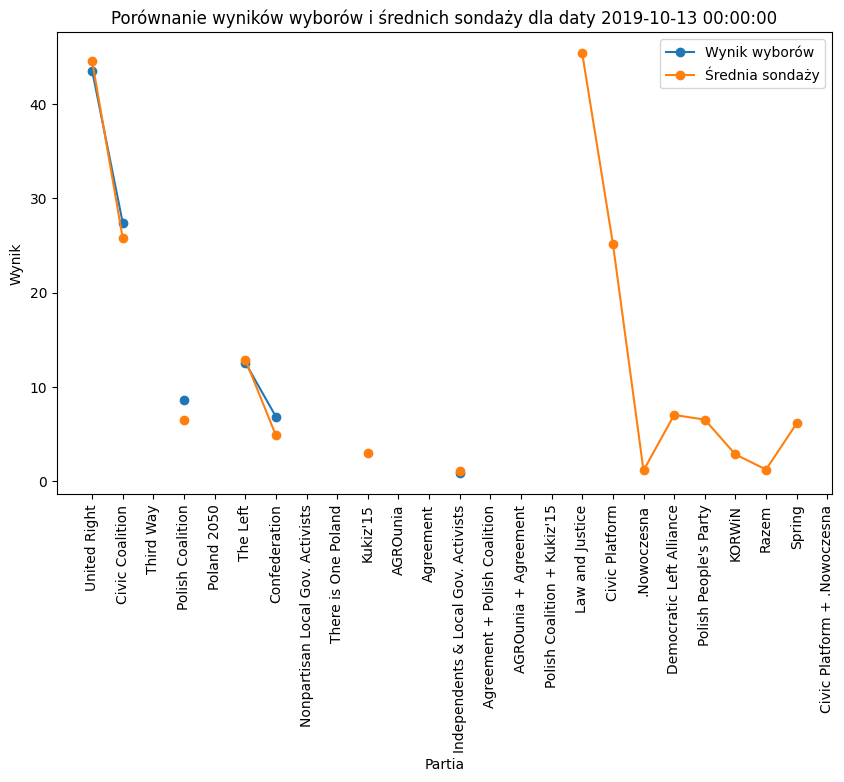

Analiza dla daty: 2023-10-15 00:00:00
   Fieldwork Date                                             partia  \
0      2023-10-15                                       United Right   
1      2023-10-15                                    Civic Coalition   
2      2023-10-15                                          Third Way   
3      2023-10-15                                   Polish Coalition   
4      2023-10-15                                        Poland 2050   
5      2023-10-15                                           The Left   
6      2023-10-15                                      Confederation   
7      2023-10-15                   Nonpartisan Local Gov. Activists   
8      2023-10-15                                There is One Poland   
9      2023-10-15                                           Kukiz'15   
10     2023-10-15                                           AGROunia   
11     2023-10-15                                          Agreement   
12     2023-10-15         

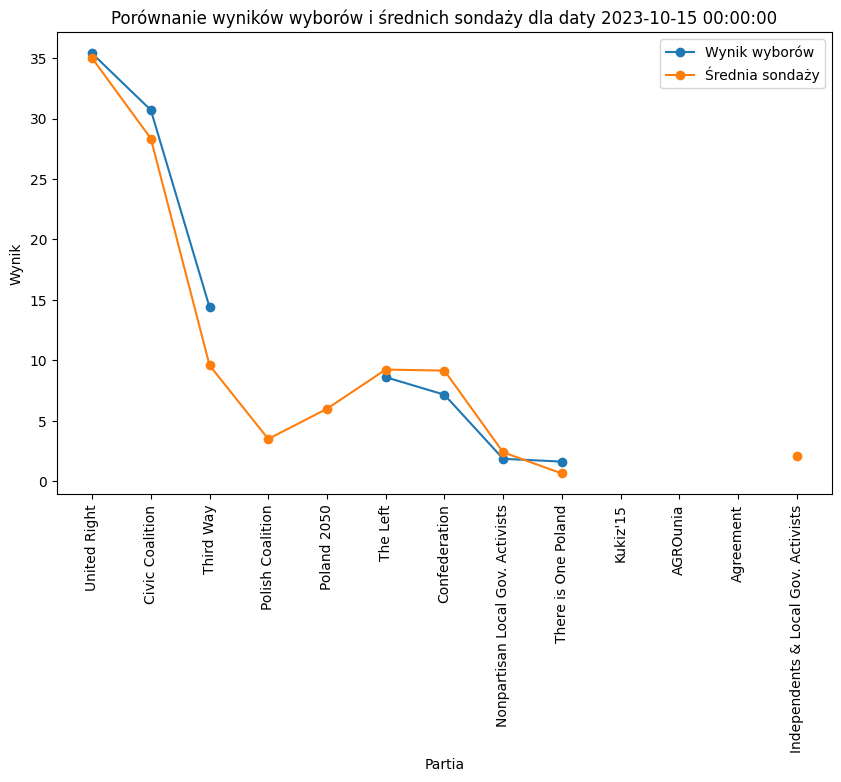

In [82]:
for election_date in election_dates:
    print(f"Analiza dla daty: {election_date}")

    # Wyniki wyborów dla danej daty
    election_results = df_election_results[df_election_results['Fieldwork Date'] == election_date]

    ##TODO
    # Sondaże w okresie 14 dni przed wyborami
    mask = (df_final['Fieldwork Date'] >= election_date - pd.Timedelta(days=40)) & (df_final['Fieldwork Date'] < election_date)
    sondaze_period = df_final[mask]

    # Obliczanie średnich wyników sondaży dla każdej partii
    mean_sondaze = sondaze_period[parties_columns].mean().reset_index()
    mean_sondaze.columns = ['partia', 'średnia_sondaży']

    # Łączenie wyników wyborów i średnich wyników sondaży
    election_results_melted = election_results.melt(id_vars=['Fieldwork Date'], value_vars=parties_columns, var_name='partia', value_name='wynik_wyborów')
    merged_results = pd.merge(election_results_melted, mean_sondaze, on='partia', how='inner')

    # Obliczanie różnic i odchyleń
    merged_results['różnica'] = merged_results['wynik_wyborów'] - merged_results['średnia_sondaży']
    merged_results['odchylenie'] = (merged_results['różnica'] / merged_results['średnia_sondaży']) * 100

    print(merged_results)

    # Test t-studenta
    t_stat, p_val = stats.ttest_ind(merged_results['wynik_wyborów'], merged_results['średnia_sondaży'])
    print(f'T-statystyka: {t_stat}, p-value: {p_val}')

    # Wizualizacja
    plt.figure(figsize=(10, 6))
    plt.plot(merged_results['partia'], merged_results['wynik_wyborów'], label='Wynik wyborów', marker='o')
    plt.plot(merged_results['partia'], merged_results['średnia_sondaży'], label='Średnia sondaży', marker='o')
    plt.title(f'Porównanie wyników wyborów i średnich sondaży dla daty {election_date}')
    plt.xlabel('Partia')
    plt.ylabel('Wynik')
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

### Dla każdej oddzielnie sondażowni

Analiza dla daty: 2019-10-13 00:00:00
    Fieldwork Date                               partia  wynik_wyborów  \
0       2019-10-13                         United Right          43.59   
1       2019-10-13                      Civic Coalition          27.40   
2       2019-10-13                            Third Way            NaN   
3       2019-10-13                     Polish Coalition           8.55   
4       2019-10-13                          Poland 2050            NaN   
..             ...                                  ...            ...   
325     2019-10-13            Congress of the New Right            NaN   
326     2019-10-13                    Solidarity Poland            NaN   
327     2019-10-13  Solidarity Poland + Poland Together            NaN   
328     2019-10-13                   Palikot's Movement            NaN   
329     2019-10-13                      Poland Together            NaN   

    Polling Firm  średnia_sondaży  różnica  odchylenie  
0           CBOS

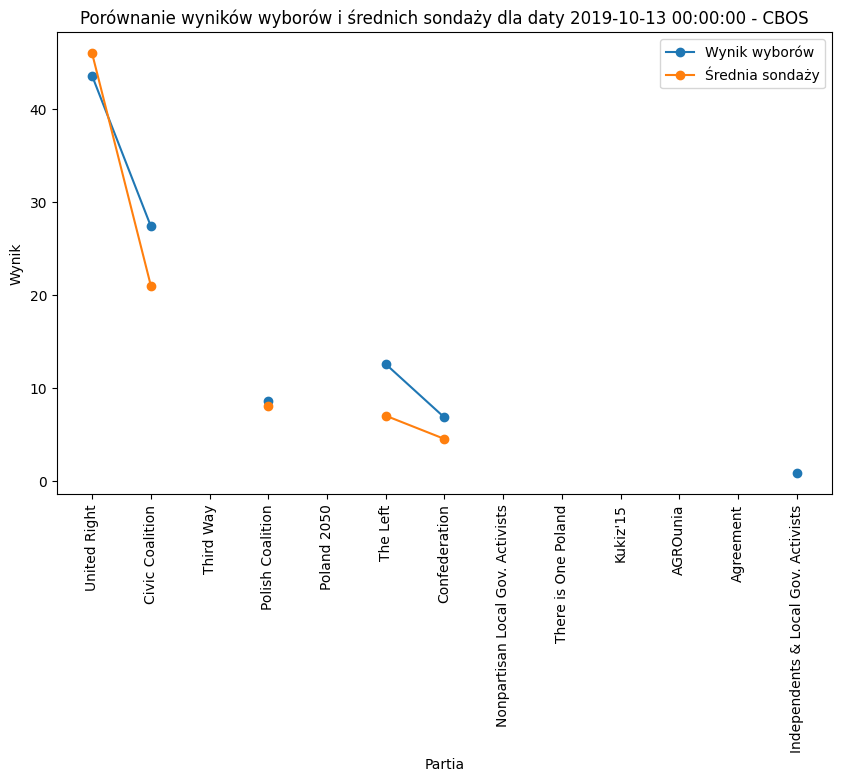

Sondażownia: Dobra Opinia, t-statystyka: nan, p-value: nan


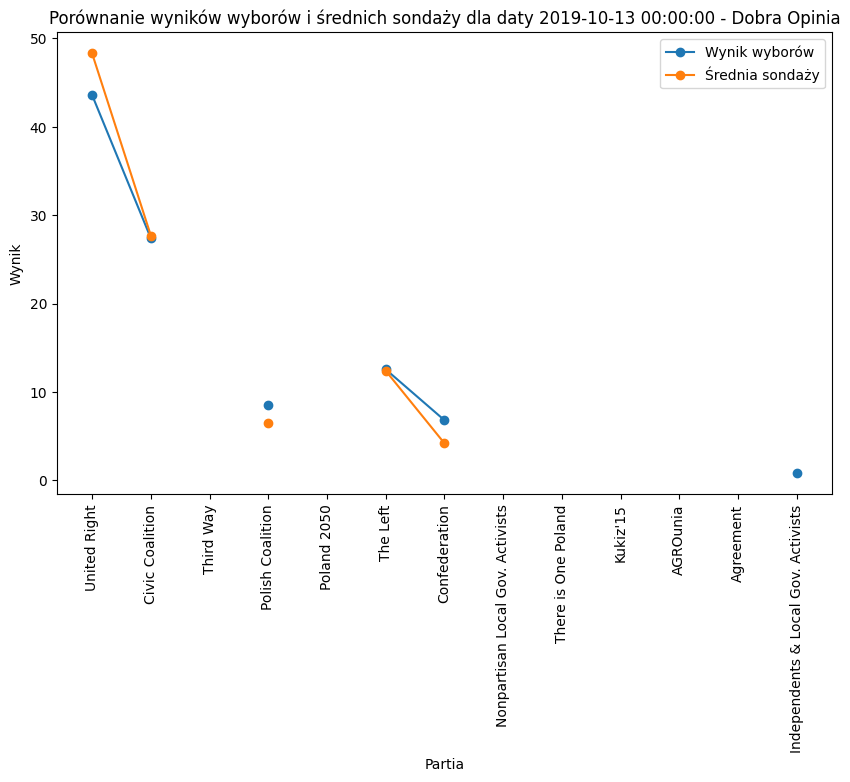

Sondażownia: Estymator, t-statystyka: nan, p-value: nan


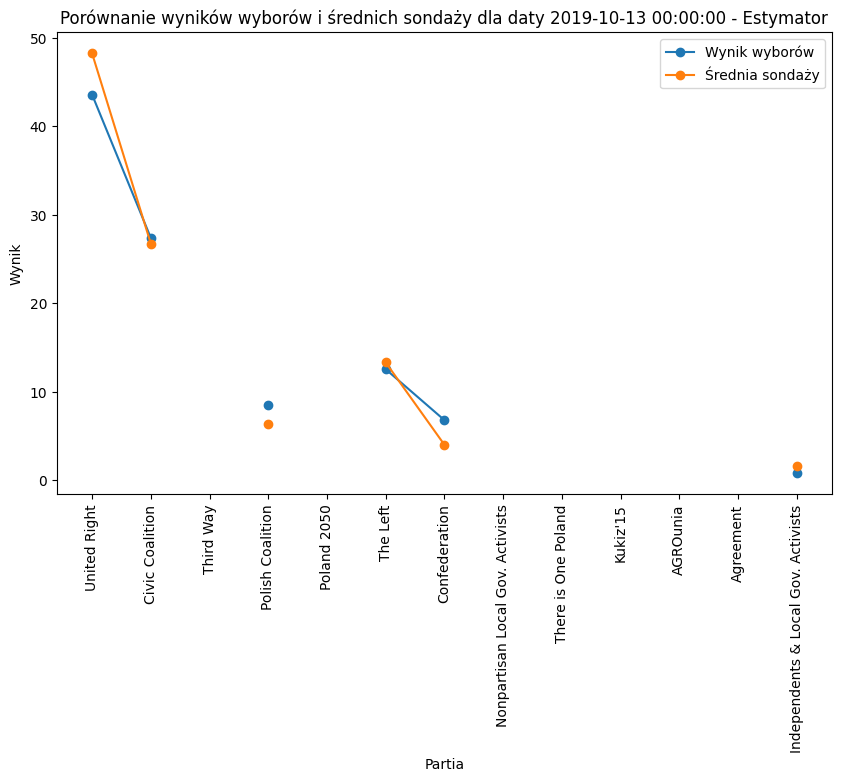

Sondażownia: IBRiS, t-statystyka: nan, p-value: nan


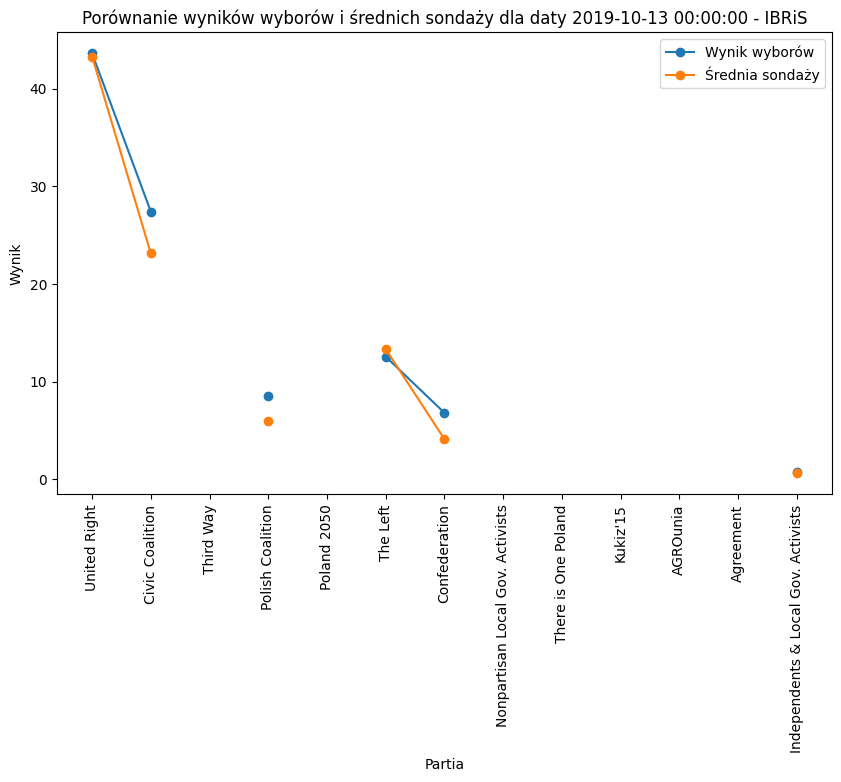

Sondażownia: IBSP, t-statystyka: nan, p-value: nan


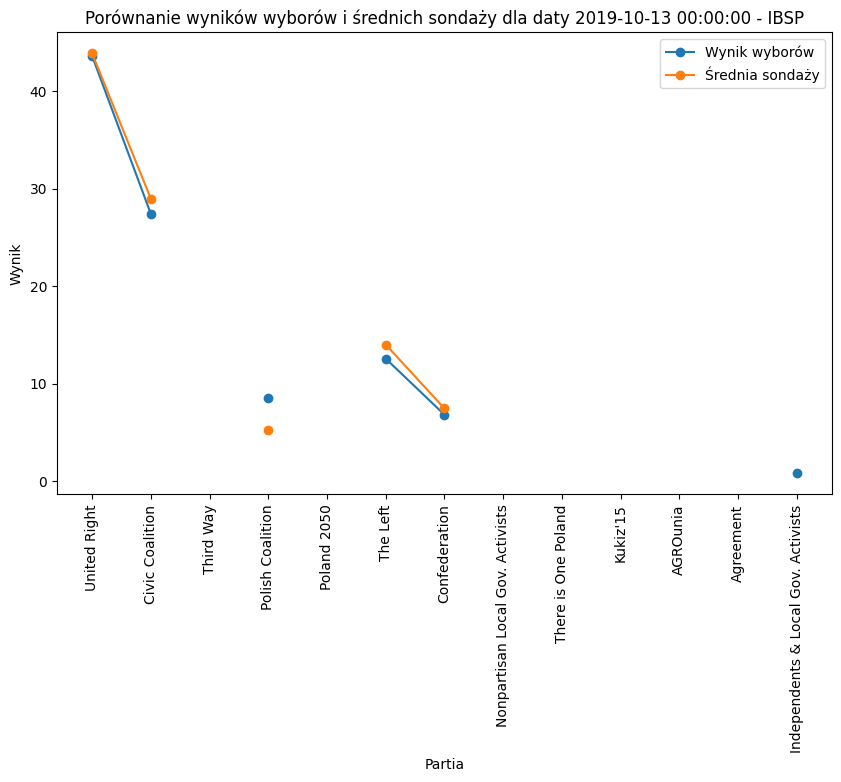

Sondażownia: Indicator, t-statystyka: nan, p-value: nan


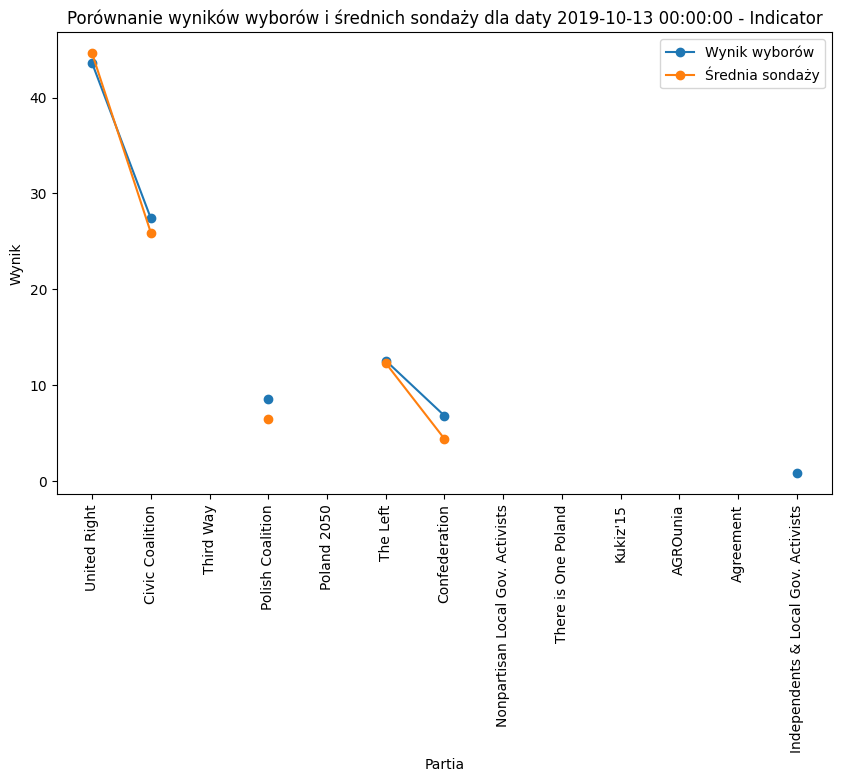

Sondażownia: Kantar Public, t-statystyka: nan, p-value: nan


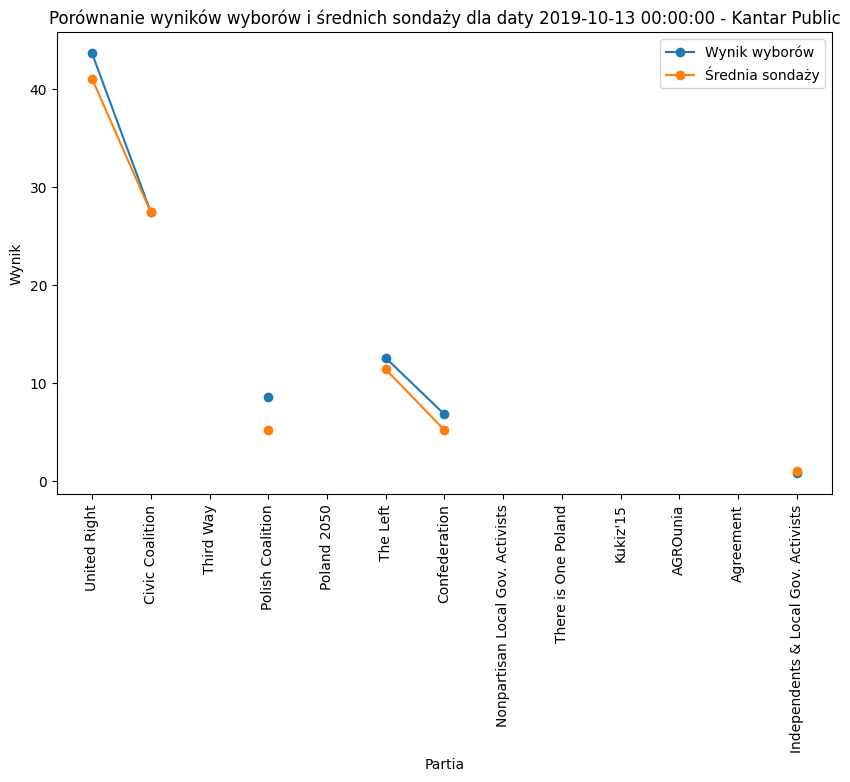

Sondażownia: Pollster, t-statystyka: nan, p-value: nan


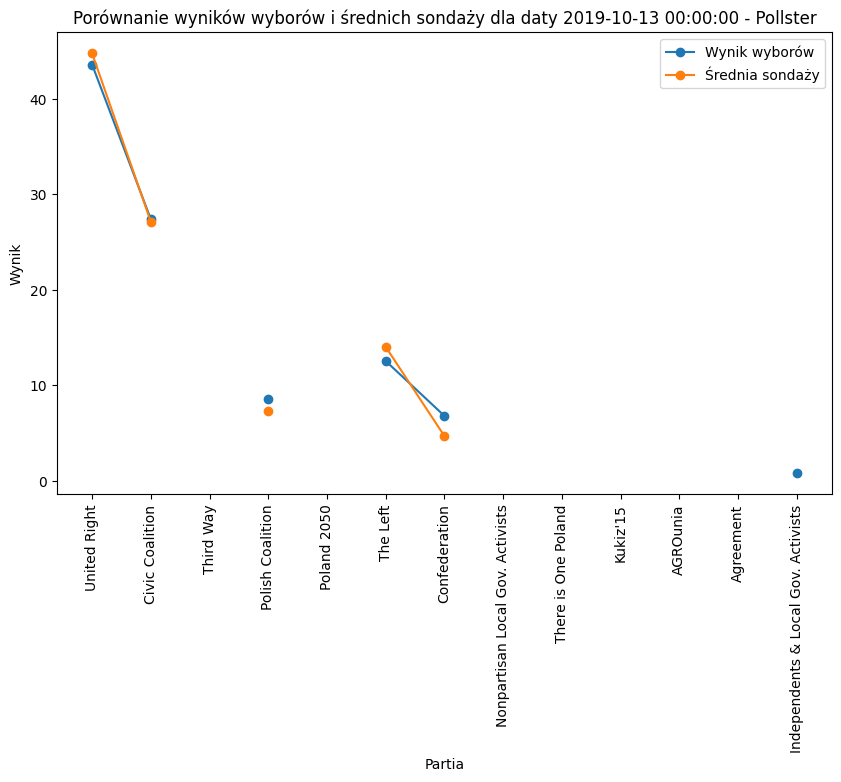

Sondażownia: Social Changes, t-statystyka: nan, p-value: nan


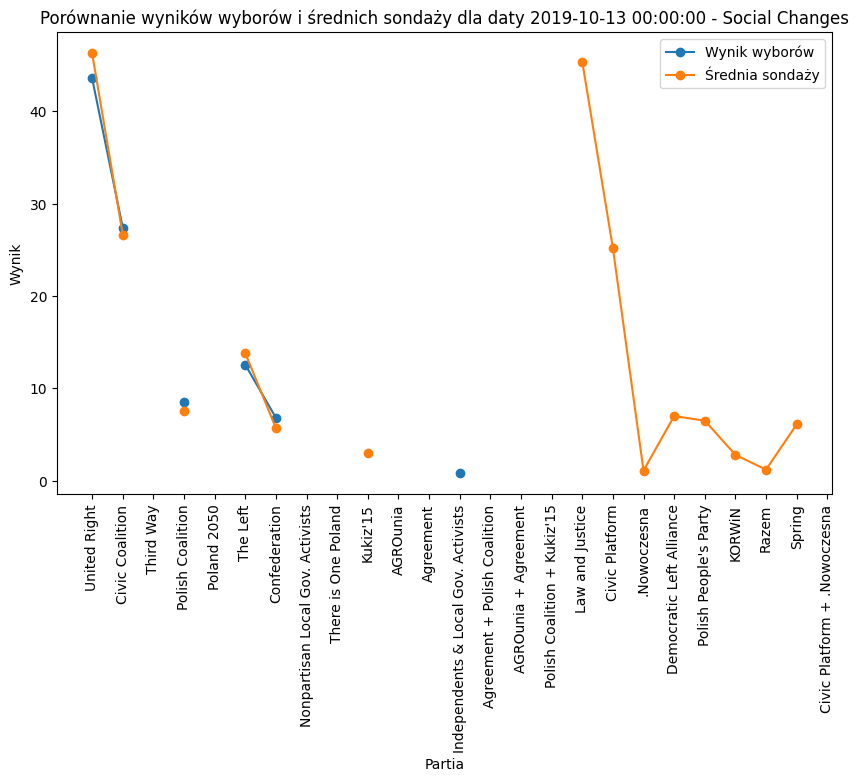

Sondażownia: ewybory.eu, t-statystyka: nan, p-value: nan


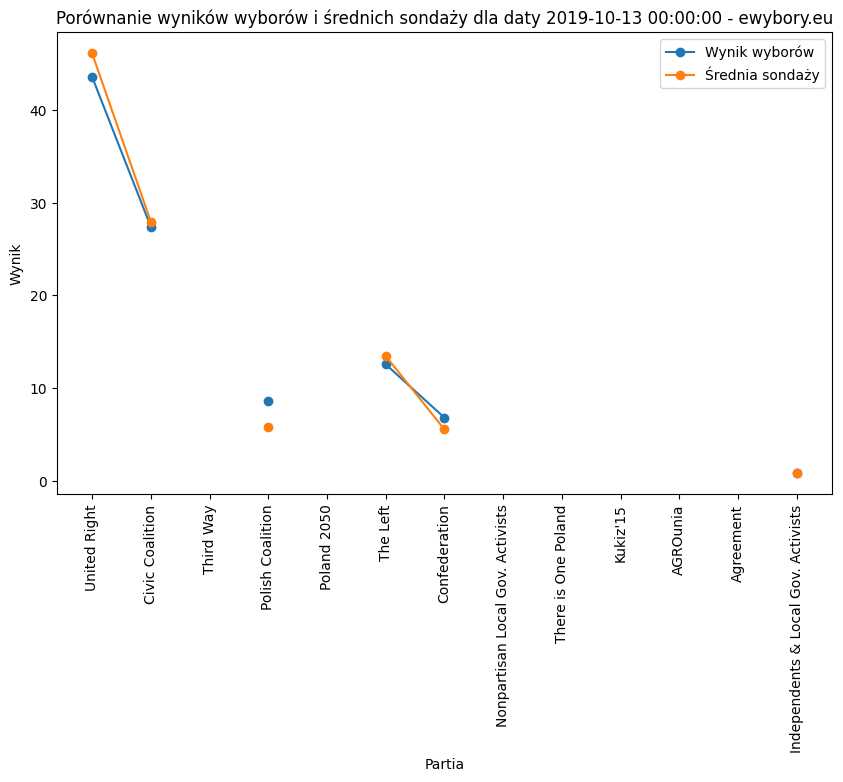

Analiza dla daty: 2023-10-15 00:00:00
    Fieldwork Date                               partia  wynik_wyborów  \
0       2023-10-15                         United Right          35.38   
1       2023-10-15                      Civic Coalition          30.70   
2       2023-10-15                            Third Way          14.40   
3       2023-10-15                     Polish Coalition            NaN   
4       2023-10-15                          Poland 2050            NaN   
..             ...                                  ...            ...   
457     2023-10-15            Congress of the New Right            NaN   
458     2023-10-15                    Solidarity Poland            NaN   
459     2023-10-15  Solidarity Poland + Poland Together            NaN   
460     2023-10-15                   Palikot's Movement            NaN   
461     2023-10-15                      Poland Together            NaN   

    Polling Firm  średnia_sondaży  różnica  odchylenie  
0           CBOS

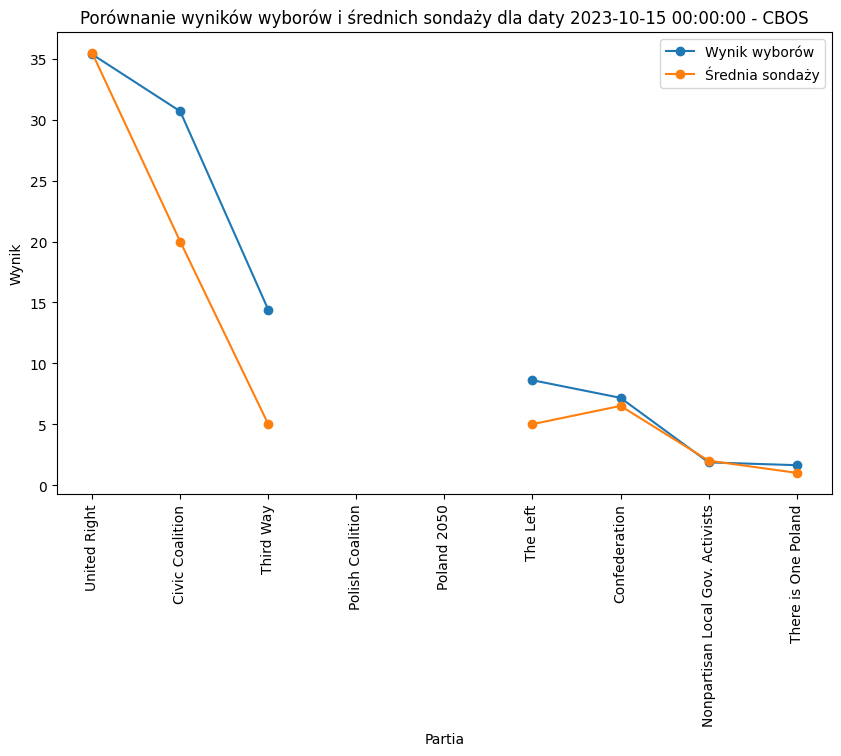

Sondażownia: Estymator, t-statystyka: nan, p-value: nan


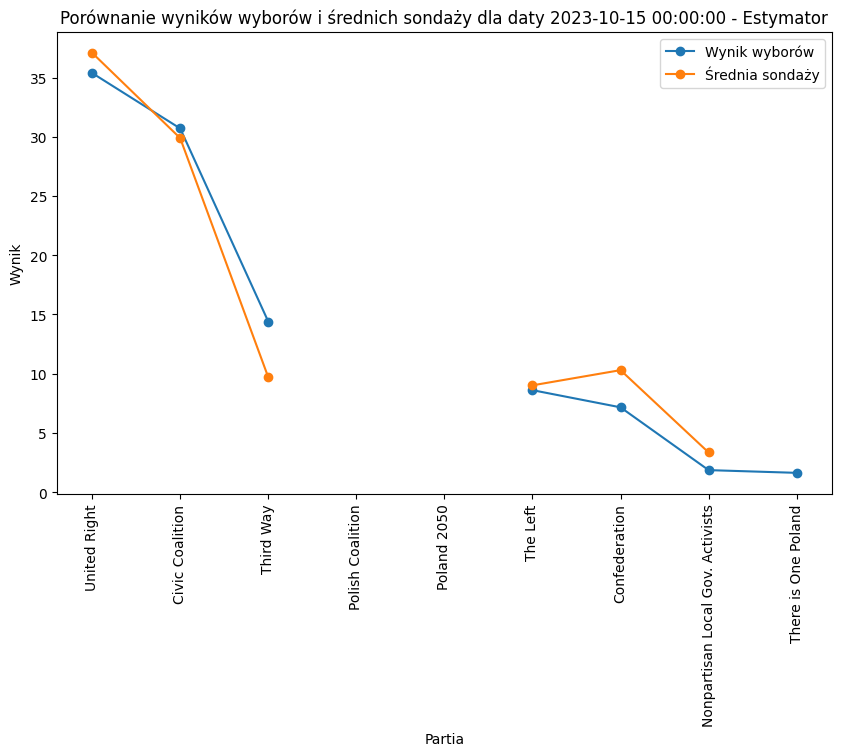

Sondażownia: IBRiS, t-statystyka: nan, p-value: nan


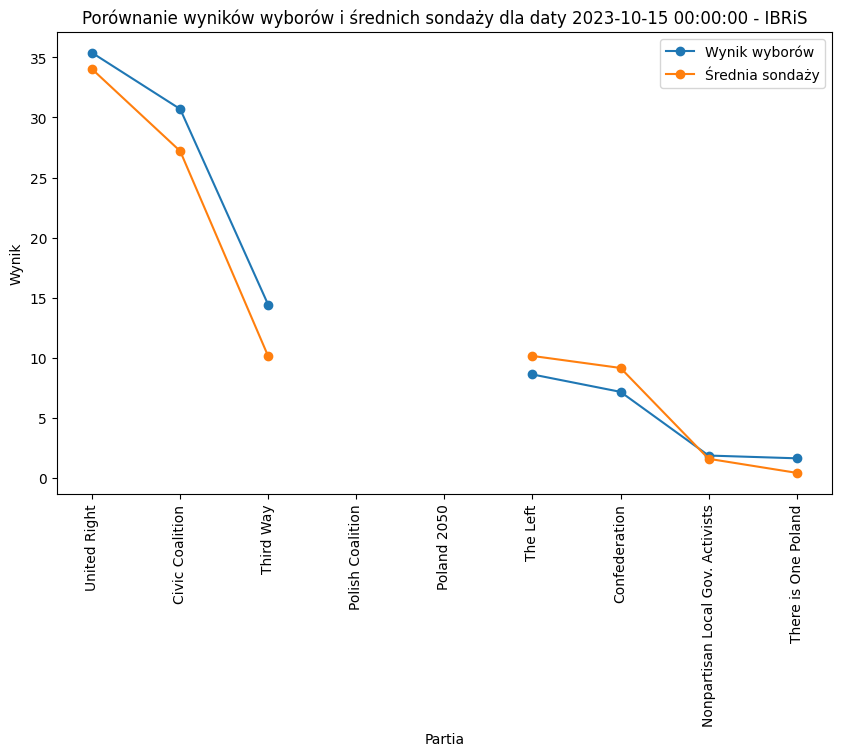

Sondażownia: IBSP, t-statystyka: nan, p-value: nan


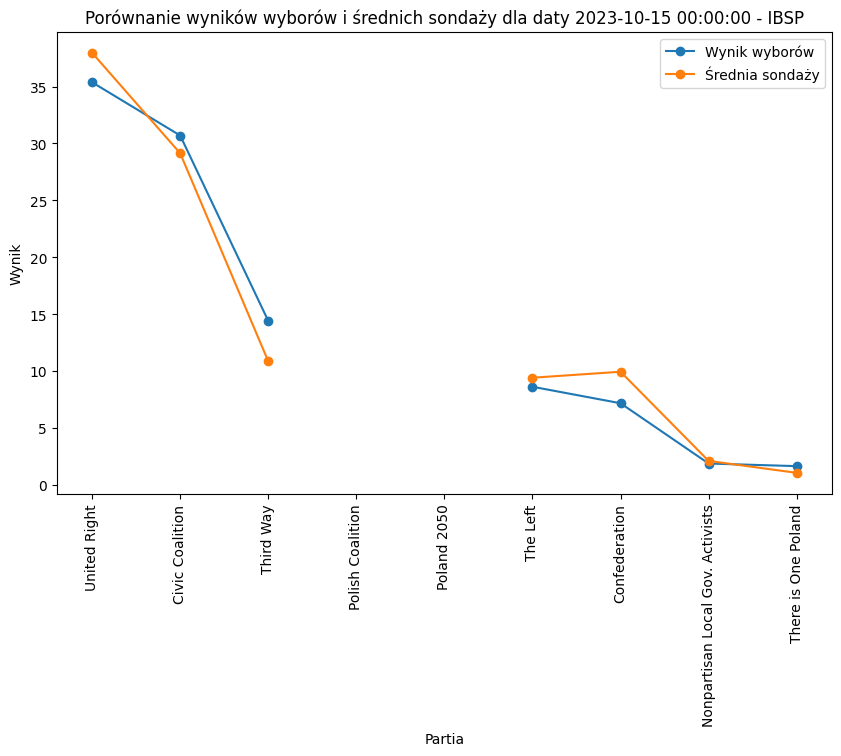

Sondażownia: IPC, t-statystyka: nan, p-value: nan


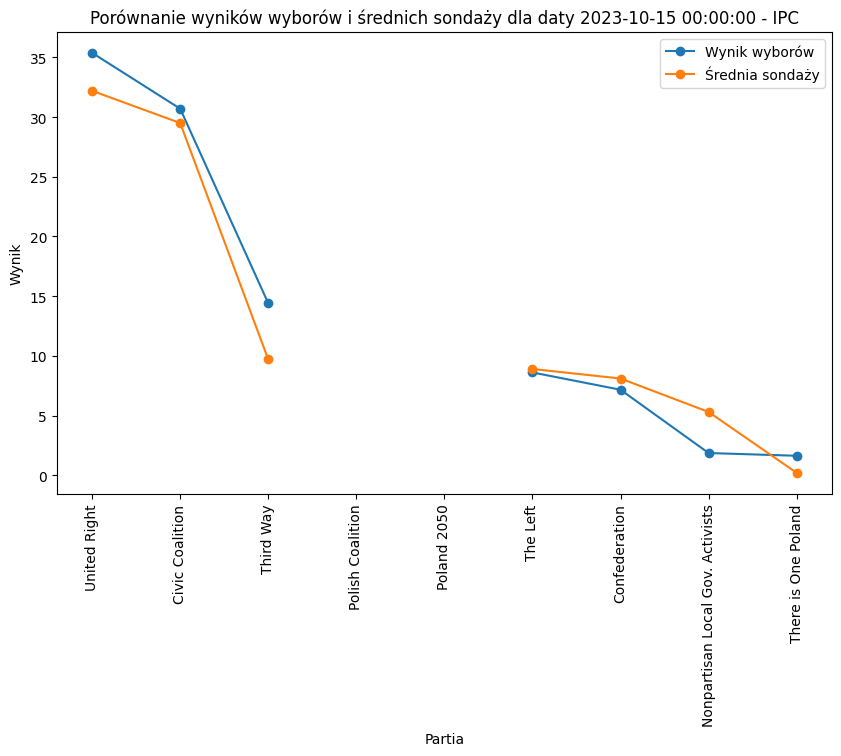

Sondażownia: IPSOS, t-statystyka: nan, p-value: nan


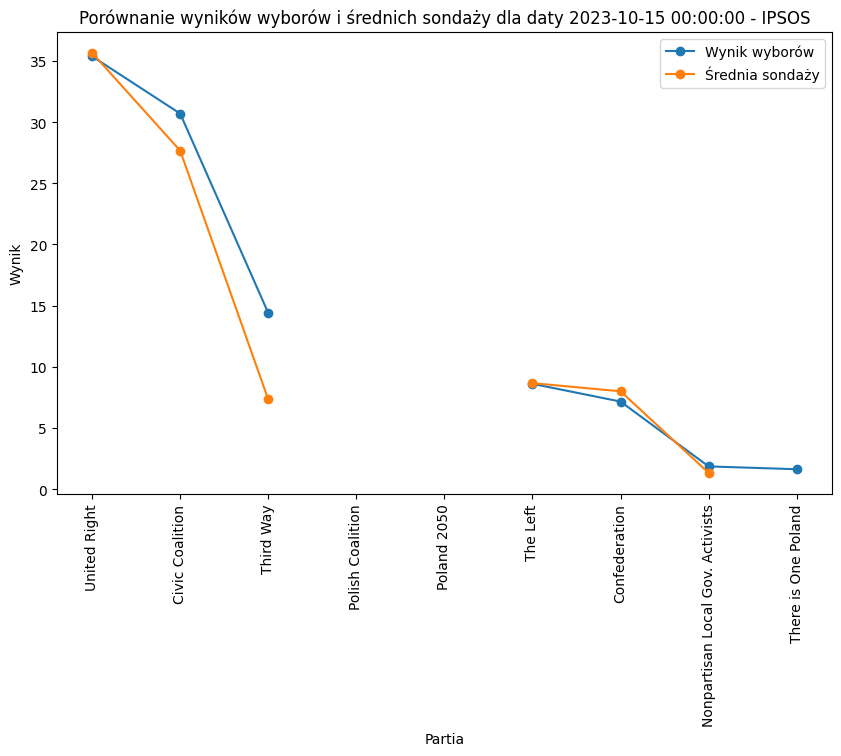

Sondażownia: Kantar, t-statystyka: nan, p-value: nan


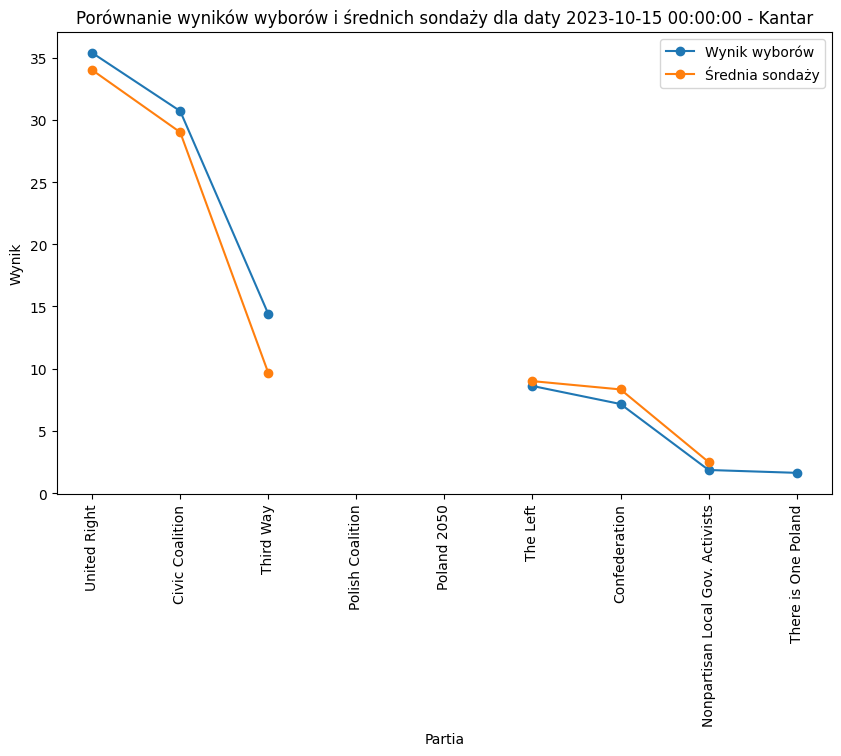

Sondażownia: Opinia24, t-statystyka: nan, p-value: nan


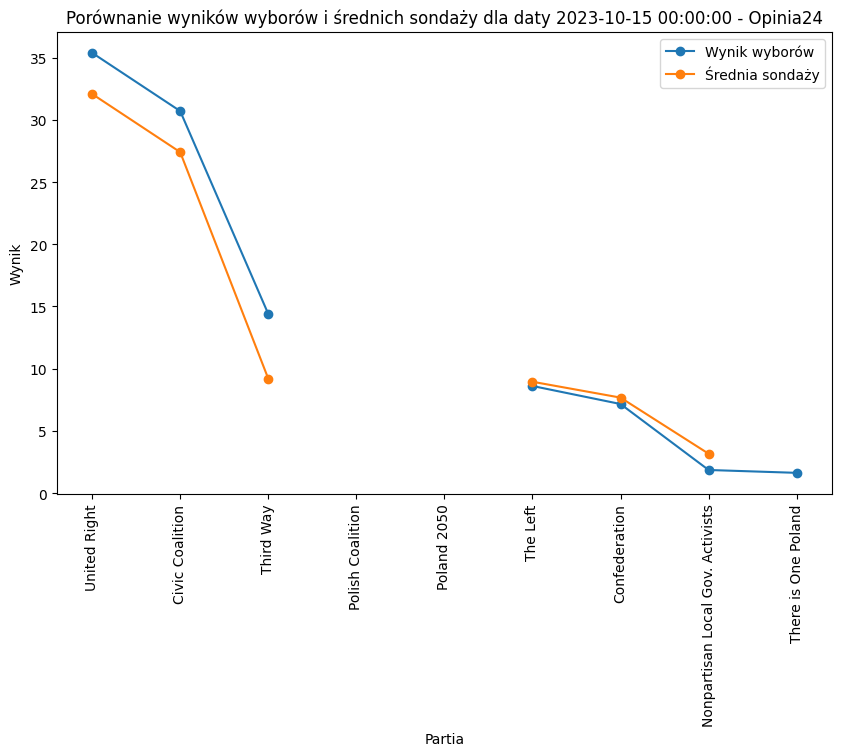

Sondażownia: PGB Opinium, t-statystyka: nan, p-value: nan


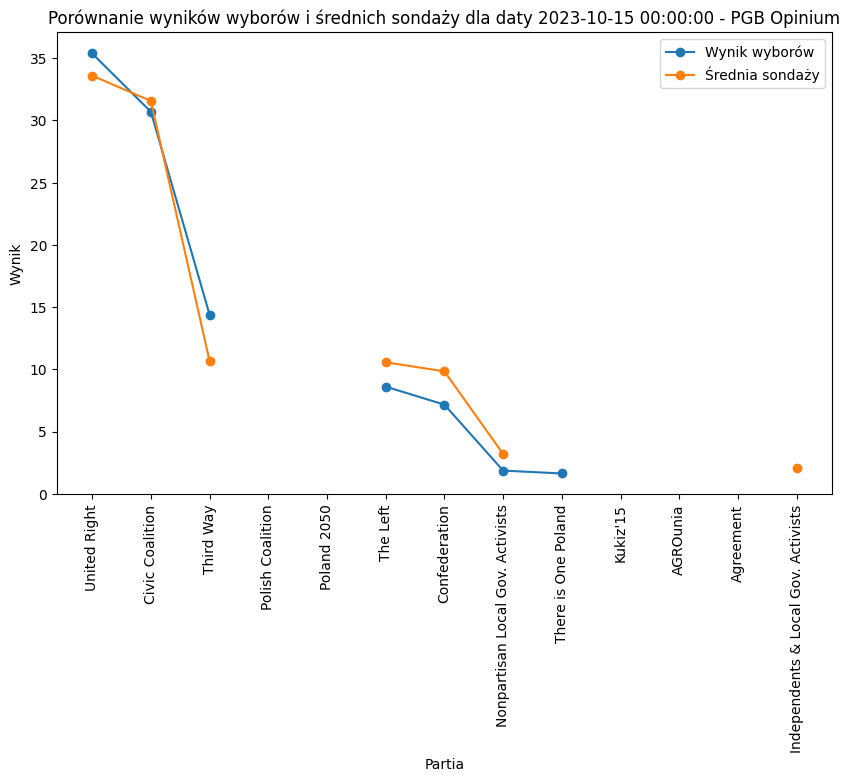

Sondażownia: Pollster, t-statystyka: nan, p-value: nan


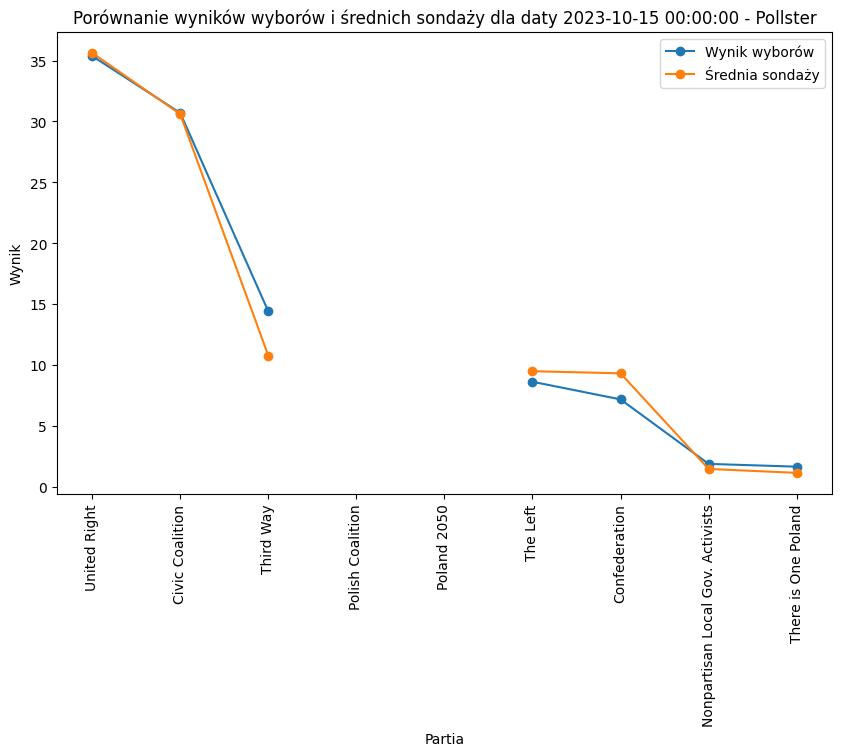

Sondażownia: Research Partner, t-statystyka: nan, p-value: nan


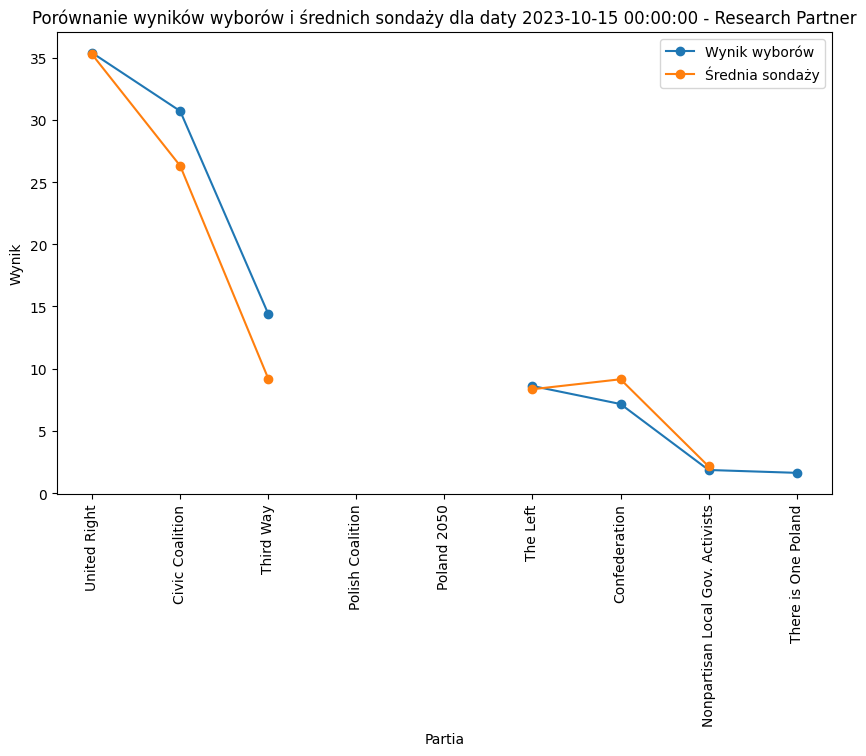

Sondażownia: Social Changes, t-statystyka: nan, p-value: nan


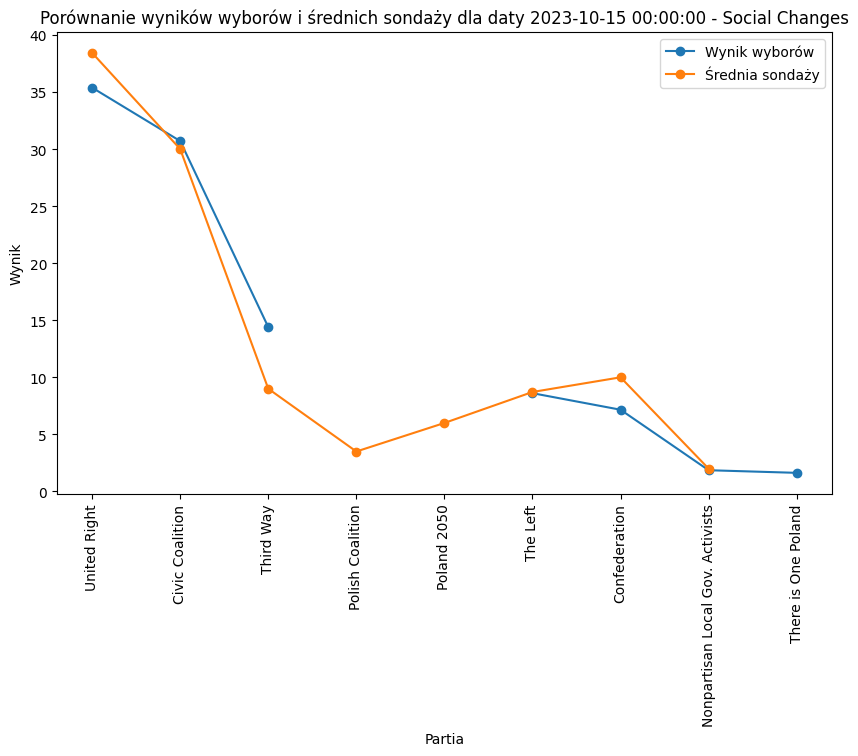

Sondażownia: United Surveys, t-statystyka: nan, p-value: nan


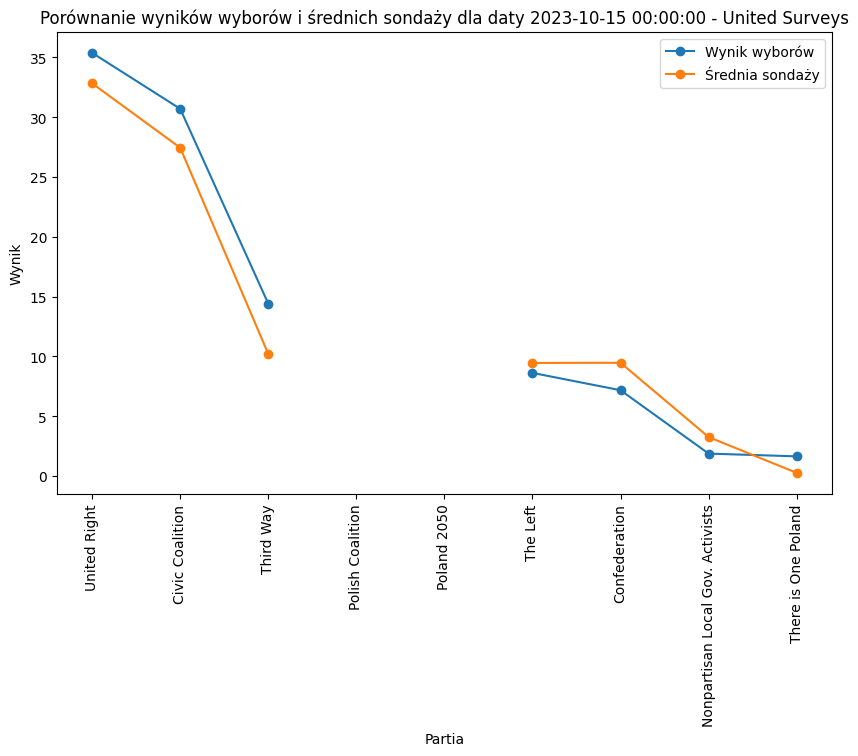

Sondażownia: ewybory.eu, t-statystyka: nan, p-value: nan


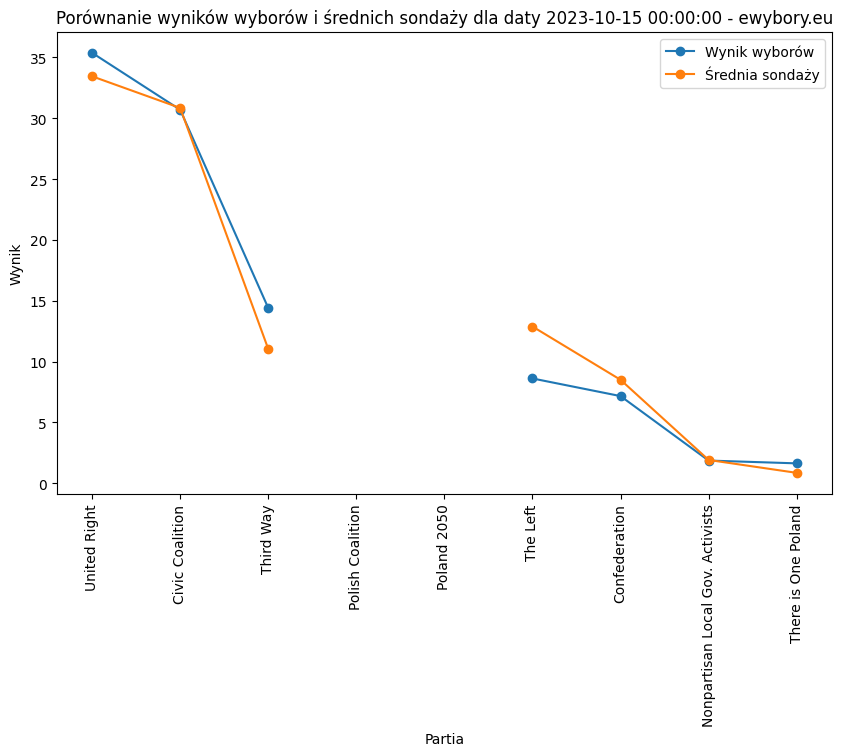

In [83]:
# Analiza dla każdej daty wyborów
for election_date in election_dates:
    print(f"Analiza dla daty: {election_date}")

    # Wyniki wyborów dla danej daty
    election_results = df_election_results[df_election_results['Fieldwork Date'] == election_date]

    ## TODO 
    # Sondaże w okresie X dni przed wyborami
    mask = (df_final['Fieldwork Date'] >= election_date - pd.Timedelta(days=40)) & (df_final['Fieldwork Date'] < election_date)
    sondaze_period = df_final[mask]

    # Obliczanie średnich wyników sondaży dla każdej sondażowni i partii
    mean_sondaze = sondaze_period.groupby(['Polling Firm'])[parties_columns].mean().reset_index()

    # Łączenie wyników wyborów i średnich wyników sondaży
    election_results_melted = election_results.melt(id_vars=['Fieldwork Date'], value_vars=parties_columns, var_name='partia', value_name='wynik_wyborów')
    
    results_list = []
    for polling_firm in mean_sondaze['Polling Firm'].unique():
        polling_firm_data = mean_sondaze[mean_sondaze['Polling Firm'] == polling_firm]
        polling_firm_data_melted = polling_firm_data.melt(id_vars=['Polling Firm'], value_vars=parties_columns, var_name='partia', value_name='średnia_sondaży')
        merged_results = pd.merge(election_results_melted, polling_firm_data_melted, on='partia', how='inner')
        merged_results['Polling Firm'] = polling_firm
        merged_results['różnica'] = merged_results['wynik_wyborów'] - merged_results['średnia_sondaży']
        merged_results['odchylenie'] = (merged_results['różnica'] / merged_results['średnia_sondaży']) * 100
        results_list.append(merged_results)
    
    all_results = pd.concat(results_list, ignore_index=True)
    print(all_results)

    # Test t-studenta dla każdej sondażowni
    for polling_firm in all_results['Polling Firm'].unique():
        firm_results = all_results[all_results['Polling Firm'] == polling_firm]
        t_stat, p_val = stats.ttest_ind(firm_results['wynik_wyborów'], firm_results['średnia_sondaży'])
        print(f'Sondażownia: {polling_firm}, t-statystyka: {t_stat}, p-value: {p_val}')

        # Wizualizacja dla każdej sondażowni
        plt.figure(figsize=(10, 6))
        plt.plot(firm_results['partia'], firm_results['wynik_wyborów'], label='Wynik wyborów', marker='o')
        plt.plot(firm_results['partia'], firm_results['średnia_sondaży'], label='Średnia sondaży', marker='o')
        plt.title(f'Porównanie wyników wyborów i średnich sondaży dla daty {election_date} - {polling_firm}')
        plt.xlabel('Partia')
        plt.ylabel('Wynik')
        plt.xticks(rotation=90)
        plt.legend()
        plt.show()

## Średnie tabela

In [84]:
df_election_results

Polling Firm Fieldwork Date  Sample Size  Others  Don't know  \
881                 Results     2019-10-13          NaN     NaN        0.31   
0    Parliamentary election     2023-10-15   21596674.0    0.22        0.00   

      Lead  United Right  Civic Coalition  Third Way  Polish Coalition  ...  \
881  16.19         43.59             27.4        NaN              8.55  ...   
0     4.68         35.38             30.7       14.4               NaN  ...   

     Spring  Civic Platform + .Nowoczesna  \
881     NaN                           NaN   
0       NaN                           NaN   

     Civic Platform + .Nowoczesna + Democratic Left Alliance + Polish People's Party  \
881                                                NaN                                 
0                                                  NaN                                 

     Your Movement  Democratic Left Alliance + Your Movement  \
881            NaN                                       NaN   
0              NaN                                       NaN   

     Congress of the New Right  Solidarity Poland  \
881                        NaN                NaN   
0                          NaN                NaN   

     Solidarity Poland + Poland Together  Palikot's Movement  Poland Together  
881                                  NaN                 NaN              NaN  
0                                    NaN                 NaN              NaN  

[2 rows x 39 columns]

In [85]:
df_group_error

Polling Firm Fieldwork Date  Sample Size  Others  Don't know  \
12              ewybory.eu     2019-09-27          NaN     NaN        0.38   
11            Dobra Opinia     2019-10-04       8000.0     NaN        0.90   
5                Indicator     2019-10-10       1000.0     NaN        5.10   
6                Estymator     2019-10-10       1007.0     NaN        0.70   
7                 Pollster     2019-10-10       1059.0     NaN        1.40   
8            Kantar Public     2019-10-10       1503.0     NaN        8.00   
9           Social Changes     2019-10-10       1010.0     NaN        0.00   
10                    CBOS     2019-10-10       1013.0     NaN       12.00   
3                    IBRiS     2019-10-11       1100.0     NaN       11.10   
4                     IBSP     2019-10-11       1002.0     NaN        0.30   
0   Parliamentary election     2019-10-13          NaN     NaN        1.00   
1                  Results     2019-10-13          NaN     NaN        0.31   
2                    IPSOS     2019-10-13          NaN     NaN        1.10   
27                     IPC     2023-10-08       1067.0     NaN        6.10   
28              ewybory.eu     2023-10-08      10007.0    0.53        0.00   
26        Research Partner     2023-10-09       1084.0    0.90        9.10   
24          Social Changes     2023-10-10       1094.0    1.00        7.00   
25          United Surveys     2023-10-10       1000.0     NaN        7.80   
22               Estymator     2023-10-11       1095.0    1.20        0.00   
23                    CBOS     2023-10-11       1110.0     NaN       17.00   
18             PGB Opinium     2023-10-12       1100.0    1.10        0.00   
19                Pollster     2023-10-12          NaN    0.51        0.00   
20                   IBRiS     2023-10-12       1243.0    0.50        7.50   
21                  Kantar     2023-10-12       1702.0    1.00        8.00   
16                Opinia24     2023-10-13       1500.0    0.60        8.10   
17                    IBSP     2023-10-13       1100.0    0.20        0.00   
15                   IPSOS     2023-10-15      90000.0    0.20        0.00   
13  Parliamentary election     2023-10-15   21596674.0    0.22        0.00   
14                     OGB     2023-10-15          NaN    0.20        0.00   

     Lead  United Right  Civic Coalition  Third Way  Polish Coalition  ...  \
12  18.15         46.12            27.97        NaN              5.75  ...   
11  20.60         48.30            27.70        NaN              6.50  ...   
5   19.20         44.90            25.70        NaN              6.90  ...   
6   22.90         48.20            25.30        NaN              6.80  ...   
7   18.20         45.40            27.20        NaN              7.00  ...   
8   14.00         40.00            26.00        NaN              7.00  ...   
9   22.90         47.30            24.40        NaN              6.10  ...   
10  27.00         46.00            19.00        NaN              8.00  ...   
3   19.70         42.00            22.30        NaN              5.90  ...   
4   15.10         42.10            27.00        NaN              6.30  ...   
0   16.20         43.60            27.40        NaN              8.60  ...   
1   16.19         43.59            27.40        NaN              8.55  ...   
2   16.20         43.60            27.40        NaN              9.60  ...   
27   2.70         32.20            29.50       9.70               NaN  ...   
28   2.60         33.45            30.85      11.03               NaN  ...   
26   8.60         35.10            26.50       8.30               NaN  ...   
24   8.00         34.00            26.00      11.00               NaN  ...   
25   5.70         33.80            28.10       9.40               NaN  ...   
22   6.80         36.70            29.90      10.10               NaN  ...   
23  13.00         35.00            22.00       6.00               NaN  ...   
18   2.60         33.20            

In [86]:
empty_columns = df_group_error.isna().all()

print("Columns with only empty values:", empty_columns[empty_columns].index.tolist())

Columns with only empty values: ['Poland 2050', "Kukiz'15", 'AGROunia', 'Agreement', 'Agreement + Polish Coalition', 'AGROunia + Agreement', "Polish Coalition + Kukiz'15", 'Law and Justice', 'Civic Platform', '.Nowoczesna', 'Democratic Left Alliance', "Polish People's Party", 'KORWiN', 'Razem', 'Spring', 'Civic Platform + .Nowoczesna', "Civic Platform + .Nowoczesna + Democratic Left Alliance + Polish People's Party", 'Your Movement', 'Democratic Left Alliance + Your Movement', 'Congress of the New Right', 'Solidarity Poland', 'Solidarity Poland + Poland Together', "Palikot's Movement", 'Poland Together']


In [87]:
df_cleaned = df_group_error.drop(columns=empty_columns[empty_columns].index)

df_cleaned

Polling Firm Fieldwork Date  Sample Size  Others  Don't know  \
12              ewybory.eu     2019-09-27          NaN     NaN        0.38   
11            Dobra Opinia     2019-10-04       8000.0     NaN        0.90   
5                Indicator     2019-10-10       1000.0     NaN        5.10   
6                Estymator     2019-10-10       1007.0     NaN        0.70   
7                 Pollster     2019-10-10       1059.0     NaN        1.40   
8            Kantar Public     2019-10-10       1503.0     NaN        8.00   
9           Social Changes     2019-10-10       1010.0     NaN        0.00   
10                    CBOS     2019-10-10       1013.0     NaN       12.00   
3                    IBRiS     2019-10-11       1100.0     NaN       11.10   
4                     IBSP     2019-10-11       1002.0     NaN        0.30   
0   Parliamentary election     2019-10-13          NaN     NaN        1.00   
1                  Results     2019-10-13          NaN     NaN        0.31   
2                    IPSOS     2019-10-13          NaN     NaN        1.10   
27                     IPC     2023-10-08       1067.0     NaN        6.10   
28              ewybory.eu     2023-10-08      10007.0    0.53        0.00   
26        Research Partner     2023-10-09       1084.0    0.90        9.10   
24          Social Changes     2023-10-10       1094.0    1.00        7.00   
25          United Surveys     2023-10-10       1000.0     NaN        7.80   
22               Estymator     2023-10-11       1095.0    1.20        0.00   
23                    CBOS     2023-10-11       1110.0     NaN       17.00   
18             PGB Opinium     2023-10-12       1100.0    1.10        0.00   
19                Pollster     2023-10-12          NaN    0.51        0.00   
20                   IBRiS     2023-10-12       1243.0    0.50        7.50   
21                  Kantar     2023-10-12       1702.0    1.00        8.00   
16                Opinia24     2023-10-13       1500.0    0.60        8.10   
17                    IBSP     2023-10-13       1100.0    0.20        0.00   
15                   IPSOS     2023-10-15      90000.0    0.20        0.00   
13  Parliamentary election     2023-10-15   21596674.0    0.22        0.00   
14                     OGB     2023-10-15          NaN    0.20        0.00   

     Lead  United Right  Civic Coalition  Third Way  Polish Coalition  \
12  18.15         46.12            27.97        NaN              5.75   
11  20.60         48.30            27.70        NaN              6.50   
5   19.20         44.90            25.70        NaN              6.90   
6   22.90         48.20            25.30        NaN              6.80   
7   18.20         45.40            27.20        NaN              7.00   
8   14.00         40.00            26.00        NaN              7.00   
9   22.90         47.30            24.40        NaN              6.10   
10  27.00         46.00            19.00        NaN              8.00   
3   19.70         42.00            22.30        NaN              5.90   
4   15.10         42.10            27.00        NaN              6.30   
0   16.20         43.60            27.40        NaN              8.60   
1   16.19         43.59            27.40        NaN              8.55   
2   16.20         43.60            27.40        NaN              9.60   
27   2.70         32.20            29.50       9.70               NaN   
28   2.60         33.45            30.85      11.03               NaN   
26   8.60         35.10            26.50       8.30               NaN   
24   8.00         34.00            26.00      11.00               NaN   
25   5.70         33.80            28.10       9.40               NaN   
22   6.80         36.70            29.90      10.10               NaN   
23  13.00         35.00            22.00       6.00               NaN   
18   2.60         33.20            30.60      11.90               NaN   
19   4.43         35.81            31.38      10.71               N

In [88]:
df_election_results['Fieldwork Date'] = pd.to_datetime(df_election_results['Fieldwork Date'])
df_cleaned['Fieldwork Date'] = pd.to_datetime(df_cleaned['Fieldwork Date'])

# Extract the election dates
election_dates = df_election_results['Fieldwork Date'].unique()

# Remove rows from df_cleaned where the poll date is on the election day
df_cleaned = df_cleaned[~df_cleaned['Fieldwork Date'].isin(election_dates)]

In [89]:
election_dates

<DatetimeArray>
['2019-10-13 00:00:00', '2023-10-15 00:00:00']
Length: 2, dtype: datetime64[ns]

In [90]:
df_cleaned

Polling Firm Fieldwork Date  Sample Size  Others  Don't know   Lead  \
12        ewybory.eu     2019-09-27          NaN     NaN        0.38  18.15   
11      Dobra Opinia     2019-10-04       8000.0     NaN        0.90  20.60   
5          Indicator     2019-10-10       1000.0     NaN        5.10  19.20   
6          Estymator     2019-10-10       1007.0     NaN        0.70  22.90   
7           Pollster     2019-10-10       1059.0     NaN        1.40  18.20   
8      Kantar Public     2019-10-10       1503.0     NaN        8.00  14.00   
9     Social Changes     2019-10-10       1010.0     NaN        0.00  22.90   
10              CBOS     2019-10-10       1013.0     NaN       12.00  27.00   
3              IBRiS     2019-10-11       1100.0     NaN       11.10  19.70   
4               IBSP     2019-10-11       1002.0     NaN        0.30  15.10   
27               IPC     2023-10-08       1067.0     NaN        6.10   2.70   
28        ewybory.eu     2023-10-08      10007.0    0.53        0.00   2.60   
26  Research Partner     2023-10-09       1084.0    0.90        9.10   8.60   
24    Social Changes     2023-10-10       1094.0    1.00        7.00   8.00   
25    United Surveys     2023-10-10       1000.0     NaN        7.80   5.70   
22         Estymator     2023-10-11       1095.0    1.20        0.00   6.80   
23              CBOS     2023-10-11       1110.0     NaN       17.00  13.00   
18       PGB Opinium     2023-10-12       1100.0    1.10        0.00   2.60   
19          Pollster     2023-10-12          NaN    0.51        0.00   4.43   
20             IBRiS     2023-10-12       1243.0    0.50        7.50   6.90   
21            Kantar     2023-10-12       1702.0    1.00        8.00   5.00   
16          Opinia24     2023-10-13       1500.0    0.60        8.10   4.50   
17              IBSP     2023-10-13       1100.0    0.20        0.00   9.59   

    United Right  Civic Coalition  Third Way  Polish Coalition  The Left  \
12         46.12            27.97        NaN              5.75     13.46   
11         48.30            27.70        NaN              6.50     12.40   
5          44.90            25.70        NaN              6.90     12.70   
6          48.20            25.30        NaN              6.80     14.10   
7          45.40            27.20        NaN              7.00     14.30   
8          40.00            26.00        NaN              7.00     12.00   
9          47.30            24.40        NaN              6.10     16.20   
10         46.00            19.00        NaN              8.00      9.00   
3          42.00            22.30        NaN              5.90     14.00   
4          42.10            27.00        NaN              6.30     15.70   
27         32.20            29.50       9.70               NaN      8.90   
28         33.45            30.85      11.03               NaN     12.88   
26         35.10            26.50       8.30               NaN      8.70   
24         34.00            26.00      11.00               NaN      9.00   
25         33.80            28.10       9.40               NaN     10.20   
22         36.70            29.90      10.10               NaN      9.70   
23         35.00            22.00       6.00               NaN      5.00   
18         33.20            30.60      11.90               NaN     11.60   
19         35.81            31.38      10.71               NaN     10.48   
20         33.90            27.00      11.00               NaN      9.70   
21         31.00            26.00      12.00               NaN     11.00   
16         32.00            27.50      11.20               NaN      7.90   
17         37.36            27.77      13.02               NaN     10.33   

    Confederation  Nonpartisan Local Gov. Activists  There is One Poland  \
12           5.54                               NaN                  NaN   
11           4.20                               NaN                  NaN   
5            4.70                               NaN       

In [91]:
df_cleaned['Fieldwork Date'] = pd.to_datetime(df_cleaned['Fieldwork Date'])

df_polls_2023 = df_cleaned[df_cleaned['Fieldwork Date'].dt.year == 2023]
df_polls_2019 = df_cleaned[df_cleaned['Fieldwork Date'].dt.year == 2019]


C:\Users\AKP\AppData\Local\Temp\ipykernel_11948\3469022726.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Fieldwork Date'] = pd.to_datetime(df_cleaned['Fieldwork Date'])


In [92]:
df_polls_2023

Polling Firm Fieldwork Date  Sample Size  Others  Don't know   Lead  \
27               IPC     2023-10-08       1067.0     NaN         6.1   2.70   
28        ewybory.eu     2023-10-08      10007.0    0.53         0.0   2.60   
26  Research Partner     2023-10-09       1084.0    0.90         9.1   8.60   
24    Social Changes     2023-10-10       1094.0    1.00         7.0   8.00   
25    United Surveys     2023-10-10       1000.0     NaN         7.8   5.70   
22         Estymator     2023-10-11       1095.0    1.20         0.0   6.80   
23              CBOS     2023-10-11       1110.0     NaN        17.0  13.00   
18       PGB Opinium     2023-10-12       1100.0    1.10         0.0   2.60   
19          Pollster     2023-10-12          NaN    0.51         0.0   4.43   
20             IBRiS     2023-10-12       1243.0    0.50         7.5   6.90   
21            Kantar     2023-10-12       1702.0    1.00         8.0   5.00   
16          Opinia24     2023-10-13       1500.0    0.60         8.1   4.50   
17              IBSP     2023-10-13       1100.0    0.20         0.0   9.59   

    United Right  Civic Coalition  Third Way  Polish Coalition  The Left  \
27         32.20            29.50       9.70               NaN      8.90   
28         33.45            30.85      11.03               NaN     12.88   
26         35.10            26.50       8.30               NaN      8.70   
24         34.00            26.00      11.00               NaN      9.00   
25         33.80            28.10       9.40               NaN     10.20   
22         36.70            29.90      10.10               NaN      9.70   
23         35.00            22.00       6.00               NaN      5.00   
18         33.20            30.60      11.90               NaN     11.60   
19         35.81            31.38      10.71               NaN     10.48   
20         33.90            27.00      11.00               NaN      9.70   
21         31.00            26.00      12.00               NaN     11.00   
16         32.00            27.50      11.20               NaN      7.90   
17         37.36            27.77      13.02               NaN     10.33   

    Confederation  Nonpartisan Local Gov. Activists  There is One Poland  \
27           8.10                              5.30                 0.20   
28           8.50                              1.91                 0.85   
26           8.80                              2.60                  NaN   
24          10.00                              2.00                  NaN   
25           8.40                              1.90                 0.40   
22           9.70                              2.70                  NaN   
23           6.00                              2.00                  NaN   
18           8.50                              3.10                  NaN   
19           8.72                              1.49                 0.90   
20           8.20                              2.30                  NaN   
21           8.00                              3.00                  NaN   
16           8.80                              3.90                  NaN   
17           8.29                              2.19                 1.04   

    Independents & Local Gov. Activists  
27                                  NaN  
28                                  NaN  
26                                  NaN  
24                                  NaN  
25                                  NaN  
22                                  NaN  
23                                  NaN  
18                                  NaN  
19                                  NaN  
20                                  NaN  
21                                  NaN  
16                                  NaN  
17                                  NaN

In [93]:
df_polls_2019

Polling Firm Fieldwork Date  Sample Size  Others  Don't know   Lead  \
12      ewybory.eu     2019-09-27          NaN     NaN        0.38  18.15   
11    Dobra Opinia     2019-10-04       8000.0     NaN        0.90  20.60   
5        Indicator     2019-10-10       1000.0     NaN        5.10  19.20   
6        Estymator     2019-10-10       1007.0     NaN        0.70  22.90   
7         Pollster     2019-10-10       1059.0     NaN        1.40  18.20   
8    Kantar Public     2019-10-10       1503.0     NaN        8.00  14.00   
9   Social Changes     2019-10-10       1010.0     NaN        0.00  22.90   
10            CBOS     2019-10-10       1013.0     NaN       12.00  27.00   
3            IBRiS     2019-10-11       1100.0     NaN       11.10  19.70   
4             IBSP     2019-10-11       1002.0     NaN        0.30  15.10   

    United Right  Civic Coalition  Third Way  Polish Coalition  The Left  \
12         46.12            27.97        NaN              5.75     13.46   
11         48.30            27.70        NaN              6.50     12.40   
5          44.90            25.70        NaN              6.90     12.70   
6          48.20            25.30        NaN              6.80     14.10   
7          45.40            27.20        NaN              7.00     14.30   
8          40.00            26.00        NaN              7.00     12.00   
9          47.30            24.40        NaN              6.10     16.20   
10         46.00            19.00        NaN              8.00      9.00   
3          42.00            22.30        NaN              5.90     14.00   
4          42.10            27.00        NaN              6.30     15.70   

    Confederation  Nonpartisan Local Gov. Activists  There is One Poland  \
12           5.54                               NaN                  NaN   
11           4.20                               NaN                  NaN   
5            4.70                               NaN                  NaN   
6            4.90                               NaN                  NaN   
7            4.70                               NaN                  NaN   
8            7.00                               NaN                  NaN   
9            6.00                               NaN                  NaN   
10           6.00                               NaN                  NaN   
3            4.70                               NaN                  NaN   
4            8.60                               NaN                  NaN   

    Independents & Local Gov. Activists  
12                                 0.78  
11                                  NaN  
5                                   NaN  
6                                   NaN  
7                                   NaN  
8                                   NaN  
9                                   NaN  
10                                  NaN  
3                                   NaN  
4                                   NaN

In [94]:
empty_columns = df_polls_2019.isna().all()

print("Columns with only empty values:", empty_columns[empty_columns].index.tolist())
df_cleaned_2019 = df_polls_2019.drop(columns=empty_columns[empty_columns].index)

Columns with only empty values: ['Others', 'Third Way', 'Nonpartisan Local Gov. Activists', 'There is One Poland']


In [95]:
empty_columns = df_polls_2023.isna().all()

print("Columns with only empty values:", empty_columns[empty_columns].index.tolist())
df_cleaned_2023 = df_polls_2023.drop(columns=empty_columns[empty_columns].index)

Columns with only empty values: ['Polish Coalition', 'Independents & Local Gov. Activists']


In [96]:
df_election_results_temp_2019 = df_election_results[df_election_results['Fieldwork Date'].dt.year == 2019]
empty_columns = df_election_results_temp_2019.isna().all()

print("Columns with only empty values:", empty_columns[empty_columns].index.tolist())
df_election_results_2019 = df_election_results_temp_2019.drop(columns=empty_columns[empty_columns].index)

Columns with only empty values: ['Sample Size', 'Others', 'Third Way', 'Poland 2050', 'Nonpartisan Local Gov. Activists', 'There is One Poland', "Kukiz'15", 'AGROunia', 'Agreement', 'Agreement + Polish Coalition', 'AGROunia + Agreement', "Polish Coalition + Kukiz'15", 'Law and Justice', 'Civic Platform', '.Nowoczesna', 'Democratic Left Alliance', "Polish People's Party", 'KORWiN', 'Razem', 'Spring', 'Civic Platform + .Nowoczesna', "Civic Platform + .Nowoczesna + Democratic Left Alliance + Polish People's Party", 'Your Movement', 'Democratic Left Alliance + Your Movement', 'Congress of the New Right', 'Solidarity Poland', 'Solidarity Poland + Poland Together', "Palikot's Movement", 'Poland Together']


In [97]:
df_election_results_temp_2023 = df_election_results[df_election_results['Fieldwork Date'].dt.year == 2023]
empty_columns = df_election_results_temp_2023.isna().all()

print("Columns with only empty values:", empty_columns[empty_columns].index.tolist())
df_election_results_2023 = df_election_results_temp_2023.drop(columns=empty_columns[empty_columns].index)

Columns with only empty values: ['Polish Coalition', 'Poland 2050', "Kukiz'15", 'AGROunia', 'Agreement', 'Independents & Local Gov. Activists', 'Agreement + Polish Coalition', 'AGROunia + Agreement', "Polish Coalition + Kukiz'15", 'Law and Justice', 'Civic Platform', '.Nowoczesna', 'Democratic Left Alliance', "Polish People's Party", 'KORWiN', 'Razem', 'Spring', 'Civic Platform + .Nowoczesna', "Civic Platform + .Nowoczesna + Democratic Left Alliance + Polish People's Party", 'Your Movement', 'Democratic Left Alliance + Your Movement', 'Congress of the New Right', 'Solidarity Poland', 'Solidarity Poland + Poland Together', "Palikot's Movement", 'Poland Together']


In [98]:
df_election_results_2019

Polling Firm Fieldwork Date  Don't know   Lead  United Right  \
881      Results     2019-10-13        0.31  16.19         43.59   

     Civic Coalition  Polish Coalition  The Left  Confederation  \
881             27.4              8.55     12.56           6.81   

     Independents & Local Gov. Activists  
881                                 0.78

In [99]:
df_election_results_2023

Polling Firm Fieldwork Date  Sample Size  Others  Don't know  \
0  Parliamentary election     2023-10-15   21596674.0    0.22         0.0   

   Lead  United Right  Civic Coalition  Third Way  The Left  Confederation  \
0  4.68         35.38             30.7       14.4      8.61           7.16   

   Nonpartisan Local Gov. Activists  There is One Poland  
0                              1.86                 1.63

In [100]:
df_cleaned_2019

Polling Firm Fieldwork Date  Sample Size  Don't know   Lead  \
12      ewybory.eu     2019-09-27          NaN        0.38  18.15   
11    Dobra Opinia     2019-10-04       8000.0        0.90  20.60   
5        Indicator     2019-10-10       1000.0        5.10  19.20   
6        Estymator     2019-10-10       1007.0        0.70  22.90   
7         Pollster     2019-10-10       1059.0        1.40  18.20   
8    Kantar Public     2019-10-10       1503.0        8.00  14.00   
9   Social Changes     2019-10-10       1010.0        0.00  22.90   
10            CBOS     2019-10-10       1013.0       12.00  27.00   
3            IBRiS     2019-10-11       1100.0       11.10  19.70   
4             IBSP     2019-10-11       1002.0        0.30  15.10   

    United Right  Civic Coalition  Polish Coalition  The Left  Confederation  \
12         46.12            27.97              5.75     13.46           5.54   
11         48.30            27.70              6.50     12.40           4.20   
5          44.90            25.70              6.90     12.70           4.70   
6          48.20            25.30              6.80     14.10           4.90   
7          45.40            27.20              7.00     14.30           4.70   
8          40.00            26.00              7.00     12.00           7.00   
9          47.30            24.40              6.10     16.20           6.00   
10         46.00            19.00              8.00      9.00           6.00   
3          42.00            22.30              5.90     14.00           4.70   
4          42.10            27.00              6.30     15.70           8.60   

    Independents & Local Gov. Activists  
12                                 0.78  
11                                  NaN  
5                                   NaN  
6                                   NaN  
7                                   NaN  
8                                   NaN  
9                                   NaN  
10                                  NaN  
3                                   NaN  
4                                   NaN

In [101]:
df_cleaned_2023

Polling Firm Fieldwork Date  Sample Size  Others  Don't know   Lead  \
27               IPC     2023-10-08       1067.0     NaN         6.1   2.70   
28        ewybory.eu     2023-10-08      10007.0    0.53         0.0   2.60   
26  Research Partner     2023-10-09       1084.0    0.90         9.1   8.60   
24    Social Changes     2023-10-10       1094.0    1.00         7.0   8.00   
25    United Surveys     2023-10-10       1000.0     NaN         7.8   5.70   
22         Estymator     2023-10-11       1095.0    1.20         0.0   6.80   
23              CBOS     2023-10-11       1110.0     NaN        17.0  13.00   
18       PGB Opinium     2023-10-12       1100.0    1.10         0.0   2.60   
19          Pollster     2023-10-12          NaN    0.51         0.0   4.43   
20             IBRiS     2023-10-12       1243.0    0.50         7.5   6.90   
21            Kantar     2023-10-12       1702.0    1.00         8.0   5.00   
16          Opinia24     2023-10-13       1500.0    0.60         8.1   4.50   
17              IBSP     2023-10-13       1100.0    0.20         0.0   9.59   

    United Right  Civic Coalition  Third Way  The Left  Confederation  \
27         32.20            29.50       9.70      8.90           8.10   
28         33.45            30.85      11.03     12.88           8.50   
26         35.10            26.50       8.30      8.70           8.80   
24         34.00            26.00      11.00      9.00          10.00   
25         33.80            28.10       9.40     10.20           8.40   
22         36.70            29.90      10.10      9.70           9.70   
23         35.00            22.00       6.00      5.00           6.00   
18         33.20            30.60      11.90     11.60           8.50   
19         35.81            31.38      10.71     10.48           8.72   
20         33.90            27.00      11.00      9.70           8.20   
21         31.00            26.00      12.00     11.00           8.00   
16         32.00            27.50      11.20      7.90           8.80   
17         37.36            27.77      13.02     10.33           8.29   

    Nonpartisan Local Gov. Activists  There is One Poland  
27                              5.30                 0.20  
28                              1.91                 0.85  
26                              2.60                  NaN  
24                              2.00                  NaN  
25                              1.90                 0.40  
22                              2.70                  NaN  
23                              2.00                  NaN  
18                              3.10                  NaN  
19                              1.49                 0.90  
20                              2.30                  NaN  
21                              3.00                  NaN  
16                              3.90                  NaN  
17                              2.19                 1.04

### For 2019

In [102]:
parties = ["United Right", "Civic Coalition", "Polish Coalition", "The Left", "Confederation", "Independents & Local Gov. Activists"]

In [103]:
group_errors = []
# Loop through each poll in df_cleaned_2019
for idx, poll in df_cleaned_2019.iterrows():
    poll_filled = poll[parties].fillna(0)
    # Calculate the absolute difference between poll results and election results for each party
    error = (poll_filled - df_election_results_2019.iloc[0][parties]).abs()
    
    # Sum the absolute differences to get the total group error for this poll
    total_error = error.sum()
    
    # Store the total error
    group_errors.append(total_error)

In [104]:
df_cleaned_2019['Group Error'] = group_errors

df_cleaned_2019

Polling Firm Fieldwork Date  Sample Size  Don't know   Lead  \
12      ewybory.eu     2019-09-27          NaN        0.38  18.15   
11    Dobra Opinia     2019-10-04       8000.0        0.90  20.60   
5        Indicator     2019-10-10       1000.0        5.10  19.20   
6        Estymator     2019-10-10       1007.0        0.70  22.90   
7         Pollster     2019-10-10       1059.0        1.40  18.20   
8    Kantar Public     2019-10-10       1503.0        8.00  14.00   
9   Social Changes     2019-10-10       1010.0        0.00  22.90   
10            CBOS     2019-10-10       1013.0       12.00  27.00   
3            IBRiS     2019-10-11       1100.0       11.10  19.70   
4             IBSP     2019-10-11       1002.0        0.30  15.10   

    United Right  Civic Coalition  Polish Coalition  The Left  Confederation  \
12         46.12            27.97              5.75     13.46           5.54   
11         48.30            27.70              6.50     12.40           4.20   
5          44.90            25.70              6.90     12.70           4.70   
6          48.20            25.30              6.80     14.10           4.90   
7          45.40            27.20              7.00     14.30           4.70   
8          40.00            26.00              7.00     12.00           7.00   
9          47.30            24.40              6.10     16.20           6.00   
10         46.00            19.00              8.00      9.00           6.00   
3          42.00            22.30              5.90     14.00           4.70   
4          42.10            27.00              6.30     15.70           8.60   

    Independents & Local Gov. Activists  Group Error  
12                                 0.78         8.07  
11                                  NaN        10.61  
5                                   NaN         7.69  
6                                   NaN        12.69  
7                                   NaN         8.19  
8                                   NaN         8.07  
9                                   NaN        14.39  
10                                  NaN        16.51  
3                                   NaN        13.67  
4                                   NaN         9.85

In [105]:
parties = ["Don't know", "United Right", "Civic Coalition", "Polish Coalition", "The Left", "Confederation", "Independents & Local Gov. Activists"]
df_test_0 = df_cleaned_2019
df_test_0['Sum'] = df_cleaned_2019[parties].fillna(0).sum(axis=1)
df_test_0

Polling Firm Fieldwork Date  Sample Size  Don't know   Lead  \
12      ewybory.eu     2019-09-27          NaN        0.38  18.15   
11    Dobra Opinia     2019-10-04       8000.0        0.90  20.60   
5        Indicator     2019-10-10       1000.0        5.10  19.20   
6        Estymator     2019-10-10       1007.0        0.70  22.90   
7         Pollster     2019-10-10       1059.0        1.40  18.20   
8    Kantar Public     2019-10-10       1503.0        8.00  14.00   
9   Social Changes     2019-10-10       1010.0        0.00  22.90   
10            CBOS     2019-10-10       1013.0       12.00  27.00   
3            IBRiS     2019-10-11       1100.0       11.10  19.70   
4             IBSP     2019-10-11       1002.0        0.30  15.10   

    United Right  Civic Coalition  Polish Coalition  The Left  Confederation  \
12         46.12            27.97              5.75     13.46           5.54   
11         48.30            27.70              6.50     12.40           4.20   
5          44.90            25.70              6.90     12.70           4.70   
6          48.20            25.30              6.80     14.10           4.90   
7          45.40            27.20              7.00     14.30           4.70   
8          40.00            26.00              7.00     12.00           7.00   
9          47.30            24.40              6.10     16.20           6.00   
10         46.00            19.00              8.00      9.00           6.00   
3          42.00            22.30              5.90     14.00           4.70   
4          42.10            27.00              6.30     15.70           8.60   

    Independents & Local Gov. Activists  Group Error    Sum  
12                                 0.78         8.07  100.0  
11                                  NaN        10.61  100.0  
5                                   NaN         7.69  100.0  
6                                   NaN        12.69  100.0  
7                                   NaN         8.19  100.0  
8                                   NaN         8.07  100.0  
9                                   NaN        14.39  100.0  
10                                  NaN        16.51  100.0  
3                                   NaN        13.67  100.0  
4                                   NaN         9.85  100.0

In [106]:
df_group_error_30_days_2019 = pd.DataFrame()

for election_date in df_election_results_2019['Fieldwork Date']:
    start_date = election_date - timedelta(days=40)
    
    # Filter polls that fall within the 40-day period before the election date
    relevant_polls = df_final[(df_final['Fieldwork Date'] >= start_date) & (df_final['Fieldwork Date'] <= election_date)]
    
    # Append the relevant polls to the final DataFrame
    df_group_error_30_days_2019 = pd.concat([df_group_error_30_days_2019, relevant_polls], ignore_index=True)

# Sort by 'Fieldwork Date'
df_group_error_30_days_2019 = df_group_error_30_days_2019.sort_values(by='Fieldwork Date', ascending=False)

In [107]:
empty_columns = df_group_error_30_days_2019.isna().all()

print("Columns with only empty values:", empty_columns[empty_columns].index.tolist())
df_group_error_30_days_2019 = df_group_error_30_days_2019.drop(columns=empty_columns[empty_columns].index)

Columns with only empty values: ['Others', 'Third Way', 'Poland 2050', 'Nonpartisan Local Gov. Activists', 'There is One Poland', 'AGROunia', 'Agreement', 'Agreement + Polish Coalition', 'AGROunia + Agreement', "Polish Coalition + Kukiz'15", 'Civic Platform + .Nowoczesna', "Civic Platform + .Nowoczesna + Democratic Left Alliance + Polish People's Party", 'Your Movement', 'Democratic Left Alliance + Your Movement', 'Congress of the New Right', 'Solidarity Poland', 'Solidarity Poland + Poland Together', "Palikot's Movement", 'Poland Together']


In [108]:
df_group_error_30_days_2019.to_csv('df_group_error_30_days_2019.csv', encoding='utf-8', index=False)
df_group_error_30_days_2019

Polling Firm Fieldwork Date  Sample Size  Don't know   Lead  \
0   Parliamentary election     2019-10-13          NaN        1.00  16.20   
2                    IPSOS     2019-10-13          NaN        1.10  16.20   
1                  Results     2019-10-13          NaN        0.31  16.19   
3                    IBRiS     2019-10-11       1100.0       11.10  19.70   
4                     IBSP     2019-10-11       1002.0        0.30  15.10   
8            Kantar Public     2019-10-10       1503.0        8.00  14.00   
9           Social Changes     2019-10-10       1010.0        0.00  22.90   
10                    CBOS     2019-10-10       1013.0       12.00  27.00   
7                 Pollster     2019-10-10       1059.0        1.40  18.20   
6                Estymator     2019-10-10       1007.0        0.70  22.90   
5                Indicator     2019-10-10       1000.0        5.10  19.20   
12                   IBRiS     2019-10-09       1000.0       12.60  19.70   
11                   IBRiS     2019-10-09       1100.0       10.60  20.10   
13                   IBRiS     2019-10-08       1100.0        9.50  21.60   
14                   IBRiS     2019-10-05       1100.0        8.30  20.50   
15           Kantar Public     2019-10-05       1005.0        6.00  13.00   
16               Estymator     2019-10-04       1015.0        0.90  23.10   
17            Dobra Opinia     2019-10-04       8000.0        0.90  20.60   
18                   IBRiS     2019-10-03       1100.0        9.90  20.00   
20                Pollster     2019-10-02       1088.0        1.80  14.90   
21          Social Changes     2019-10-02       1003.0        0.00  21.10   
19                   IBRiS     2019-10-02       1100.0        9.30  17.40   
22              ewybory.eu     2019-09-27          NaN        0.38  18.15   
23           Kantar Public     2019-09-26       1005.0       10.00  12.00   
24                Pollster     2019-09-25       1101.0        3.00  19.00   
25               Indicator     2019-09-25       1000.0        7.50  18.20   
26          Social Changes     2019-09-25       1025.0        0.00  19.10   
27                   IBRiS     2019-09-21       1100.0        7.10  20.60   
28               Estymator     2019-09-19       1022.0        1.10  20.20   
29                    CBOS     2019-09-19        990.0       15.00  23.00   
30          Social Changes     2019-09-18       1001.0        0.00  21.10   
31           Kantar Public     2019-09-17       1000.0        7.00  13.00   
32                    IBSP     2019-09-14       1011.0        0.70  14.70   
33                Pollster     2019-09-13       1059.0        2.00  19.00   
34           Kantar Public     2019-09-11        975.0       17.00  16.00   
35          Social Changes     2019-09-11       1022.0        0.00  19.10   
36                   IBRiS     2019-09-07          NaN       12.20  19.70   
37                Pollster     2019-09-06       1094.0        2.00  17.00   
38               Estymator     2019-09-05       1012.0        1.00  19.80   
39          Social Changes     2019-09-04       1044.0        0.00  14.40   
40                   IBRiS     2019-09-04       8000.0       10.80  22.20   
41          Social Changes     2019-09-04       1044.0        1.70  20.20   

    United Right  Civic Coalition  Polish Coalition  The Left  Confederation  \
0          43.60            27.40              8.60     12.60           6.80   
2          43.60            27.40              9.60     11.90           6.40   
1          43.59            27.40              8.55     12.56           6.81   
3          42.00            22.30              5.90     14.00           4.70   
4          42.10            27.00              6.30     15.70           8.60   
8          40.00            26.00              7.00     12.00           7.00   
9          47.30            24.40              6.10     16.20           6.00   
10         46.00            19.00              8.00      9.00 

## For 2023

In [109]:
parties_2023 = ["United Right", "Civic Coalition", "Third Way", "The Left", "Confederation", "Nonpartisan Local Gov. Activists", "There is One Poland"]

In [110]:
group_errors_2023 = []

# Loop through each poll in df_cleaned_2023
for idx, poll in df_cleaned_2023.iterrows():
    # Replace NaN values with 0 in the poll data
    poll_filled = poll[parties_2023].fillna(0)
    
    # Calculate the absolute difference between filled poll results and election results
    error = (poll_filled - df_election_results_2023.iloc[0][parties_2023]).abs()
    
    # Sum the absolute differences to get the total group error for this poll
    total_error = error.sum()
    
    # Store the total error
    group_errors_2023.append(total_error)

In [111]:
df_cleaned_2023['Group Error'] = group_errors_2023

df_cleaned_2023

Polling Firm Fieldwork Date  Sample Size  Others  Don't know   Lead  \
27               IPC     2023-10-08       1067.0     NaN         6.1   2.70   
28        ewybory.eu     2023-10-08      10007.0    0.53         0.0   2.60   
26  Research Partner     2023-10-09       1084.0    0.90         9.1   8.60   
24    Social Changes     2023-10-10       1094.0    1.00         7.0   8.00   
25    United Surveys     2023-10-10       1000.0     NaN         7.8   5.70   
22         Estymator     2023-10-11       1095.0    1.20         0.0   6.80   
23              CBOS     2023-10-11       1110.0     NaN        17.0  13.00   
18       PGB Opinium     2023-10-12       1100.0    1.10         0.0   2.60   
19          Pollster     2023-10-12          NaN    0.51         0.0   4.43   
20             IBRiS     2023-10-12       1243.0    0.50         7.5   6.90   
21            Kantar     2023-10-12       1702.0    1.00         8.0   5.00   
16          Opinia24     2023-10-13       1500.0    0.60         8.1   4.50   
17              IBSP     2023-10-13       1100.0    0.20         0.0   9.59   

    United Right  Civic Coalition  Third Way  The Left  Confederation  \
27         32.20            29.50       9.70      8.90           8.10   
28         33.45            30.85      11.03     12.88           8.50   
26         35.10            26.50       8.30      8.70           8.80   
24         34.00            26.00      11.00      9.00          10.00   
25         33.80            28.10       9.40     10.20           8.40   
22         36.70            29.90      10.10      9.70           9.70   
23         35.00            22.00       6.00      5.00           6.00   
18         33.20            30.60      11.90     11.60           8.50   
19         35.81            31.38      10.71     10.48           8.72   
20         33.90            27.00      11.00      9.70           8.20   
21         31.00            26.00      12.00     11.00           8.00   
16         32.00            27.50      11.20      7.90           8.80   
17         37.36            27.77      13.02     10.33           8.29   

    Nonpartisan Local Gov. Activists  There is One Poland  Group Error  
27                              5.30                 0.20        15.18  
28                              1.91                 0.85        11.89  
26                              2.60                  NaN        14.68  
24                              2.00                  NaN        14.48  
25                              1.90                 0.40        13.28  
22                              2.70                  NaN        12.52  
23                              2.00                  NaN        24.02  
18                              3.10                  NaN        11.98  
19                              1.49                 0.90         9.33  
20                              2.30                  NaN        12.78  
21                              3.00                  NaN        17.48  
16                              3.90                  NaN        15.80  
17                              2.19                 1.04        10.06

In [112]:
columns_to_sum = [
    "Others",
    "Don't know",
    "United Right",
    "Civic Coalition",
    "Third Way",
    "The Left",
    "Confederation",
    "Nonpartisan Local Gov. Activists",
    "There is One Poland"
]
df_test_1 = df_cleaned_2023
df_test_1['Sum'] = df_cleaned_2023[columns_to_sum].fillna(0).sum(axis=1)
df_test_1

Polling Firm Fieldwork Date  Sample Size  Others  Don't know   Lead  \
27               IPC     2023-10-08       1067.0     NaN         6.1   2.70   
28        ewybory.eu     2023-10-08      10007.0    0.53         0.0   2.60   
26  Research Partner     2023-10-09       1084.0    0.90         9.1   8.60   
24    Social Changes     2023-10-10       1094.0    1.00         7.0   8.00   
25    United Surveys     2023-10-10       1000.0     NaN         7.8   5.70   
22         Estymator     2023-10-11       1095.0    1.20         0.0   6.80   
23              CBOS     2023-10-11       1110.0     NaN        17.0  13.00   
18       PGB Opinium     2023-10-12       1100.0    1.10         0.0   2.60   
19          Pollster     2023-10-12          NaN    0.51         0.0   4.43   
20             IBRiS     2023-10-12       1243.0    0.50         7.5   6.90   
21            Kantar     2023-10-12       1702.0    1.00         8.0   5.00   
16          Opinia24     2023-10-13       1500.0    0.60         8.1   4.50   
17              IBSP     2023-10-13       1100.0    0.20         0.0   9.59   

    United Right  Civic Coalition  Third Way  The Left  Confederation  \
27         32.20            29.50       9.70      8.90           8.10   
28         33.45            30.85      11.03     12.88           8.50   
26         35.10            26.50       8.30      8.70           8.80   
24         34.00            26.00      11.00      9.00          10.00   
25         33.80            28.10       9.40     10.20           8.40   
22         36.70            29.90      10.10      9.70           9.70   
23         35.00            22.00       6.00      5.00           6.00   
18         33.20            30.60      11.90     11.60           8.50   
19         35.81            31.38      10.71     10.48           8.72   
20         33.90            27.00      11.00      9.70           8.20   
21         31.00            26.00      12.00     11.00           8.00   
16         32.00            27.50      11.20      7.90           8.80   
17         37.36            27.77      13.02     10.33           8.29   

    Nonpartisan Local Gov. Activists  There is One Poland  Group Error    Sum  
27                              5.30                 0.20        15.18  100.0  
28                              1.91                 0.85        11.89  100.0  
26                              2.60                  NaN        14.68  100.0  
24                              2.00                  NaN        14.48  100.0  
25                              1.90                 0.40        13.28  100.0  
22                              2.70                  NaN        12.52  100.0  
23                              2.00                  NaN        24.02   93.0  
18                              3.10                  NaN        11.98  100.0  
19                              1.49                 0.90         9.33  100.0  
20                              2.30                  NaN        12.78  100.1  
21                              3.00                  NaN        17.48  100.0  
16                              3.90                  NaN        15.80  100.0  
17                              2.19                 1.04        10.06  100.2

In [113]:
parties_group1 = ["United Right", "Civic Coalition", "Third Way", "The Left", "Confederation", 
                  "Nonpartisan Local Gov. Activists"]

parties_group2 = ["There is One Poland"]

In [114]:
group_errors_2023_2 = []

In [115]:
for idx, poll in df_cleaned_2023.iterrows():
    poll_filled = poll[parties_group1 + parties_group2].fillna(0)
    
    error_group1 = (poll_filled[parties_group1] - df_election_results_2023.iloc[0][parties_group1]).abs().sum()
    
    poll_group2 = poll_filled[parties_group2].sum()
    election_group2 = df_election_results_2023.iloc[0][parties_group2].sum()
    error_group2 = abs(poll_group2 - election_group2)
    
    total_error_2 = error_group1 + error_group2
    
    group_errors_2023_2.append(total_error_2)

In [116]:
df_cleaned_2023['Group Error 2'] = group_errors_2023_2

In [117]:
df_cleaned_2023

Polling Firm Fieldwork Date  Sample Size  Others  Don't know   Lead  \
27               IPC     2023-10-08       1067.0     NaN         6.1   2.70   
28        ewybory.eu     2023-10-08      10007.0    0.53         0.0   2.60   
26  Research Partner     2023-10-09       1084.0    0.90         9.1   8.60   
24    Social Changes     2023-10-10       1094.0    1.00         7.0   8.00   
25    United Surveys     2023-10-10       1000.0     NaN         7.8   5.70   
22         Estymator     2023-10-11       1095.0    1.20         0.0   6.80   
23              CBOS     2023-10-11       1110.0     NaN        17.0  13.00   
18       PGB Opinium     2023-10-12       1100.0    1.10         0.0   2.60   
19          Pollster     2023-10-12          NaN    0.51         0.0   4.43   
20             IBRiS     2023-10-12       1243.0    0.50         7.5   6.90   
21            Kantar     2023-10-12       1702.0    1.00         8.0   5.00   
16          Opinia24     2023-10-13       1500.0    0.60         8.1   4.50   
17              IBSP     2023-10-13       1100.0    0.20         0.0   9.59   

    United Right  Civic Coalition  Third Way  The Left  Confederation  \
27         32.20            29.50       9.70      8.90           8.10   
28         33.45            30.85      11.03     12.88           8.50   
26         35.10            26.50       8.30      8.70           8.80   
24         34.00            26.00      11.00      9.00          10.00   
25         33.80            28.10       9.40     10.20           8.40   
22         36.70            29.90      10.10      9.70           9.70   
23         35.00            22.00       6.00      5.00           6.00   
18         33.20            30.60      11.90     11.60           8.50   
19         35.81            31.38      10.71     10.48           8.72   
20         33.90            27.00      11.00      9.70           8.20   
21         31.00            26.00      12.00     11.00           8.00   
16         32.00            27.50      11.20      7.90           8.80   
17         37.36            27.77      13.02     10.33           8.29   

    Nonpartisan Local Gov. Activists  There is One Poland  Group Error    Sum  \
27                              5.30                 0.20        15.18  100.0   
28                              1.91                 0.85        11.89  100.0   
26                              2.60                  NaN        14.68  100.0   
24                              2.00                  NaN        14.48  100.0   
25                              1.90                 0.40        13.28  100.0   
22                              2.70                  NaN        12.52  100.0   
23                              2.00                  NaN        24.02   93.0   
18                              3.10                  NaN        11.98  100.0   
19                              1.49                 0.90         9.33  100.0   
20                              2.30                  NaN        12.78  100.1   
21                              3.00                  NaN        17.48  100.0   
16                              3.90                  NaN        15.80  100.0   
17                              2.19                 1.04        10.06  100.2   

    Group Error 2  
27          15.18  
28          11.89  
26          14.68  
24          14.48  
25          13.28  
22          12.52  
23          24.02  
18          11.98  
19           9.33  
20          12.78  
21          17.48  
16          15.80  
17          10.06

In [118]:
df_group_error_30_days_2023 = pd.DataFrame()

for election_date in df_election_results_2023['Fieldwork Date']:
    start_date = election_date - timedelta(days=40)
    
    # Filter polls that fall within the 40-day period before the election date
    relevant_polls = df_final[(df_final['Fieldwork Date'] >= start_date) & (df_final['Fieldwork Date'] <= election_date)]
    
    # Append the relevant polls to the final DataFrame
    df_group_error_30_days_2023 = pd.concat([df_group_error_30_days_2023, relevant_polls], ignore_index=True)

# Sort by 'Fieldwork Date'
df_group_error_30_days_2023 = df_group_error_30_days_2023.sort_values(by='Fieldwork Date', ascending=False)

# Save to CSV file
df_group_error_30_days_2023.to_csv('df_group_error_30_days_2023.csv', encoding='utf-8', index=False)

In [119]:
df_group_error_30_days_2023

Polling Firm Fieldwork Date  Sample Size  Others  Don't know  \
0   Parliamentary election     2023-10-15   21596674.0    0.22         0.0   
2                    IPSOS     2023-10-15      90000.0    0.20         0.0   
1                      OGB     2023-10-15          NaN    0.20         0.0   
3                 Opinia24     2023-10-13       1500.0    0.60         8.1   
4                     IBSP     2023-10-13       1100.0    0.20         0.0   
5              PGB Opinium     2023-10-12       1100.0    1.10         0.0   
6                 Pollster     2023-10-12          NaN    0.51         0.0   
7                    IBRiS     2023-10-12       1243.0    0.50         7.5   
8                   Kantar     2023-10-12       1702.0    1.00         8.0   
9                Estymator     2023-10-11       1095.0    1.20         0.0   
10                   IBRiS     2023-10-11       1000.0     NaN         6.6   
11                    CBOS     2023-10-11       1110.0     NaN        17.0   
14          United Surveys     2023-10-10       1000.0     NaN         7.8   
15                   IPSOS     2023-10-10       1000.0    1.00         9.0   
13          Social Changes     2023-10-10       1094.0    1.00         7.0   
12                   IBRiS     2023-10-10       1100.0    0.40         7.0   
16        Research Partner     2023-10-09       1084.0    0.90         9.1   
17                     IPC     2023-10-08       1067.0     NaN         6.1   
18              ewybory.eu     2023-10-08      10007.0    0.53         0.0   
19                Pollster     2023-10-07       1022.0    2.70         0.0   
20                   IBRiS     2023-10-07       1000.0    0.10         8.1   
21               Estymator     2023-10-06       1060.0    1.20         0.0   
22                Opinia24     2023-10-04       1000.0     NaN        22.0   
23                Opinia24     2023-10-04       1000.0     NaN         0.0   
24                   IBRiS     2023-10-04       1000.0     NaN         4.8   
25             PGB Opinium     2023-10-04       1042.0    0.90         0.0   
26                  Kantar     2023-10-04       1500.0    2.00         5.0   
28          Social Changes     2023-10-02       1073.0    2.00         0.0   
27          United Surveys     2023-10-02       1000.0     NaN         5.1   
29          United Surveys     2023-10-01       1000.0     NaN         8.5   
30               Estymator     2023-09-30       1051.0    0.50         0.0   
31                   IBRiS     2023-09-27       1000.0     NaN         5.6   
32          Social Changes     2023-09-25       1052.0    1.00         0.0   
33          Social Changes     2023-09-25       1052.0    1.00         0.0   
34                   IPSOS     2023-09-25       1000.0    0.00         9.0   
35          United Surveys     2023-09-24       1000.0     NaN         7.9   
36               Estymator     2023-09-23       1054.0    0.20         0.0   
37                Pollster     2023-09-22       1015.0    1.75         0.0   
38                   IBRiS     2023-09-20       1000.0     NaN         9.0   
39          United Surveys     2023-09-19       1000.0     NaN         8.7   
40        Research Partner     2023-09-18       1065.0    1.70         7.6   
41          Social Changes     2023-09-18       1046.0    2.00         0.0   
43                   IBRiS     2023-09-17       1000.0     NaN         9.2   
42          United Surveys     2023-09-17       1000.0     NaN         7.2   
44               Estymator     2023-09-16       1069.0    0.60         0.0   
45                    CBOS     2023-09-14       1073.0     NaN        23.0   
46                   IBRiS     2023-09-13       1000.0     NaN         7.9   
47          United Surveys     2023-09-11       1000.0     NaN         6.0   
48          Social Changes     2023-09-11       1038.0    1.00         0.0   
49          Social Changes     2023-09-11       1038.0    1.00         0.0   
50                   IPSOS     2023-

In [120]:
empty_columns = df_group_error_30_days_2023.isna().all()

print("Columns with only empty values:", empty_columns[empty_columns].index.tolist())

Columns with only empty values: ["Kukiz'15", 'AGROunia', 'Agreement', 'Agreement + Polish Coalition', 'AGROunia + Agreement', "Polish Coalition + Kukiz'15", 'Law and Justice', 'Civic Platform', '.Nowoczesna', 'Democratic Left Alliance', "Polish People's Party", 'KORWiN', 'Razem', 'Spring', 'Civic Platform + .Nowoczesna', "Civic Platform + .Nowoczesna + Democratic Left Alliance + Polish People's Party", 'Your Movement', 'Democratic Left Alliance + Your Movement', 'Congress of the New Right', 'Solidarity Poland', 'Solidarity Poland + Poland Together', "Palikot's Movement", 'Poland Together']


In [121]:
df_group_error_30_days_2023 = df_group_error_30_days_2023.drop(columns=empty_columns[empty_columns].index)
df_group_error_30_days_2023.to_csv('df_group_error_30_days_2023.csv', encoding='utf-8', index=False)
df_group_error_30_days_2023

Polling Firm Fieldwork Date  Sample Size  Others  Don't know  \
0   Parliamentary election     2023-10-15   21596674.0    0.22         0.0   
2                    IPSOS     2023-10-15      90000.0    0.20         0.0   
1                      OGB     2023-10-15          NaN    0.20         0.0   
3                 Opinia24     2023-10-13       1500.0    0.60         8.1   
4                     IBSP     2023-10-13       1100.0    0.20         0.0   
5              PGB Opinium     2023-10-12       1100.0    1.10         0.0   
6                 Pollster     2023-10-12          NaN    0.51         0.0   
7                    IBRiS     2023-10-12       1243.0    0.50         7.5   
8                   Kantar     2023-10-12       1702.0    1.00         8.0   
9                Estymator     2023-10-11       1095.0    1.20         0.0   
10                   IBRiS     2023-10-11       1000.0     NaN         6.6   
11                    CBOS     2023-10-11       1110.0     NaN        17.0   
14          United Surveys     2023-10-10       1000.0     NaN         7.8   
15                   IPSOS     2023-10-10       1000.0    1.00         9.0   
13          Social Changes     2023-10-10       1094.0    1.00         7.0   
12                   IBRiS     2023-10-10       1100.0    0.40         7.0   
16        Research Partner     2023-10-09       1084.0    0.90         9.1   
17                     IPC     2023-10-08       1067.0     NaN         6.1   
18              ewybory.eu     2023-10-08      10007.0    0.53         0.0   
19                Pollster     2023-10-07       1022.0    2.70         0.0   
20                   IBRiS     2023-10-07       1000.0    0.10         8.1   
21               Estymator     2023-10-06       1060.0    1.20         0.0   
22                Opinia24     2023-10-04       1000.0     NaN        22.0   
23                Opinia24     2023-10-04       1000.0     NaN         0.0   
24                   IBRiS     2023-10-04       1000.0     NaN         4.8   
25             PGB Opinium     2023-10-04       1042.0    0.90         0.0   
26                  Kantar     2023-10-04       1500.0    2.00         5.0   
28          Social Changes     2023-10-02       1073.0    2.00         0.0   
27          United Surveys     2023-10-02       1000.0     NaN         5.1   
29          United Surveys     2023-10-01       1000.0     NaN         8.5   
30               Estymator     2023-09-30       1051.0    0.50         0.0   
31                   IBRiS     2023-09-27       1000.0     NaN         5.6   
32          Social Changes     2023-09-25       1052.0    1.00         0.0   
33          Social Changes     2023-09-25       1052.0    1.00         0.0   
34                   IPSOS     2023-09-25       1000.0    0.00         9.0   
35          United Surveys     2023-09-24       1000.0     NaN         7.9   
36               Estymator     2023-09-23       1054.0    0.20         0.0   
37                Pollster     2023-09-22       1015.0    1.75         0.0   
38                   IBRiS     2023-09-20       1000.0     NaN         9.0   
39          United Surveys     2023-09-19       1000.0     NaN         8.7   
40        Research Partner     2023-09-18       1065.0    1.70         7.6   
41          Social Changes     2023-09-18       1046.0    2.00         0.0   
43                   IBRiS     2023-09-17       1000.0     NaN         9.2   
42          United Surveys     2023-09-17       1000.0     NaN         7.2   
44               Estymator     2023-09-16       1069.0    0.60         0.0   
45                    CBOS     2023-09-14       1073.0     NaN        23.0   
46                   IBRiS     2023-09-13       1000.0     NaN         7.9   
47          United Surveys     2023-09-11       1000.0     NaN         6.0   
48          Social Changes     2023-09-11       1038.0    1.00         0.0   
49          Social Changes     2023-09-11       1038.0    1.00         0.0   
50                   IPSOS     2023-

## Miary

### Data Prep

In [172]:
df_test_0

Polling Firm Fieldwork Date  Sample Size  Don't know   Lead  \
12      ewybory.eu     2019-09-27          NaN        0.38  18.15   
11    Dobra Opinia     2019-10-04       8000.0        0.90  20.60   
5        Indicator     2019-10-10       1000.0        5.10  19.20   
6        Estymator     2019-10-10       1007.0        0.70  22.90   
7         Pollster     2019-10-10       1059.0        1.40  18.20   
8    Kantar Public     2019-10-10       1503.0        8.00  14.00   
9   Social Changes     2019-10-10       1010.0        0.00  22.90   
10            CBOS     2019-10-10       1013.0       12.00  27.00   
3            IBRiS     2019-10-11       1100.0       11.10  19.70   
4             IBSP     2019-10-11       1002.0        0.30  15.10   

    United Right  Civic Coalition  Polish Coalition  The Left  Confederation  \
12         46.12            27.97              5.75     13.46           5.54   
11         48.30            27.70              6.50     12.40           4.20   
5          44.90            25.70              6.90     12.70           4.70   
6          48.20            25.30              6.80     14.10           4.90   
7          45.40            27.20              7.00     14.30           4.70   
8          40.00            26.00              7.00     12.00           7.00   
9          47.30            24.40              6.10     16.20           6.00   
10         46.00            19.00              8.00      9.00           6.00   
3          42.00            22.30              5.90     14.00           4.70   
4          42.10            27.00              6.30     15.70           8.60   

    Independents & Local Gov. Activists  Group Error    Sum  
12                                 0.78         8.07  100.0  
11                                  NaN        10.61  100.0  
5                                   NaN         7.69  100.0  
6                                   NaN        12.69  100.0  
7                                   NaN         8.19  100.0  
8                                   NaN         8.07  100.0  
9                                   NaN        14.39  100.0  
10                                  NaN        16.51  100.0  
3                                   NaN        13.67  100.0  
4                                   NaN         9.85  100.0

In [173]:
df_2019_latest = df_test_0.drop(columns=['Group Error', 'Sum'])

In [174]:
#?????
df_2019_latest

Polling Firm Fieldwork Date  Sample Size  Don't know   Lead  \
12      ewybory.eu     2019-09-27          NaN        0.38  18.15   
11    Dobra Opinia     2019-10-04       8000.0        0.90  20.60   
5        Indicator     2019-10-10       1000.0        5.10  19.20   
6        Estymator     2019-10-10       1007.0        0.70  22.90   
7         Pollster     2019-10-10       1059.0        1.40  18.20   
8    Kantar Public     2019-10-10       1503.0        8.00  14.00   
9   Social Changes     2019-10-10       1010.0        0.00  22.90   
10            CBOS     2019-10-10       1013.0       12.00  27.00   
3            IBRiS     2019-10-11       1100.0       11.10  19.70   
4             IBSP     2019-10-11       1002.0        0.30  15.10   

    United Right  Civic Coalition  Polish Coalition  The Left  Confederation  \
12         46.12            27.97              5.75     13.46           5.54   
11         48.30            27.70              6.50     12.40           4.20   
5          44.90            25.70              6.90     12.70           4.70   
6          48.20            25.30              6.80     14.10           4.90   
7          45.40            27.20              7.00     14.30           4.70   
8          40.00            26.00              7.00     12.00           7.00   
9          47.30            24.40              6.10     16.20           6.00   
10         46.00            19.00              8.00      9.00           6.00   
3          42.00            22.30              5.90     14.00           4.70   
4          42.10            27.00              6.30     15.70           8.60   

    Independents & Local Gov. Activists  
12                                 0.78  
11                                  NaN  
5                                   NaN  
6                                   NaN  
7                                   NaN  
8                                   NaN  
9                                   NaN  
10                                  NaN  
3                                   NaN  
4                                   NaN

In [175]:
df_test_1

Polling Firm Fieldwork Date  Sample Size  Others  Don't know   Lead  \
27               IPC     2023-10-08       1067.0     NaN         6.1   2.70   
28        ewybory.eu     2023-10-08      10007.0    0.53         0.0   2.60   
26  Research Partner     2023-10-09       1084.0    0.90         9.1   8.60   
24    Social Changes     2023-10-10       1094.0    1.00         7.0   8.00   
25    United Surveys     2023-10-10       1000.0     NaN         7.8   5.70   
22         Estymator     2023-10-11       1095.0    1.20         0.0   6.80   
23              CBOS     2023-10-11       1110.0     NaN        17.0  13.00   
18       PGB Opinium     2023-10-12       1100.0    1.10         0.0   2.60   
19          Pollster     2023-10-12          NaN    0.51         0.0   4.43   
20             IBRiS     2023-10-12       1243.0    0.50         7.5   6.90   
21            Kantar     2023-10-12       1702.0    1.00         8.0   5.00   
16          Opinia24     2023-10-13       1500.0    0.60         8.1   4.50   
17              IBSP     2023-10-13       1100.0    0.20         0.0   9.59   

    United Right  Civic Coalition  Third Way  The Left  Confederation  \
27         32.20            29.50       9.70      8.90           8.10   
28         33.45            30.85      11.03     12.88           8.50   
26         35.10            26.50       8.30      8.70           8.80   
24         34.00            26.00      11.00      9.00          10.00   
25         33.80            28.10       9.40     10.20           8.40   
22         36.70            29.90      10.10      9.70           9.70   
23         35.00            22.00       6.00      5.00           6.00   
18         33.20            30.60      11.90     11.60           8.50   
19         35.81            31.38      10.71     10.48           8.72   
20         33.90            27.00      11.00      9.70           8.20   
21         31.00            26.00      12.00     11.00           8.00   
16         32.00            27.50      11.20      7.90           8.80   
17         37.36            27.77      13.02     10.33           8.29   

    Nonpartisan Local Gov. Activists  There is One Poland  Group Error    Sum  \
27                              5.30                 0.20        15.18  100.0   
28                              1.91                 0.85        11.89  100.0   
26                              2.60                  NaN        14.68  100.0   
24                              2.00                  NaN        14.48  100.0   
25                              1.90                 0.40        13.28  100.0   
22                              2.70                  NaN        12.52  100.0   
23                              2.00                  NaN        24.02   93.0   
18                              3.10                  NaN        11.98  100.0   
19                              1.49                 0.90         9.33  100.0   
20                              2.30                  NaN        12.78  100.1   
21                              3.00                  NaN        17.48  100.0   
16                              3.90                  NaN        15.80  100.0   
17                              2.19                 1.04        10.06  100.2   

    Group Error 2  
27          15.18  
28          11.89  
26          14.68  
24          14.48  
25          13.28  
22          12.52  
23          24.02  
18          11.98  
19           9.33  
20          12.78  
21          17.48  
16          15.80  
17          10.06

In [176]:
df_2023_latest = df_test_1.drop(columns=['Group Error', 'Sum', 'Group Error 2'])

In [177]:
df_2023_latest

Polling Firm Fieldwork Date  Sample Size  Others  Don't know   Lead  \
27               IPC     2023-10-08       1067.0     NaN         6.1   2.70   
28        ewybory.eu     2023-10-08      10007.0    0.53         0.0   2.60   
26  Research Partner     2023-10-09       1084.0    0.90         9.1   8.60   
24    Social Changes     2023-10-10       1094.0    1.00         7.0   8.00   
25    United Surveys     2023-10-10       1000.0     NaN         7.8   5.70   
22         Estymator     2023-10-11       1095.0    1.20         0.0   6.80   
23              CBOS     2023-10-11       1110.0     NaN        17.0  13.00   
18       PGB Opinium     2023-10-12       1100.0    1.10         0.0   2.60   
19          Pollster     2023-10-12          NaN    0.51         0.0   4.43   
20             IBRiS     2023-10-12       1243.0    0.50         7.5   6.90   
21            Kantar     2023-10-12       1702.0    1.00         8.0   5.00   
16          Opinia24     2023-10-13       1500.0    0.60         8.1   4.50   
17              IBSP     2023-10-13       1100.0    0.20         0.0   9.59   

    United Right  Civic Coalition  Third Way  The Left  Confederation  \
27         32.20            29.50       9.70      8.90           8.10   
28         33.45            30.85      11.03     12.88           8.50   
26         35.10            26.50       8.30      8.70           8.80   
24         34.00            26.00      11.00      9.00          10.00   
25         33.80            28.10       9.40     10.20           8.40   
22         36.70            29.90      10.10      9.70           9.70   
23         35.00            22.00       6.00      5.00           6.00   
18         33.20            30.60      11.90     11.60           8.50   
19         35.81            31.38      10.71     10.48           8.72   
20         33.90            27.00      11.00      9.70           8.20   
21         31.00            26.00      12.00     11.00           8.00   
16         32.00            27.50      11.20      7.90           8.80   
17         37.36            27.77      13.02     10.33           8.29   

    Nonpartisan Local Gov. Activists  There is One Poland  
27                              5.30                 0.20  
28                              1.91                 0.85  
26                              2.60                  NaN  
24                              2.00                  NaN  
25                              1.90                 0.40  
22                              2.70                  NaN  
23                              2.00                  NaN  
18                              3.10                  NaN  
19                              1.49                 0.90  
20                              2.30                  NaN  
21                              3.00                  NaN  
16                              3.90                  NaN  
17                              2.19                 1.04

In [178]:
#2023 - Create updated table with small parties

In [179]:
df_2023_latest['Others'] = df_2023_latest[['Nonpartisan Local Gov. Activists', 'There is One Poland', 'Others']].sum(axis=1, skipna=True)

In [180]:
df_2023_latest.drop(columns=['Nonpartisan Local Gov. Activists', 'There is One Poland', 'Fieldwork Date', 'Sample Size', 'Lead'], inplace=True)

In [181]:
df_2023_latest

Polling Firm  Others  Don't know  United Right  Civic Coalition  \
27               IPC    5.50         6.1         32.20            29.50   
28        ewybory.eu    3.29         0.0         33.45            30.85   
26  Research Partner    3.50         9.1         35.10            26.50   
24    Social Changes    3.00         7.0         34.00            26.00   
25    United Surveys    2.30         7.8         33.80            28.10   
22         Estymator    3.90         0.0         36.70            29.90   
23              CBOS    2.00        17.0         35.00            22.00   
18       PGB Opinium    4.20         0.0         33.20            30.60   
19          Pollster    2.90         0.0         35.81            31.38   
20             IBRiS    2.80         7.5         33.90            27.00   
21            Kantar    4.00         8.0         31.00            26.00   
16          Opinia24    4.50         8.1         32.00            27.50   
17              IBSP    3.43         0.0         37.36            27.77   

    Third Way  The Left  Confederation  
27       9.70      8.90           8.10  
28      11.03     12.88           8.50  
26       8.30      8.70           8.80  
24      11.00      9.00          10.00  
25       9.40     10.20           8.40  
22      10.10      9.70           9.70  
23       6.00      5.00           6.00  
18      11.90     11.60           8.50  
19      10.71     10.48           8.72  
20      11.00      9.70           8.20  
21      12.00     11.00           8.00  
16      11.20      7.90           8.80  
17      13.02     10.33           8.29

In [194]:
columns = ['United Right', 'Civic Coalition', 'Third Way', 'The Left', 'Confederation', 'Others']

In [195]:
sum_partii = df_2023_latest[columns].sum(axis=1)
scaling_factor = 100 / sum_partii

In [196]:
df_2023_latest_normalized = df_2023_latest.copy()

In [197]:
for partia in columns:
    df_2023_latest_normalized[partia] = (df_2023_latest[partia] * scaling_factor).round(2)

In [200]:
df_2023_latest_normalized.drop(columns=['Don\'t know'], inplace=True)

In [201]:
df_2023_latest_normalized

Polling Firm  Others  United Right  Civic Coalition  Third Way  \
27               IPC    5.86         34.29            31.42      10.33   
28        ewybory.eu    3.29         33.45            30.85      11.03   
26  Research Partner    3.85         38.61            29.15       9.13   
24    Social Changes    3.23         36.56            27.96      11.83   
25    United Surveys    2.49         36.66            30.48      10.20   
22         Estymator    3.90         36.70            29.90      10.10   
23              CBOS    2.63         46.05            28.95       7.89   
18       PGB Opinium    4.20         33.20            30.60      11.90   
19          Pollster    2.90         35.81            31.38      10.71   
20             IBRiS    3.02         36.61            29.16      11.88   
21            Kantar    4.35         33.70            28.26      13.04   
16          Opinia24    4.90         34.82            29.92      12.19   
17              IBSP    3.42         37.29            27.71      12.99   

    The Left  Confederation  
27      9.48           8.63  
28     12.88           8.50  
26      9.57           9.68  
24      9.68          10.75  
25     11.06           9.11  
22      9.70           9.70  
23      6.58           7.89  
18     11.60           8.50  
19     10.48           8.72  
20     10.48           8.86  
21     11.96           8.70  
16      8.60           9.58  
17     10.31           8.27

In [208]:
df_election_results_2023

Polling Firm Fieldwork Date  Sample Size  Others  Don't know  \
0  Parliamentary election     2023-10-15   21596674.0    0.22         0.0   

   Lead  United Right  Civic Coalition  Third Way  The Left  Confederation  \
0  4.68         35.38             30.7       14.4      8.61           7.16   

   Nonpartisan Local Gov. Activists  There is One Poland  
0                              1.86                 1.63

In [209]:
df_election_results_2023_normalized = df_election_results_2023.copy()

In [210]:
df_election_results_2023_normalized['Others'] = df_election_results_2023[['Nonpartisan Local Gov. Activists', 'There is One Poland', 'Others']].sum(axis=1, skipna=True)

In [211]:
df_election_results_2023_normalized.drop(columns=[
    'Nonpartisan Local Gov. Activists', 
    'There is One Poland', 
    'Fieldwork Date', 
    'Sample Size', 
    'Lead',
    'Don\'t know'
], inplace=True)

In [212]:
df_election_results_2023_normalized

Polling Firm  Others  United Right  Civic Coalition  Third Way  \
0  Parliamentary election    3.71         35.38             30.7       14.4   

   The Left  Confederation  
0      8.61           7.16

In [182]:
#2019

In [183]:
df_2019_latest['Others'] = df_2019_latest[['Independents & Local Gov. Activists']].sum(axis=1, skipna=True)

In [184]:
df_2019_latest.drop(columns=['Independents & Local Gov. Activists','Fieldwork Date', 'Sample Size', 'Lead'], inplace=True)

In [185]:
df_2019_latest

Polling Firm  Don't know  United Right  Civic Coalition  \
12      ewybory.eu        0.38         46.12            27.97   
11    Dobra Opinia        0.90         48.30            27.70   
5        Indicator        5.10         44.90            25.70   
6        Estymator        0.70         48.20            25.30   
7         Pollster        1.40         45.40            27.20   
8    Kantar Public        8.00         40.00            26.00   
9   Social Changes        0.00         47.30            24.40   
10            CBOS       12.00         46.00            19.00   
3            IBRiS       11.10         42.00            22.30   
4             IBSP        0.30         42.10            27.00   

    Polish Coalition  The Left  Confederation  Others  
12              5.75     13.46           5.54    0.78  
11              6.50     12.40           4.20    0.00  
5               6.90     12.70           4.70    0.00  
6               6.80     14.10           4.90    0.00  
7               7.00     14.30           4.70    0.00  
8               7.00     12.00           7.00    0.00  
9               6.10     16.20           6.00    0.00  
10              8.00      9.00           6.00    0.00  
3               5.90     14.00           4.70    0.00  
4               6.30     15.70           8.60    0.00

### Win error

In [227]:
df_win_error_2023 = df_2023_latest_normalized.copy()

In [228]:
df_win_error_2023

Polling Firm  Others  United Right  Civic Coalition  Third Way  \
27               IPC    5.86         34.29            31.42      10.33   
28        ewybory.eu    3.29         33.45            30.85      11.03   
26  Research Partner    3.85         38.61            29.15       9.13   
24    Social Changes    3.23         36.56            27.96      11.83   
25    United Surveys    2.49         36.66            30.48      10.20   
22         Estymator    3.90         36.70            29.90      10.10   
23              CBOS    2.63         46.05            28.95       7.89   
18       PGB Opinium    4.20         33.20            30.60      11.90   
19          Pollster    2.90         35.81            31.38      10.71   
20             IBRiS    3.02         36.61            29.16      11.88   
21            Kantar    4.35         33.70            28.26      13.04   
16          Opinia24    4.90         34.82            29.92      12.19   
17              IBSP    3.42         37.29            27.71      12.99   

    The Left  Confederation  
27      9.48           8.63  
28     12.88           8.50  
26      9.57           9.68  
24      9.68          10.75  
25     11.06           9.11  
22      9.70           9.70  
23      6.58           7.89  
18     11.60           8.50  
19     10.48           8.72  
20     10.48           8.86  
21     11.96           8.70  
16      8.60           9.58  
17     10.31           8.27

In [233]:
united_right_election_value = df_election_results_2023_normalized['United Right'].values[0]

In [234]:
df_win_error_2023['Absolute Difference United Right'] = (
    df_2023_latest_normalized['United Right'] - united_right_election_value
).abs()

In [235]:
df_win_error_2023

Polling Firm  Others  United Right  Civic Coalition  Third Way  \
27               IPC    5.86         34.29            31.42      10.33   
28        ewybory.eu    3.29         33.45            30.85      11.03   
26  Research Partner    3.85         38.61            29.15       9.13   
24    Social Changes    3.23         36.56            27.96      11.83   
25    United Surveys    2.49         36.66            30.48      10.20   
22         Estymator    3.90         36.70            29.90      10.10   
23              CBOS    2.63         46.05            28.95       7.89   
18       PGB Opinium    4.20         33.20            30.60      11.90   
19          Pollster    2.90         35.81            31.38      10.71   
20             IBRiS    3.02         36.61            29.16      11.88   
21            Kantar    4.35         33.70            28.26      13.04   
16          Opinia24    4.90         34.82            29.92      12.19   
17              IBSP    3.42         37.29            27.71      12.99   

    The Left  Confederation  Absolute Difference United Right  
27      9.48           8.63                              1.09  
28     12.88           8.50                              1.93  
26      9.57           9.68                              3.23  
24      9.68          10.75                              1.18  
25     11.06           9.11                              1.28  
22      9.70           9.70                              1.32  
23      6.58           7.89                             10.67  
18     11.60           8.50                              2.18  
19     10.48           8.72                              0.43  
20     10.48           8.86                              1.23  
21     11.96           8.70                              1.68  
16      8.60           9.58                              0.56  
17     10.31           8.27                              1.91

### Win Margin Error

In [239]:
df_win_margin_2023 = df_2023_latest_normalized.copy()
df_win_margin_temp_2023 = df_2023_latest_normalized.copy()

In [240]:
civic_coalition_election_value = df_election_results_2023_normalized['Civic Coalition'].values[0]

In [241]:
actual_diff = abs(united_right_election_value - civic_coalition_election_value)

In [242]:
df_win_margin_temp_2023['Absolute Difference (United Right - Civic Coalition)'] = (
    (df_2023_latest_normalized['United Right'] - df_2023_latest_normalized['Civic Coalition']).abs()
)

In [243]:
df_win_margin_2023['Win_Margin'] = abs(actual_diff - df_win_margin_temp_2023['Absolute Difference (United Right - Civic Coalition)'])

In [244]:
df_win_margin_2023

Polling Firm  Others  United Right  Civic Coalition  Third Way  \
27               IPC    5.86         34.29            31.42      10.33   
28        ewybory.eu    3.29         33.45            30.85      11.03   
26  Research Partner    3.85         38.61            29.15       9.13   
24    Social Changes    3.23         36.56            27.96      11.83   
25    United Surveys    2.49         36.66            30.48      10.20   
22         Estymator    3.90         36.70            29.90      10.10   
23              CBOS    2.63         46.05            28.95       7.89   
18       PGB Opinium    4.20         33.20            30.60      11.90   
19          Pollster    2.90         35.81            31.38      10.71   
20             IBRiS    3.02         36.61            29.16      11.88   
21            Kantar    4.35         33.70            28.26      13.04   
16          Opinia24    4.90         34.82            29.92      12.19   
17              IBSP    3.42         37.29            27.71      12.99   

    The Left  Confederation  Absolute Difference United Right  Win_Margin  
27      9.48           8.63                              1.09        1.81  
28     12.88           8.50                              1.93        2.08  
26      9.57           9.68                              3.23        4.78  
24      9.68          10.75                              1.18        3.92  
25     11.06           9.11                              1.28        1.50  
22      9.70           9.70                              1.32        2.12  
23      6.58           7.89                             10.67       12.42  
18     11.60           8.50                              2.18        2.08  
19     10.48           8.72                              0.43        0.25  
20     10.48           8.86                              1.23        2.77  
21     11.96           8.70                              1.68        0.76  
16      8.60           9.58                              0.56        0.22  
17     10.31           8.27                              1.91        4.90

### Average Absolute Error

### Average Absolute Marginal Error

### Max Error

### Average Absolute Error